In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from random import randrange
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from datetime import datetime
import autosklearn.classification
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import sys
sys.path.append('/home/krzysiek/drivendata/drivendata_competitions/functions')
from eda_automations import *
from sklearn.model_selection import train_test_split
import random as r
from statsmodels.distributions.empirical_distribution import ECDF
pd.set_option('display.max_columns', None)
from category_encoders import TargetEncoder
from category_encoders.wrapper import PolynomialWrapper
import category_encoders
import lazypredict
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
import autosklearn.pipeline.components.classification as classifier_components
import autosklearn.pipeline.components.feature_preprocessing as preprocessing_components

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
labels_data = pd.read_csv('https://github.com/KCristopher/drivendata_competitions/raw/main/data/training_set_labels.csv')

In [5]:
labels_data.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


The data contains the info about waterpoints in Tanzania. Each observations correspond to some waterpoint and is described in terms of the variables such as the height at which the waterpoint is located, type of source of the water (for example rain or spring) or the institution which built the well.  

We hope that we would be able to discern which waterponits are functional, which are not, and which needs to be repaired by examining the levels of all these different variables.

In [6]:
labels_data.index = labels_data['id']
del labels_data['id']

In [7]:
labels_data.head(3)

,status_group
id,
69572,functional
8776,functional
34310,functional


In [8]:
y = labels_data.copy()
X = df.copy()

In [9]:
X.index = X['id']
del X['id']

In [10]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Splitting the data into training and testing sets :

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [12]:
X_test.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,0.0,2012-10-09,Rural Water Supply And Sanitat,0,DWE,31.985658,-3.596360,Kasela,0,Lake Tanganyika,Bufanka Centre,Shinyanga,17,5,Bukombe,Iyogela,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
14530,0.0,2012-11-03,Halmashauri Ya Manispa Tabora,0,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,0,Lake Tanganyika,Maendeleo,Tabora,14,6,Tabora Urban,Uyui,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [13]:
y_test.head(2)

,status_group
id,
37098,non functional
14530,functional


In [14]:
Xy_test = pd.concat([X_test, y_test], axis = 1)

<center>Exploring training data</center>

<center>Checking the general structure of the data, data types and  missing values :</center>

In [15]:
summarize_df(X_train)


Glance at the data : 



,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,0,WEDECO,33.179596,-4.214966,Hospitali,0,Internal,Majengo,Tabora,14,1,Nzega,Nzega Urban,0,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,0,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
17282,50.0,2013-02-16,Jaica,-33,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,0,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1,Mtwara Rural,Mahurunga,1000,True,GeoData Consultants Ltd,VWC,Tangazo water supply,True,2008,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
72545,0.0,2011-03-20,Dhv,298,DWE,36.353508,-8.780099,Kwa Mgirigiti,0,Rufiji,Kilungwili,Morogoro,5,4,Ulanga,Mtimbira,1,True,GeoData Consultants Ltd,NaN,NaN,True,1991,other,other,other,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other
44490,0.0,2012-10-12,Rwssp,0,RWSSP,33.071249,-3.803178,Ujamaa,0,Lake Victoria,Busubi,Shinyanga,17,3,Shinyanga Rural,Didia,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
67816,5.0,2013-02-04,Ces (gmbh),1088,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,0,Pangani,Muyuni,Kilimanjaro,3,4,Moshi Rural,Kindi,50,True,GeoData Consultants Ltd,Water Board,Lyamungo umbwe water supply,True,2007,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe



Data types, dimension of the data : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 31080 to 23812
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             53460 non-null  float64
 1   date_recorded          53460 non-null  object 
 2   funder                 50179 non-null  object 
 3   gps_height             53460 non-null  int64  
 4   installer              50160 non-null  object 
 5   longitude              53460 non-null  float64
 6   latitude               53460 non-null  float64
 7   wpt_name               53460 non-null  object 
 8   num_private            53460 non-null  int64  
 9   basin                  53460 non-null  object 
 10  subvillage             53132 non-null  object 
 11  region                 53460 non-null  object 
 12  region_code            53460 non-null  int64  
 13  district_code          53460 non-null  int64  
 14  lga        

None


Missing values across variables : 



scheme_name              25308
scheme_management         3468
installer                 3300
funder                    3281
public_meeting            2994
permit                    2754
subvillage                 328
source_type                  0
source                       0
quantity_group               0
quantity                     0
extraction_type              0
water_quality                0
payment_type                 0
payment                      0
management_group             0
management                   0
source_class                 0
extraction_type_class        0
extraction_type_group        0
waterpoint_type              0
quality_group                0
amount_tsh                   0
construction_year            0
date_recorded                0
recorded_by                  0
population                   0
ward                         0
lga                          0
district_code                0
region_code                  0
region                       0
basin   


Missing values - % of the data : 


scheme_name              47.34
scheme_management         6.49
installer                 6.17
funder                    6.14
public_meeting            5.60
permit                    5.15
subvillage                0.61
source_type               0.00
source                    0.00
quantity_group            0.00
quantity                  0.00
extraction_type           0.00
water_quality             0.00
payment_type              0.00
payment                   0.00
management_group          0.00
management                0.00
source_class              0.00
extraction_type_class     0.00
extraction_type_group     0.00
waterpoint_type           0.00
quality_group             0.00
amount_tsh                0.00
construction_year         0.00
date_recorded             0.00
recorded_by               0.00
population                0.00
ward                      0.00
lga                       0.00
district_code             0.00
region_code               0.00
region                    0.00
basin   

In [16]:
codes = [c for c in X_train.columns if 'code' in c]
codes

['region_code', 'district_code']

<center>Getting numeric summaries of the data</center>

In [17]:
summarize_numeric_data(X_train, exclude = ['id'] + codes)


The correlation between the variables in the dataset :



,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.00,0.08,0.02,-0.05,0.00,0.01,0.07
gps_height,0.08,1.00,0.15,-0.04,0.01,0.13,0.66
longitude,0.02,0.15,1.00,-0.43,0.02,0.09,0.40
latitude,-0.05,-0.04,-0.43,1.00,0.01,-0.02,-0.25
num_private,0.00,0.01,0.02,0.01,1.00,0.00,0.03
population,0.01,0.13,0.09,-0.02,0.00,1.00,0.26
construction_year,0.07,0.66,0.40,-0.25,0.03,0.26,1.00



Descriptive statistics of numeric data : 



,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,53460.00,53460.00,53460.00,53460.00,53460.00,53460.00,53460.00
mean,316.23,669.11,34.09,-5.71,0.50,179.47,1303.02
std,3048.95,693.05,6.55,2.95,12.86,469.42,950.88
min,0.00,-63.00,0.00,-11.65,0.00,0.00,0.00
25%,0.00,0.00,33.09,-8.55,0.00,0.00,0.00
50%,0.00,371.00,34.91,-5.02,0.00,25.00,1986.00
75%,20.00,1320.00,37.18,-3.33,0.00,215.00,2004.00
max,350000.00,2770.00,40.35,-0.00,1776.00,30500.00,2013.00


In [18]:
look_at_variables_values(X_train)


Unique values from amount_tsh, limited to 30

11       500.0
44      7200.0
49     20000.0
40     30000.0
24        30.0
72     16000.0
55        12.0
6      15000.0
43      2200.0
68    350000.0
56      3500.0
25        25.0
38      8000.0
80       306.0
20      1000.0
51      3600.0
70     45000.0
67     14000.0
54       150.0
58      7000.0
52      8500.0
39       700.0
73         0.2
63    200000.0
60      7500.0
75       800.0
2          5.0
15       100.0
45        40.0
28      6000.0
dtype: float64


Unique values from date_recorded, limited to 30

309    2011-02-02
288    2011-05-04
61     2011-03-19
118    2011-02-23
63     2012-10-20
262    2011-09-04
321    2011-02-01
195    2011-07-25
124    2013-03-26
104    2011-08-18
342    2004-06-01
313    2004-04-01
49     2013-01-09
238    2013-03-09
249    2011-08-25
178    2013-03-07
348    2011-09-28
235    2011-07-12
323    2011-09-18
122    2012-12-11
130    2011-02-28
296    2012-12-23
274    2012-11-01
107    2013-03-17
181  

We can see that there is one entry of 0 in the column construction_year.

In [19]:
X_train[X_train.construction_year == 0].shape

(18575, 39)

In [20]:
X_train.columns.tolist()

['amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [21]:
cols_subset = ['ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality']

In [22]:
X_train[X_train.construction_year == 0][cols_subset].sample(n = 100).head(50)

,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality
id,,,,,,,,,,,,,,,,
3691,Ikindwa,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,wug,user-group,pay when scheme fails,on failure,soft
19219,Milambo,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft
46465,Kinamapula,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,milky
54482,Ruanda,0,True,GeoData Consultants Ltd,Water Board,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft
17312,Kolandoto,0,NaN,GeoData Consultants Ltd,WUG,Central basin,True,0,india mark iii,india mark iii,handpump,wug,user-group,unknown,unknown,soft
57278,Bukoli,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,unknown,unknown,unknown
33850,Zongomera,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,milky
74068,Kahororo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft
27388,Huzi,0,True,GeoData Consultants Ltd,VWC,Huzi,True,0,mono,mono,motorpump,vwc,user-group,unknown,unknown,soft


In [23]:
def count_values(df, value):
    """
    Returns a pandas DataFrame with the names of the original features in the index and the number of
    occurrences of the value as the values of the first column and the same as the percentage of all
    observations in the second column.

    If the passed value is boolean, compares with boolean values in the DataFrame. If the passed value
    is a string, compares with object (string) values in the DataFrame. Otherwise, only compares with
    values of the same data type.

    Parameters:
    -----------
    df: pandas DataFrame.

    value : str / int / float / bool.
        The value to be counted.

    Returns:
    --------
    pandas DataFrame.
    """

    if isinstance(value, bool):
        value_mask = df.apply(lambda x: isinstance(x[0], bool), axis=0)
    elif isinstance(value, str):
        value_mask = df.dtypes == 'object'
    elif isinstance(value, int):
        value_mask = df.dtypes == 'int64'
    elif isinstance(value, float):
        value_mask = df.dtypes == 'float64'
    else:
        raise TypeError("Input value must be of type bool, str, int, or float.")

    count_series = df.loc[:, value_mask].eq(value).sum().sort_values(ascending=False)
    percent_series = count_series / len(df) * 100
    percent_series = percent_series.round(1)

    data = {
        f"Count of {value}": count_series,
        f"{value}'s as % of Total": percent_series
    }
    result_df = pd.DataFrame(data)
    result_df.index.name = 'Feature'
    result_df.sort_values(by=f"Count of {value}", ascending=False, inplace=True)

    return result_df[result_df['Count of {}'.format(value)] > 0]


In [24]:
X_train[['permit', 'scheme_management']]

,permit,scheme_management
id,,
31080,True,Water authority
17282,True,VWC
72545,True,NaN
44490,True,WUG
67816,True,Water Board
...,...,...
68525,True,Water Board
11980,False,VWC
35778,False,Private operator


<center>Examining potentially not obvious missing values</center>

In [25]:
count_values(df = X_train, value = 0)

,Count of 0,0's as % of Total
Feature,,
num_private,52778,98.7
population,19189,35.9
construction_year,18575,34.7
gps_height,18313,34.3
district_code,22,0.0


In [26]:
X_train.num_private.value_counts(normalize = True).round(3).head(3)

0    0.987
6    0.001
1    0.001
Name: num_private, dtype: float64

In [27]:
X_train[X_train.num_private == 0].sample(n = 10)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7018,0.0,2013-02-15,Undp,448,Government,34.946063,-11.471386,Kwa Mzee Mawila,0,Lake Nyasa,Mteremka,Ruvuma,10,3,Mbinga,Chiwanda,30,NaN,GeoData Consultants Ltd,VWC,Government,True,2013,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
54292,0.0,2013-01-29,Unicef,1422,DWE,30.702023,-3.588499,Nyawela,0,Lake Tanganyika,Kabigwa,Kigoma,16,1,Kibondo,Kibondo Urban,500,True,GeoData Consultants Ltd,VWC,NaN,False,2000,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring
15064,0.0,2011-03-04,Dhv\norp,320,HDV,35.806115,-8.780849,Kwafarida,0,Rufiji,Market,Morogoro,5,3,Kilombero,Mlimba,300,True,GeoData Consultants Ltd,VWC,Mlimba W,True,1997,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
17364,0.0,2011-07-31,Kkkt_makwale,0,KKKT _ Konde and DWE,33.939786,-9.416383,Kwa Gidion Mwambelo,0,Lake Nyasa,Kateela,Mbeya,12,3,Kyela,Makwale,0,True,GeoData Consultants Ltd,VWC,Makwale water supplied sche,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe
61757,0.0,2013-02-26,Padep,1562,PADEP,35.441546,-4.277897,Darajani,0,Internal,Dabil,Manyara,21,1,Babati,Dabil,190,True,GeoData Consultants Ltd,VWC,NaN,True,2009,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
64928,300.0,2013-03-10,Government Of Tanzania,1469,Central govt,37.681248,-3.619221,Mang'A,0,Pangani,Mriti Kati,Kilimanjaro,3,2,Mwanga,Mwaniko,340,True,GeoData Consultants Ltd,Water Board,Vulue water supply,False,1972,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,other,other
63701,5000.0,2011-02-26,Wsdp,105,Wachina,38.859203,-6.783987,Seleman Hassan Naul,0,Wami / Ruvu,Vikuge,Pwani,6,2,Kibaha,Soga,20,True,GeoData Consultants Ltd,Parastatal,upper Ruv,True,2010,mono,mono,motorpump,private operator,commercial,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
7885,0.0,2011-03-30,The Isla,234,The Isla,37.025683,-7.732249,Kwaamir,0,Rufiji,Nyange,Morogoro,5,3,Kilombero,Kidatu,400,True,GeoData Consultants Ltd,NaN,NaN,True,2005,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
72860,500.0,2011-03-27,Wananchi,1475,wananchi,34.718777,-8.860182,Kwa Bryson Ngesi,0,Rufiji,Ujindile Kati,Iringa,11,4,Njombe,Ilembula,115,True,GeoData Consultants Ltd,WUA,wanging'ombe supply scheme,True,1993,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


Regardless whether num_private, for which description is not available, can really be 0 or it is a missing value, we can safely remove it, because the feature which has the same value in 99 % of cases wouldn't be very useful anyway. There is a big chance that t is a missing value, too.

In [28]:
del X_train['num_private']

In [29]:
X_train.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,0,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1,Nzega,Nzega Urban,0,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,0,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
17282,50.0,2013-02-16,Jaica,-33,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1,Mtwara Rural,Mahurunga,1000,True,GeoData Consultants Ltd,VWC,Tangazo water supply,True,2008,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [30]:
count_values(df = X_train, value = '-')

,Count of -,-'s as % of Total
Feature,,
installer,3,0.0


In [31]:
X_train[X_train.installer == '-']

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42616,0.0,2011-08-03,Kalebejo Parish,0,-,32.356645,-2.499427,Kalebejo Parish,Lake Victoria,Nyang'Ombe,Mwanza,19,5,Sengerema,Kalebezo,0,NaN,GeoData Consultants Ltd,Private operator,None,True,0,swn 80,swn 80,handpump,private operator,commercial,never pay,never pay,salty abandoned,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
21336,0.0,2011-07-26,Government Of Tanzania,0,-,32.674665,-2.506721,Health Center,Lake Victoria,Katungulu Center,Mwanza,19,5,Sengerema,Katunguru,0,True,GeoData Consultants Ltd,VWC,water supply in katungulu,True,0,other,other,other,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,lake,river/lake,surface,communal standpipe,communal standpipe
10873,0.0,2011-07-26,Government Of Tanzania,0,-,32.677150,-2.508912,Kwa Madebele,Lake Victoria,Katungulu Center,Mwanza,19,5,Sengerema,Katunguru,0,True,GeoData Consultants Ltd,VWC,water supply Katungulu,True,0,other,other,other,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,lake,river/lake,surface,communal standpipe,communal standpipe


hyphens ('-') must represent NaNs.

In [32]:
X_train.loc[X_train.installer == '-' , 'installer'] = np.nan

In [33]:
X_train[X_train.installer == '-']

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [34]:
X_train.shape

(53460, 38)

In [35]:
X_train[X_train.population == 0]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,0,WEDECO,33.179596,-4.214966e+00,Hospitali,Internal,Majengo,Tabora,14,1,Nzega,Nzega Urban,0,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,0,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
44490,0.0,2012-10-12,Rwssp,0,RWSSP,33.071249,-3.803178e+00,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3,Shinyanga Rural,Didia,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
12282,0.0,2011-08-07,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,Bombani,Lake Victoria,K/Center,Mwanza,19,6,Geita,Kakora,0,True,GeoData Consultants Ltd,VWC,Nyamtukuza,True,0,ksb,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,lake,river/lake,surface,hand pump,hand pump
4136,0.0,2011-03-30,NaN,0,NaN,33.037957,-9.365355e+00,Tingatinga,Lake Nyasa,Ibana,Mbeya,12,5,Ileje,Chitete,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
57121,0.0,2011-08-27,Hesawa,0,DWE,33.572619,-2.694380e+00,Kwashilangila,Lake Victoria,Makala,Mwanza,19,2,Kwimba,Iseni,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50530,0.0,2011-03-24,World Bank,0,Inter,36.644403,-6.249858e+00,Kwa John Makago,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Iduo,0,True,GeoData Consultants Ltd,VWC,Iduo,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
5457,0.0,2011-03-14,Bsf,0,DWE,35.238399,-5.172737e+00,Machineni,Internal,Kilimba B,Dodoma,1,1,Kondoa,Ovada,0,True,GeoData Consultants Ltd,VWC,Ovad,False,0,cemo,other motorpump,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
73111,0.0,2011-02-26,Kkkt,1922,Commu,34.230959,-9.369277e+00,none,Lake Nyasa,Ikonda Bo,Iringa,11,3,Makete,Lupalilo,0,True,GeoData Consultants Ltd,VWC,Ikonda,False,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [36]:
X_train.loc[ : , 'exact_location'] = [(long, lat) for long, lat in zip(X_train.longitude, X_train.latitude)]

/tmp/ipykernel_9595/888980537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[ : , 'exact_location'] = [(long, lat) for long, lat in zip(X_train.longitude, X_train.latitude)]


In [37]:
X_train.sample(n = 1000).groupby('exact_location')['population'].unique()

exact_location
(0.0, -2e-08)                    [0]
(29.65681825, -4.82845497)     [800]
(29.66095708, -4.83131761)     [500]
(29.67029084, -4.86892324)       [0]
(29.67683589, -4.71410174)     [160]
                               ...  
(39.98547209, -10.28632113)    [200]
(40.02773466, -10.31680257)    [200]
(40.06354745, -10.2689135)     [300]
(40.17466048, -10.29270616)    [310]
(40.18504525, -10.27929098)    [120]
Name: population, Length: 970, dtype: object

In [38]:
(X_train.sample(n = 1000).groupby('exact_location')['population'].nunique() == 1).all()

True

Out of 1000 random locations, each location with the same coordinates had the same population, which mean that there are no apparent isses whith the quality of population data.

In [39]:
del X_train['exact_location']

In [40]:
X_train.sample(n = 1000).groupby('subvillage')['population'].unique().head(60)

subvillage
19                                 [0]
63                                 [0]
Ahakabare                          [0]
Alakirikir                      [1600]
Alara                            [255]
Amani               [1, 400, 423, 250]
Arauyo                           [210]
Azimio                         [1, 78]
Barabara 12                       [80]
Barabara 3                       [100]
Barabara 6                        [83]
Barabara 7              [500, 100, 50]
Barabarani                       [300]
Beba                               [0]
Bigara                           [560]
Bisibisi                          [50]
Bisyan                           [124]
Bohoo                            [253]
Bomani                       [400, 50]
Bondeni                       [430, 1]
Budushi B                          [0]
Buganzu                            [0]
Bugelenga Centre                   [0]
Buhekela                           [0]
Buhilima B                       [850]
Bujubu        

Population refers to population around the well, so we might have multiple values of population in a ward or even in subvillage. Browsing for sample villages with zero poplation in the Web we find that in fact they do have a population, which makes sense, since there is little incentive to build a well for some lone wanderers in uninhabited places..

In [41]:
X_train.loc[X_train.population == 0, 'population'] = np.nan

In [42]:
X_train.population.isnull().sum()

19189

In [43]:
X_train.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,0,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1,Nzega,Nzega Urban,NaN,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,0,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
17282,50.0,2013-02-16,Jaica,-33,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1,Mtwara Rural,Mahurunga,1000.0,True,GeoData Consultants Ltd,VWC,Tangazo water supply,True,2008,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [44]:
(X_train.isnull().sum().sort_values(ascending = False) / len(X_train)).round(2).head(10)

scheme_name          0.47
population           0.36
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
subvillage           0.01
payment_type         0.00
management           0.00
dtype: float64

In [45]:
count_values(df = X_train, value = 0)

,Count of 0,0's as % of Total
Feature,,
construction_year,18575,34.7
gps_height,18313,34.3
district_code,22,0.0


In [46]:
X_train.construction_year.describe().round(2)

count    53460.00
mean      1303.02
std        950.88
min          0.00
25%          0.00
50%       1986.00
75%       2004.00
max       2013.00
Name: construction_year, dtype: float64

We can see that the 0 entries skew the mean value of the construction_year downwards, so that the average construction year is 1300, which is not a very probable value.

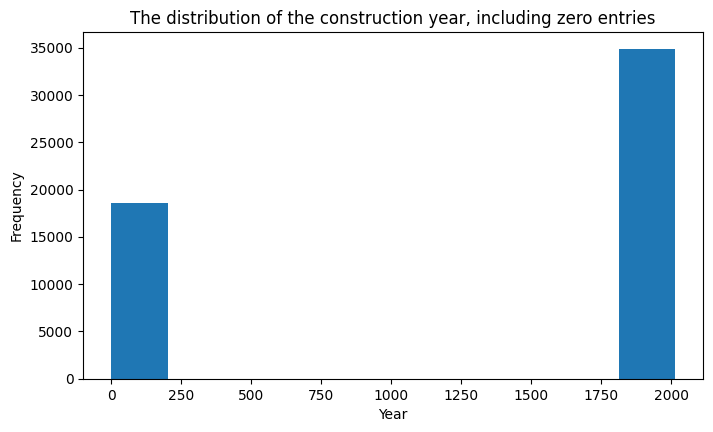

In [47]:
X_train.construction_year.plot.hist(figsize = (8, 4.5))
plt.title('The distribution of the construction year, including zero entries')
plt.xlabel('Year')
plt.show()

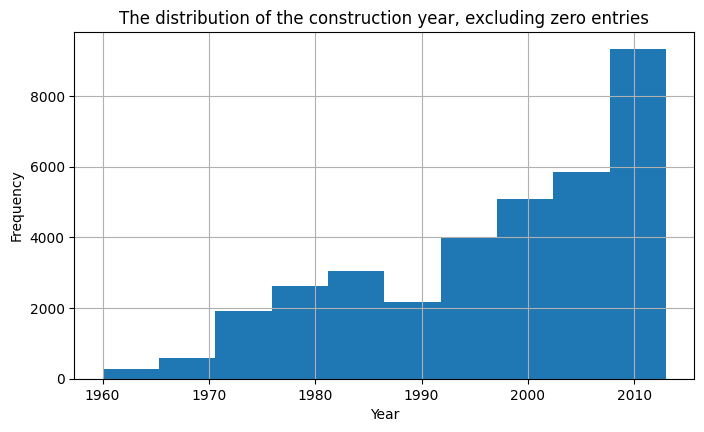

In [48]:
X_train[X_train.construction_year != 0].construction_year.plot.hist(figsize = (8, 4.5))
plt.title('The distribution of the construction year, excluding zero entries')
plt.xlabel('Year')
plt.grid()
plt.show()

In [49]:
ecdf = ECDF(X_train[X_train.construction_year != 0].construction_year)

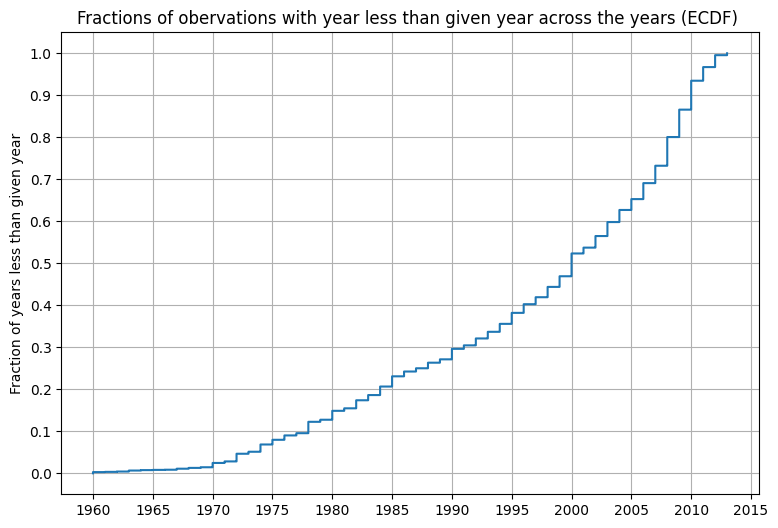

In [50]:
plt.figure(figsize = (9, 6))
plt.step(ecdf.x, ecdf.y)
plt.grid()
plt.yticks([i / 10 for i in range(11)])
plt.xticks([*range(1960, 2020, 5)])
plt.title('Fractions of obervations with year less than given year across the years (ECDF) ')
plt.ylabel('Fraction of years less than given year')
plt.show()

In [51]:
X_train[X_train.construction_year != 0].construction_year.describe().round(2)

count    34885.00
mean      1996.84
std         12.48
min       1960.00
25%       1988.00
50%       2000.00
75%       2008.00
max       2013.00
Name: construction_year, dtype: float64

In [52]:
cv_coef = round(12.48 / 1996.84, 2)
cv_coef

0.01

In [53]:
X_train.construction_year.isnull().sum()

0

In [54]:
X_train.loc[X_train.construction_year == 0, 'construction_year'] = np.nan

In [55]:
X_train.construction_year.isnull().sum()

18575

The mean value of non-zero entries in construction_year -  1997 would seem to be a good candidate for the imputed value of the NaNs in year.
It's close to the median and there is little variation in this data. Since there are no outliers and the sample mean is an unbiased estmiator of the population mean, it's better to choose the mean over the median for imputing missing values.

In [56]:
count_values(df = X_train, value = 0)

,Count of 0,0's as % of Total
Feature,,
gps_height,18313,34.3
district_code,22,0.0


In [57]:
X_train[X_train.gps_height == 0]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,0,WEDECO,33.179596,-4.214966e+00,Hospitali,Internal,Majengo,Tabora,14,1,Nzega,Nzega Urban,NaN,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
44490,0.0,2012-10-12,Rwssp,0,RWSSP,33.071249,-3.803178e+00,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3,Shinyanga Rural,Didia,NaN,True,GeoData Consultants Ltd,WUG,NaN,True,NaN,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
37560,0.0,2011-03-15,Mkinga Distric Coun,0,DWE,38.768891,-4.751313e+00,Shabani Wambua,Pangani,Kibaoni B,Tanga,4,8,Mkinga,Daluni,400.0,True,GeoData Consultants Ltd,VWC,Kigongoi gravity wat,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,enough,other,other,unknown,communal standpipe,communal standpipe
12282,0.0,2011-08-07,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,Bombani,Lake Victoria,K/Center,Mwanza,19,6,Geita,Kakora,NaN,True,GeoData Consultants Ltd,VWC,Nyamtukuza,True,NaN,ksb,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,lake,river/lake,surface,hand pump,hand pump
4136,0.0,2011-03-30,NaN,0,NaN,33.037957,-9.365355e+00,Tingatinga,Lake Nyasa,Ibana,Mbeya,12,5,Ileje,Chitete,NaN,True,GeoData Consultants Ltd,VWC,NaN,False,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50530,0.0,2011-03-24,World Bank,0,Inter,36.644403,-6.249858e+00,Kwa John Makago,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Iduo,NaN,True,GeoData Consultants Ltd,VWC,Iduo,False,NaN,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
5457,0.0,2011-03-14,Bsf,0,DWE,35.238399,-5.172737e+00,Machineni,Internal,Kilimba B,Dodoma,1,1,Kondoa,Ovada,NaN,True,GeoData Consultants Ltd,VWC,Ovad,False,NaN,cemo,other motorpump,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
45990,10.0,2011-04-02,Quick Wings,0,Korogwe water works,38.466952,-5.172985e+00,Kanisani,Pangani,Manzese,Tanga,4,2,Korogwe,Korogwe,1000.0,True,GeoData Consultants Ltd,VWC,NaN,True,2008.0,afridev,afridev,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


The zeros in gps_height are not actual values - for example ward Kakora has an elevation of 1200 m, not 0 m
(https://elevationmap.net/kakora-nyang-wale-tz-1012568019). The zeros represents missing values.

In [58]:
X_train.loc[X_train.gps_height == 0, 'gps_height'] = np.nan

In [59]:
X_train.gps_height.isnull().sum()

18313

In [60]:
X_train[X_train.district_code == 0].groupby('ward').size()

ward
Gode Gode     5
Matomondo    17
dtype: int64

In [61]:
X_train.ward.value_counts()

Igosi               276
Imalinyi            223
Siha Kati           212
Mdandu              206
Nduruma             190
                   ... 
Mwanga Kaskazini      1
Ifinga                1
Chinugulu             1
Kapilula              1
Mkumbi                1
Name: ward, Length: 2089, dtype: int64

In [62]:
X_train[(X_train.district_code != 0) & (X_train.ward.isin(['Gode Gode', 'Matomondo']))]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [63]:
X_train[X_train.district_code == 0].groupby('region').size()

region
Dodoma    22
dtype: int64

In [64]:
X_train[X_train.district_code == 0].groupby(['region', 'ward', 'subvillage']).size()

region  ward       subvillage  
Dodoma  Gode Gode  Chamwino A      2
                   Chang'Ombe      1
                   Ng'Ambo         2
        Matomondo  Bondeni         2
                   Ikulu           2
                   Kaloleni B      2
                   Majengo         1
                   Mangwe          2
                   Manyata         1
                   Mbuyuni         2
                   Misheni         1
                   Misheni B       1
                   Msunjilile      1
                   Sangandunghu    1
                   Shuleni         1
dtype: int64

There is just no district code data for couple of villages in Gode Gode and Matomondo wards.

In [65]:
X_train.loc[X_train.district_code == 0, 'district_code'] = np.nan

In [66]:
X_train.district_code.isnull().sum()

22

In [67]:
count_values(df = X_train, value = 0)

,Count of 0,0's as % of Total
Feature,,


In [68]:
(X_train.isnull().sum().sort_values(ascending = False) / len(X_train)).round(2).head(10)

scheme_name          0.47
population           0.36
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
subvillage           0.01
dtype: float64

In [69]:
len(X_train) == len(y_train)

True

In [70]:
X_train.index

Int64Index([31080, 17282, 72545, 44490, 67816, 37560, 12282,  4136, 40776,
            61121,
            ...
            45990, 47858, 15504, 46009, 51225, 68525, 11980, 35778, 49444,
            23812],
           dtype='int64', name='id', length=53460)

In [71]:
y_train.index

Int64Index([31080, 17282, 72545, 44490, 67816, 37560, 12282,  4136, 40776,
            61121,
            ...
            45990, 47858, 15504, 46009, 51225, 68525, 11980, 35778, 49444,
            23812],
           dtype='int64', name='id', length=53460)

In [72]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,NaN,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,NaN,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam
17282,50.0,2013-02-16,Jaica,-33.0,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.0,True,GeoData Consultants Ltd,VWC,Tangazo water supply,True,2008.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
72545,0.0,2011-03-20,Dhv,298.0,DWE,36.353508,-8.780099,Kwa Mgirigiti,Rufiji,Kilungwili,Morogoro,5,4.0,Ulanga,Mtimbira,1.0,True,GeoData Consultants Ltd,NaN,NaN,True,1991.0,other,other,other,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other
44490,0.0,2012-10-12,Rwssp,NaN,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,NaN,True,GeoData Consultants Ltd,WUG,NaN,True,NaN,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
67816,5.0,2013-02-04,Ces (gmbh),1088.0,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.0,True,GeoData Consultants Ltd,Water Board,Lyamungo umbwe water supply,True,2007.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


In [73]:
y_train.head()

,status_group
id,
31080,functional
17282,non functional
72545,non functional
44490,non functional
67816,functional


In [74]:
Xy_train = X_train.reset_index().merge(y_train.reset_index(), how = 'inner')

In [75]:
Xy_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,31080,0.0,2012-10-10,Dwe,NaN,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,NaN,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
1,17282,50.0,2013-02-16,Jaica,-33.0,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.0,True,GeoData Consultants Ltd,VWC,Tangazo water supply,True,2008.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
2,72545,0.0,2011-03-20,Dhv,298.0,DWE,36.353508,-8.780099,Kwa Mgirigiti,Rufiji,Kilungwili,Morogoro,5,4.0,Ulanga,Mtimbira,1.0,True,GeoData Consultants Ltd,NaN,NaN,True,1991.0,other,other,other,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
3,44490,0.0,2012-10-12,Rwssp,NaN,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,NaN,True,GeoData Consultants Ltd,WUG,NaN,True,NaN,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
4,67816,5.0,2013-02-04,Ces (gmbh),1088.0,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.0,True,GeoData Consultants Ltd,Water Board,Lyamungo umbwe water supply,True,2007.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


In [76]:
Xy_train.index = Xy_train['id'].copy()
del Xy_train['id']

In [77]:
Xy_train.head(1)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,NaN,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,NaN,False,GeoData Consultants Ltd,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional


<center>Looking at the distribution of labels</center>

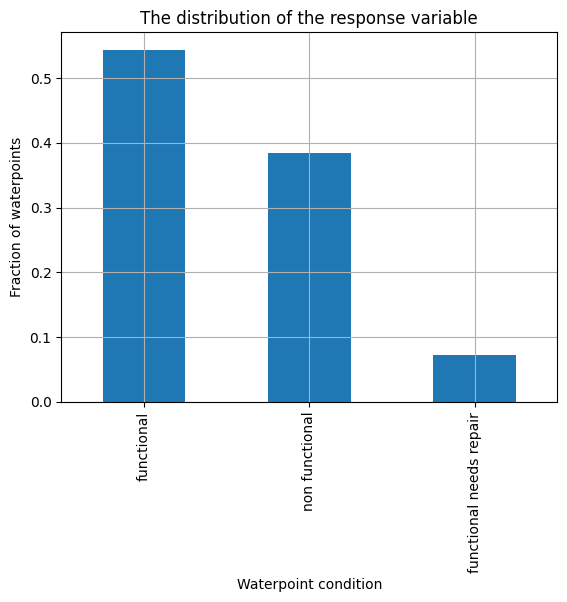

In [78]:
Xy_train.status_group.value_counts(normalize = True).plot.bar()
plt.grid()
plt.title('The distribution of the response variable')
plt.ylabel('Fraction of waterpoints')
plt.xlabel('Waterpoint condition')
plt.show()

# How do the numeric features vary with the response variable ?

In [79]:
Xy_train_num = Xy_train[[c for c in Xy_train.columns if Xy_train[c].dtype in ['int64', 'float64']] + ['status_group']]

In [80]:
Xy_train_num

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,status_group
id,,,,,,,,,
31080,0.0,NaN,33.179596,-4.214966,14,1.0,NaN,NaN,functional
17282,50.0,-33.0,40.322805,-10.456297,99,1.0,1000.0,2008.0,non functional
72545,0.0,298.0,36.353508,-8.780099,5,4.0,1.0,1991.0,non functional
44490,0.0,NaN,33.071249,-3.803178,17,3.0,NaN,NaN,non functional
67816,5.0,1088.0,37.271938,-3.283501,3,4.0,50.0,2007.0,functional
...,...,...,...,...,...,...,...,...,...
68525,1000.0,327.0,36.367112,-8.774761,5,4.0,255.0,1995.0,functional
11980,1000.0,1743.0,34.531524,-9.769604,11,5.0,35.0,1988.0,functional
35778,0.0,-13.0,38.974416,-5.420823,4,5.0,1000.0,2005.0,non functional


In [81]:
count_values(df = Xy_train, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,
amount_tsh,37474,70.1
longitude,1621,3.0


In [82]:
def plot_seaborn_box(x, y, data, title = None, xlabel = None,\
                     ylabel = None, grid = True,\
                    xticks = None, yticks = None, figsize = None) :
    
    """
    
    Example
    -------
    sns.boxplot(y = 'construction_year', x = 'status_group', data = Xy_train_num)
    """
    
    if xlabel :
        plt.xlabel(xlabel)
    
    if ylabel :
        plt.ylabel(ylabel)
    
    if title :
        plt.title(title)
    
    if xticks :
        plt.xticks(xticks)
        
    if yticks :
        plt.yticks(yticks)
    
    sns.boxplot(y = y, x = x, data = data)
    plt.show()

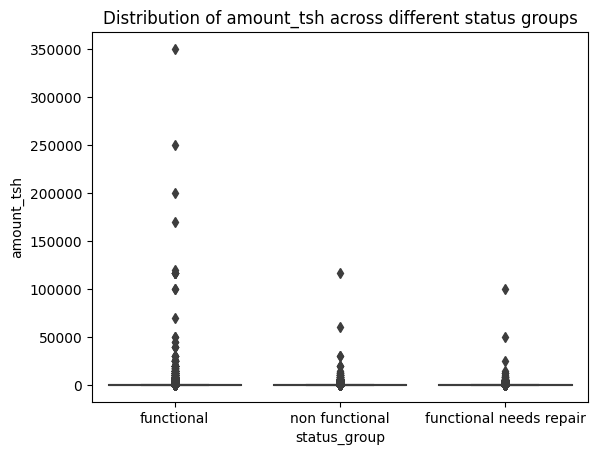

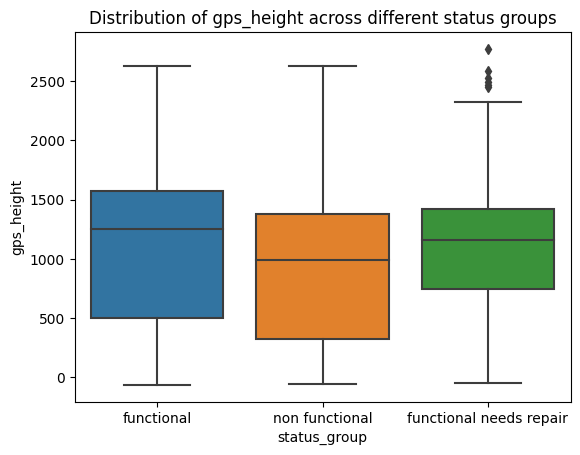

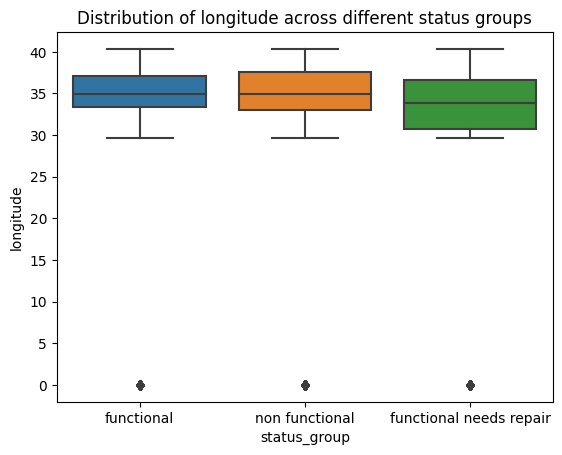

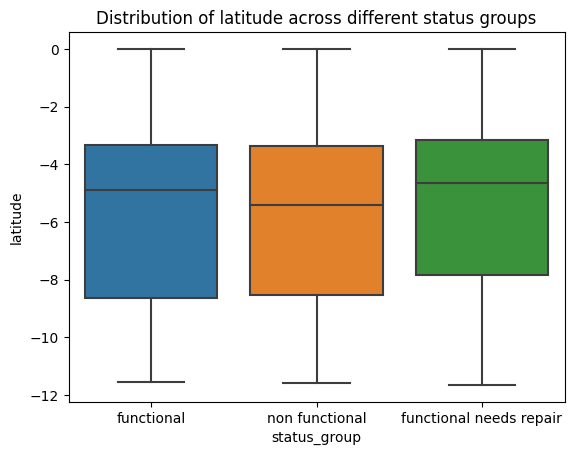

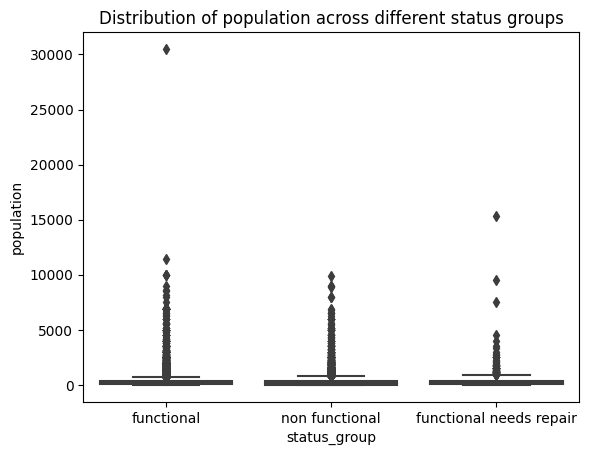

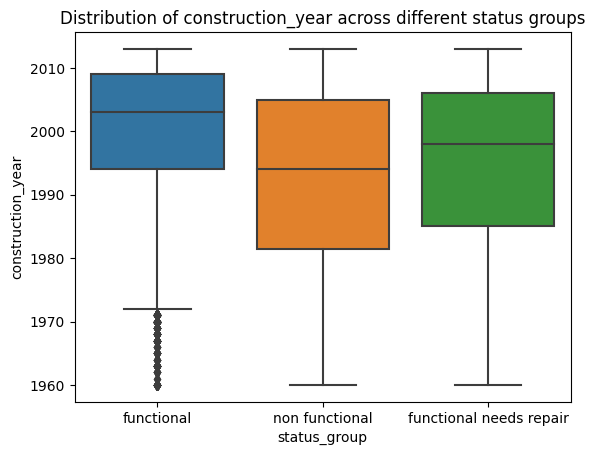

In [83]:
for c in Xy_train_num.columns :
    if (c not in ['status_group', 'id']) & ('code' not in c) :
        print()
        plot_seaborn_box(y = c, x = 'status_group', data = Xy_train_num,\
                         title = 'Distribution of {} across different status groups'\
                         .format(c))
        print()

Based on the boxplots above we find :
- Amount_tsh (amount of water in the well) contain extreme values which distort the distribution and must be explored further
- Functional waterpoints have a median height of about 1250 m compared to 1000 m for non functional ones
- Tanzania is between 29 and 40 degrees East (checked on Web), so any entries whose longitude are not in this range must be incorrect. There are such entries, so they should be treated as NaNs
- There may be incorrect entries in latitude, since there are values as high as 0, whereas Tanzania latitude ranges approxmiately from -1 to -12.5
- The distribution of population needs to be examined more thorougly as the potentiall outliers distort the image

# How do categorical features vary with the response ?

In [84]:
variables_cardinality = {}

for c in Xy_train.columns :
    if Xy_train[c].dtype == 'O' :
        num_uniq = len(Xy_train[c].unique())
        variables_cardinality[c] = [num_uniq]
        print()
        print(f'Variable {c} is categorical and it"s cardinality is {num_uniq}')
        print()


Variable date_recorded is categorical and it"s cardinality is 354


Variable funder is categorical and it"s cardinality is 1789


Variable installer is categorical and it"s cardinality is 2036


Variable wpt_name is categorical and it"s cardinality is 34085


Variable basin is categorical and it"s cardinality is 9


Variable subvillage is categorical and it"s cardinality is 18284


Variable region is categorical and it"s cardinality is 21


Variable lga is categorical and it"s cardinality is 125


Variable ward is categorical and it"s cardinality is 2089


Variable public_meeting is categorical and it"s cardinality is 3


Variable recorded_by is categorical and it"s cardinality is 1


Variable scheme_management is categorical and it"s cardinality is 13


Variable scheme_name is categorical and it"s cardinality is 2630


Variable permit is categorical and it"s cardinality is 3


Variable extraction_type is categorical and it"s cardinality is 18


Variable extraction_type_group is categ

In [85]:
Xy_train.shape

(53460, 39)

In [86]:
cardinality_frame = pd.DataFrame.from_dict(variables_cardinality).transpose()\
.rename(columns = {0 : 'Number of unique values'}).sort_values(ascending = False, by = 'Number of unique values')
cardinality_frame

,Number of unique values
wpt_name,34085
subvillage,18284
scheme_name,2630
ward,2089
installer,2036
funder,1789
date_recorded,354
lga,125
region,21
extraction_type,18


In [87]:
managable_cardinality = cardinality_frame[cardinality_frame < 125].dropna()
managable_cardinality

,Number of unique values
region,21.0
extraction_type,18.0
scheme_management,13.0
extraction_type_group,13.0
management,12.0
source,10.0
basin,9.0
water_quality,8.0
extraction_type_class,7.0
payment,7.0


In [88]:
Xy_train.recorded_by.value_counts()

GeoData Consultants Ltd    53460
Name: recorded_by, dtype: int64

Recorded by has only one unique values, so it should be deleted, as it won't affect predictions.

In [89]:
del Xy_train['recorded_by']

In [90]:
managable_cardinality = managable_cardinality.drop('recorded_by')

In [91]:
managable_cardinality

,Number of unique values
region,21.0
extraction_type,18.0
scheme_management,13.0
extraction_type_group,13.0
management,12.0
source,10.0
basin,9.0
water_quality,8.0
extraction_type_class,7.0
payment,7.0


In [92]:
less_ten_uniq_vals = managable_cardinality[managable_cardinality < 10].dropna()

In [93]:
at_least_ten_uniq_vals = managable_cardinality[managable_cardinality >= 10].dropna()

In [94]:
less_ten_uniq_vals

,Number of unique values
basin,9.0
water_quality,8.0
extraction_type_class,7.0
payment,7.0
payment_type,7.0
waterpoint_type,7.0
source_type,7.0
waterpoint_type_group,6.0
quality_group,6.0
management_group,5.0


# Normalize counts later

In [95]:
pivot = plot_grouped_bar(Xy_train, ['basin', 'status_group'], 'basin', 'status_group',\
                 title = 'Counts of different categories of basin across categories of the waterpoint status group',\
                xlabel = 'Category of basin', ylabel = 'Count',\
                 leg_title = 'Waterpoint status group', pivot_only = True)
pivot

status_group,functional,functional needs repair,non functional
basin,,,
Internal,4049,502,2441
Lake Nyasa,2995,225,1362
Lake Rukwa,902,239,1066
Lake Tanganyika,2810,675,2320
Lake Victoria,4559,900,3737
Pangani,4858,419,2790
Rufiji,4559,391,2209
Ruvuma / Southern Coast,1510,293,2259
Wami / Ruvu,2820,248,2322


In [96]:
#pd.concat([pivot.loc['Internal'] / pivot.loc['Internal'].sum())

<Figure size 1400x1000 with 0 Axes>

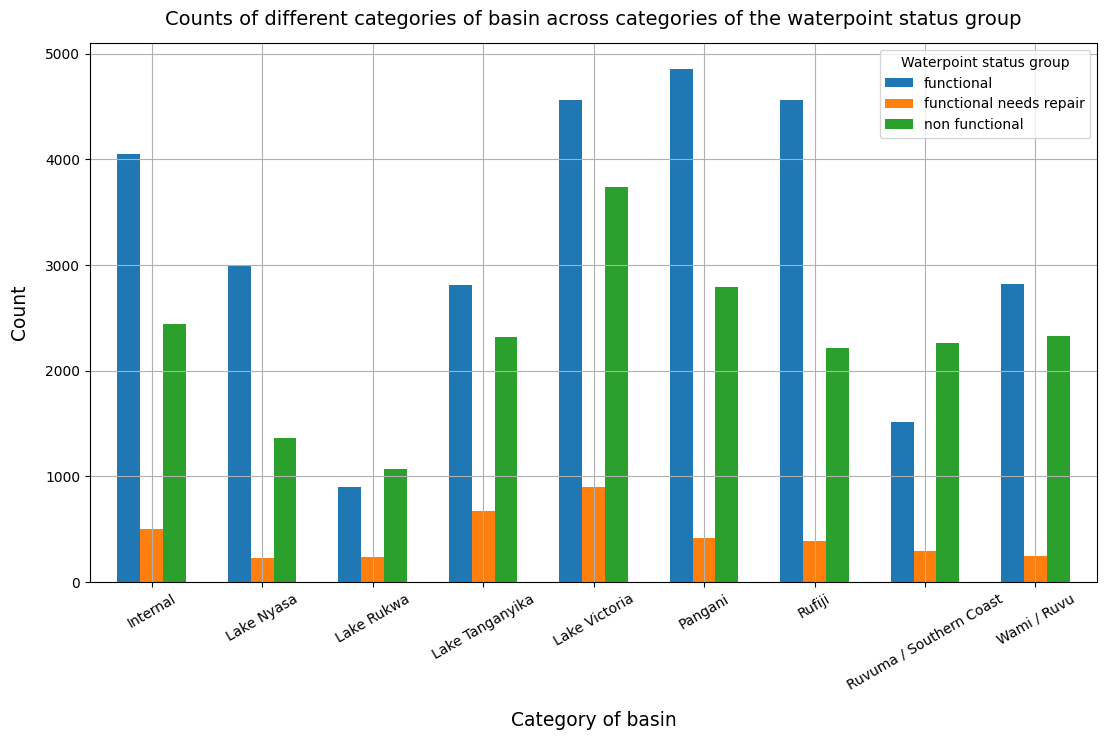

<Figure size 1400x1000 with 0 Axes>

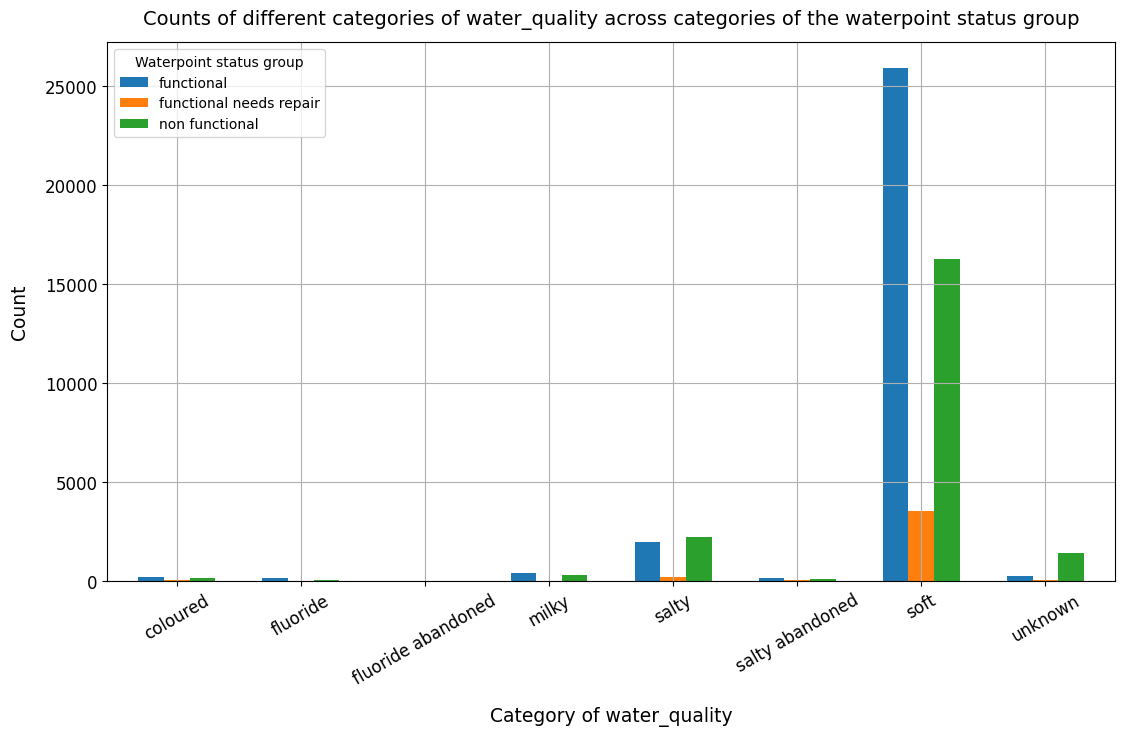

<Figure size 1400x1000 with 0 Axes>

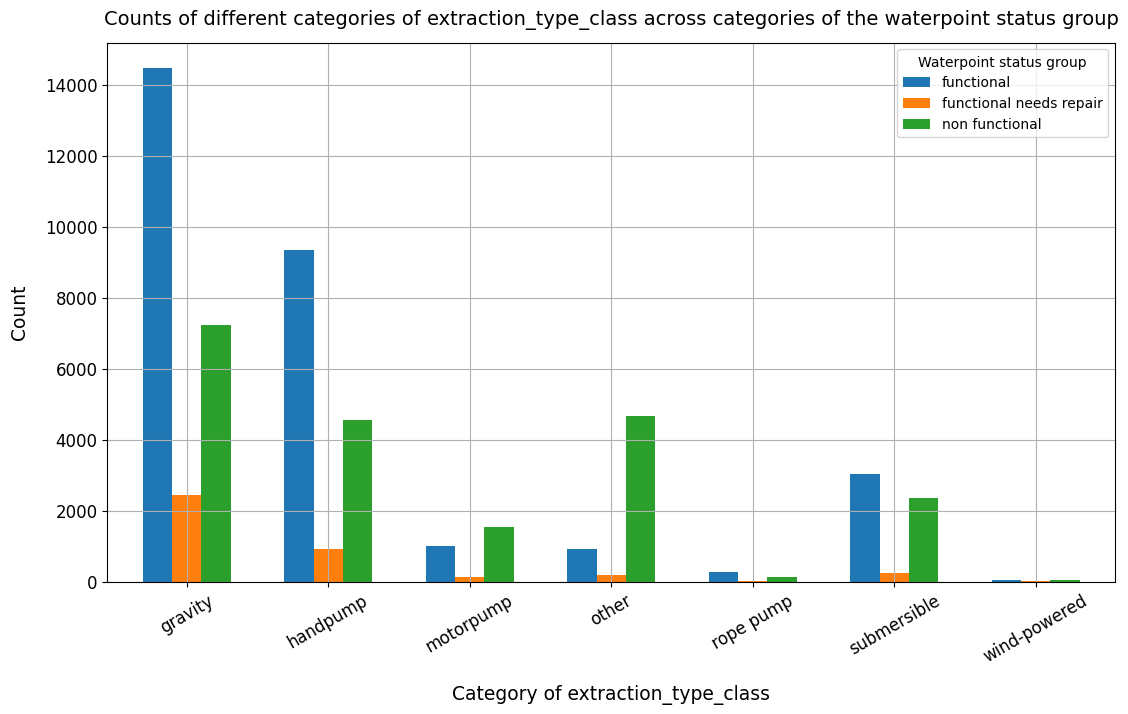

<Figure size 1400x1000 with 0 Axes>

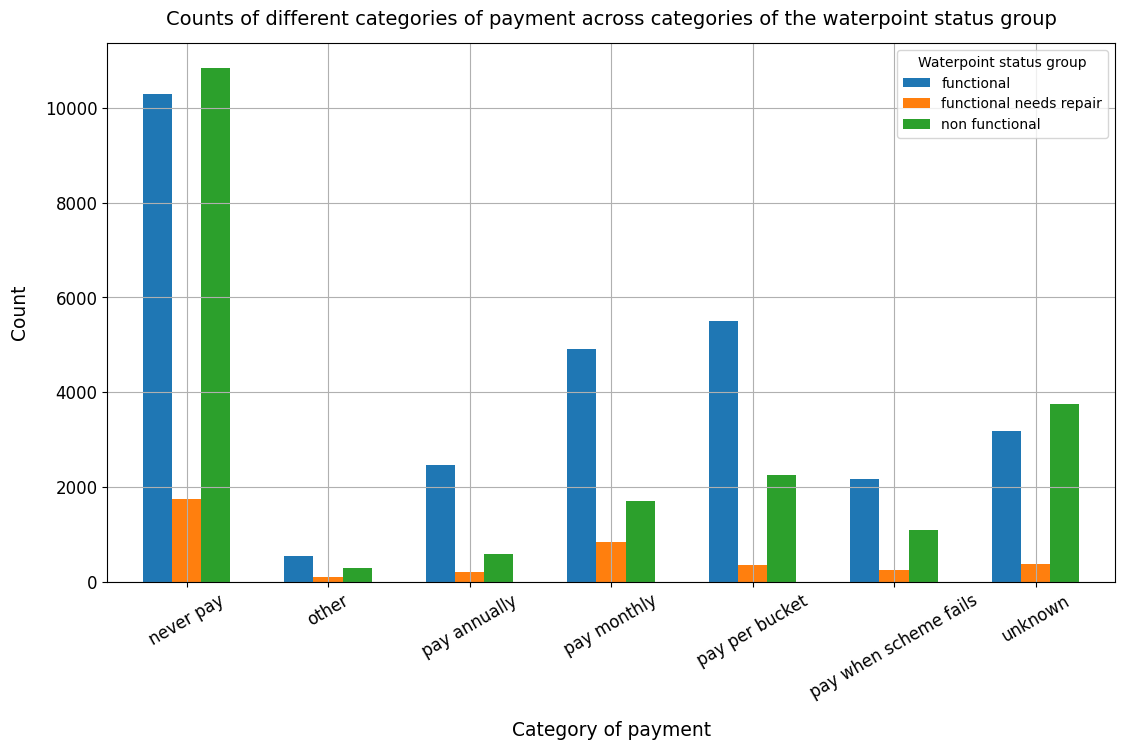

<Figure size 1400x1000 with 0 Axes>

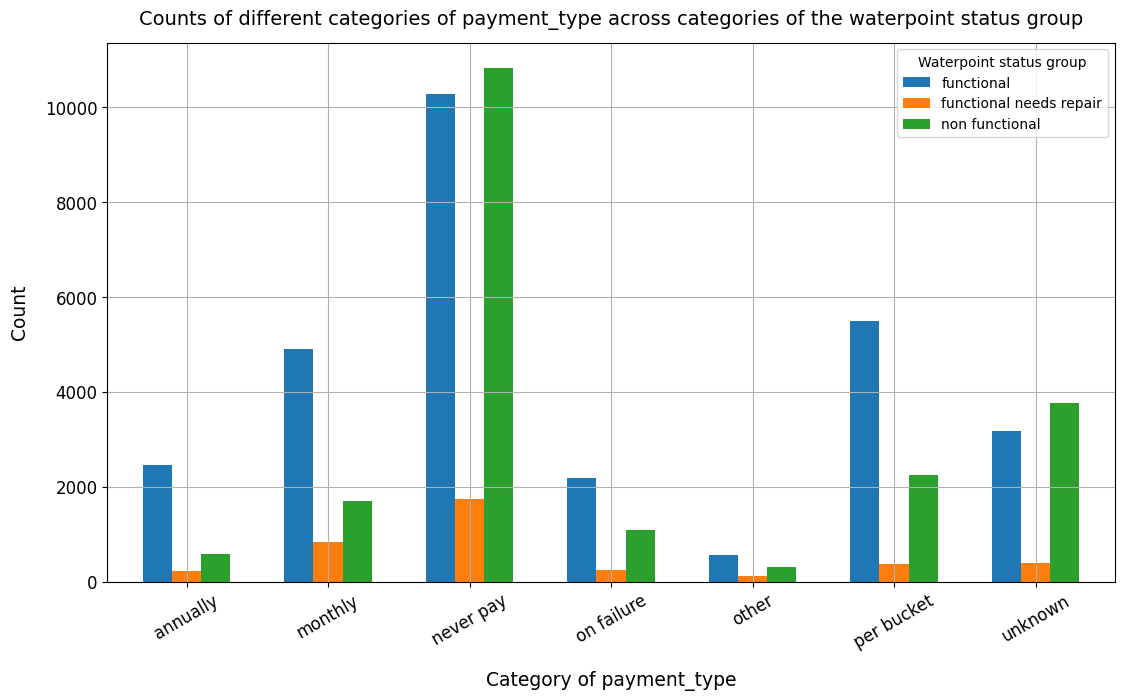

<Figure size 1400x1000 with 0 Axes>

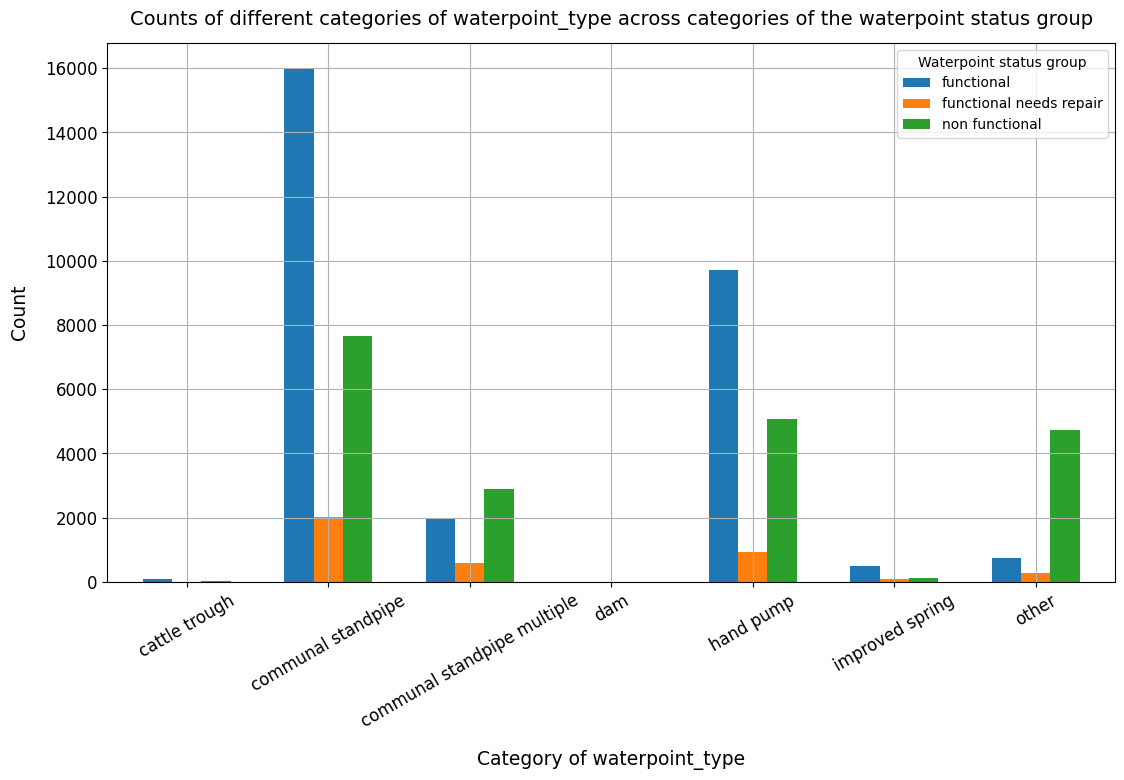

<Figure size 1400x1000 with 0 Axes>

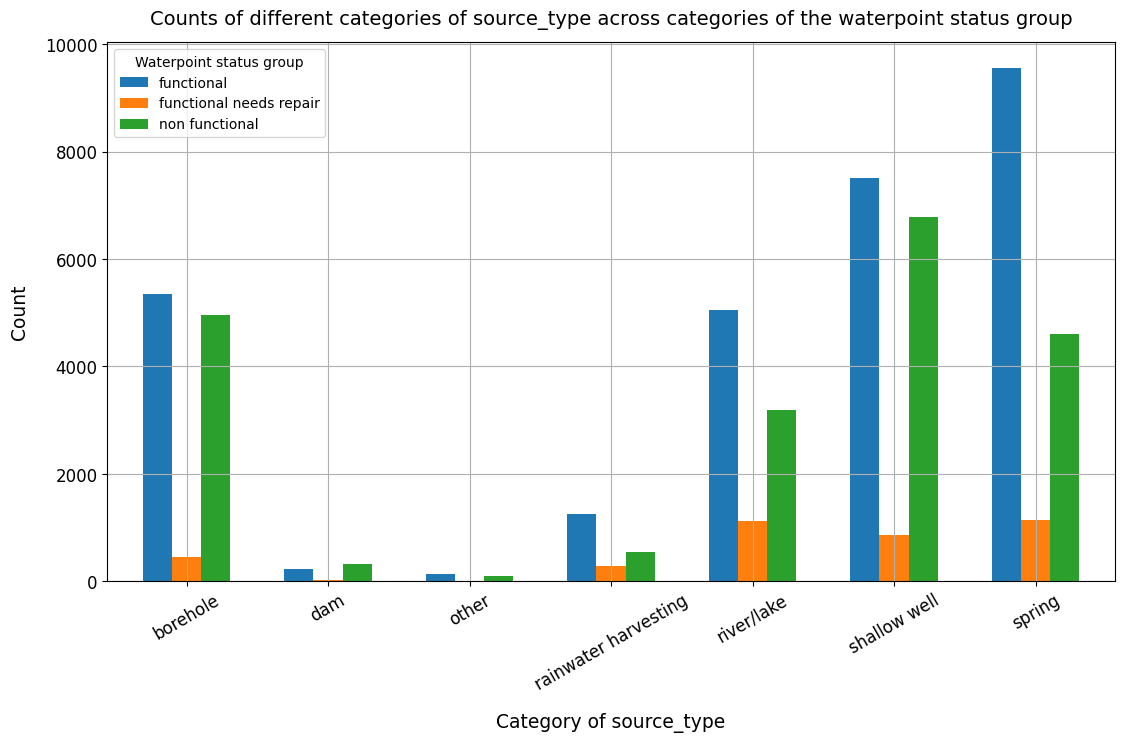

<Figure size 1400x1000 with 0 Axes>

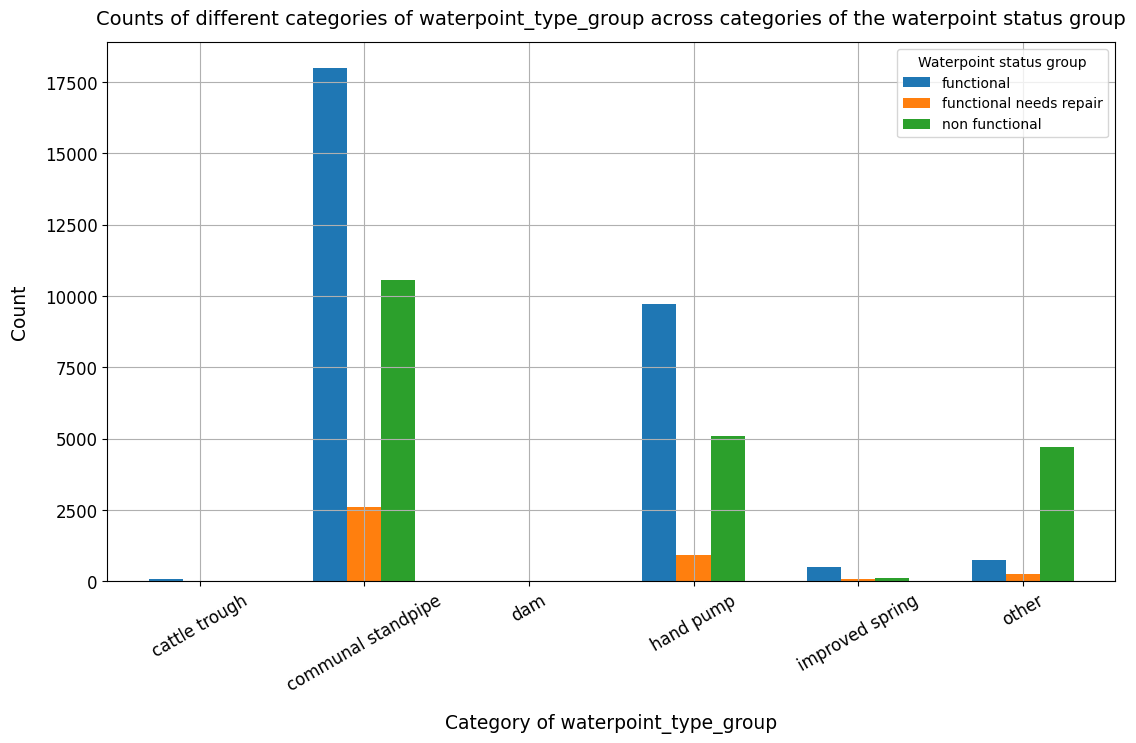

<Figure size 1400x1000 with 0 Axes>

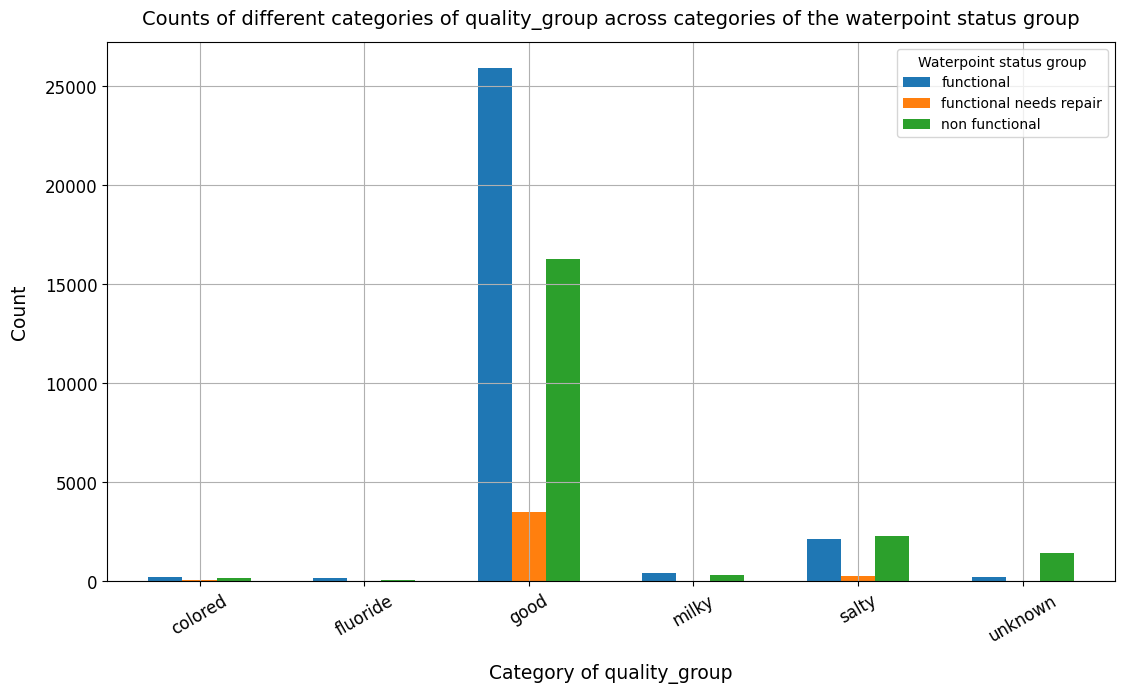

<Figure size 1400x1000 with 0 Axes>

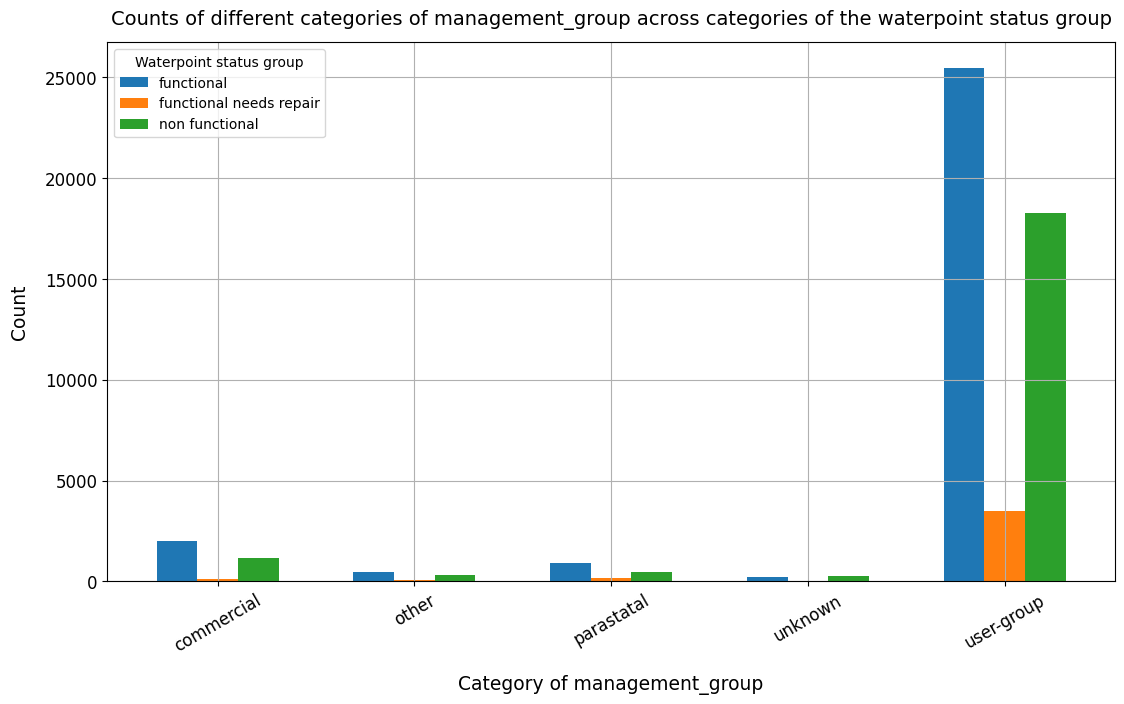

<Figure size 1400x1000 with 0 Axes>

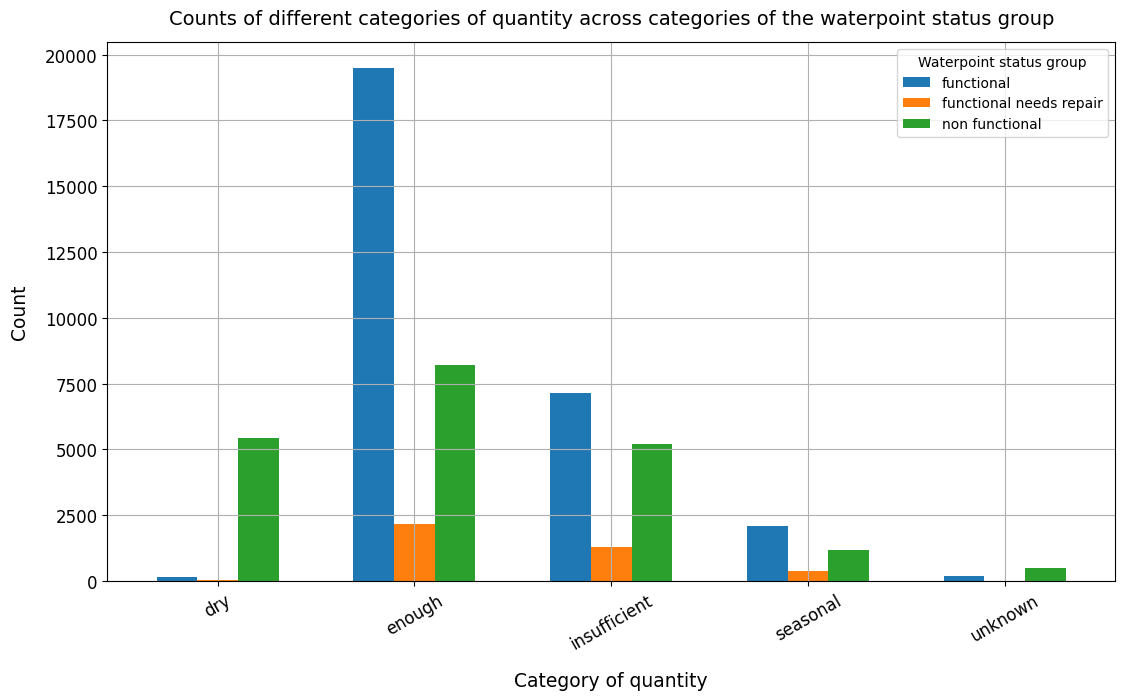

<Figure size 1400x1000 with 0 Axes>

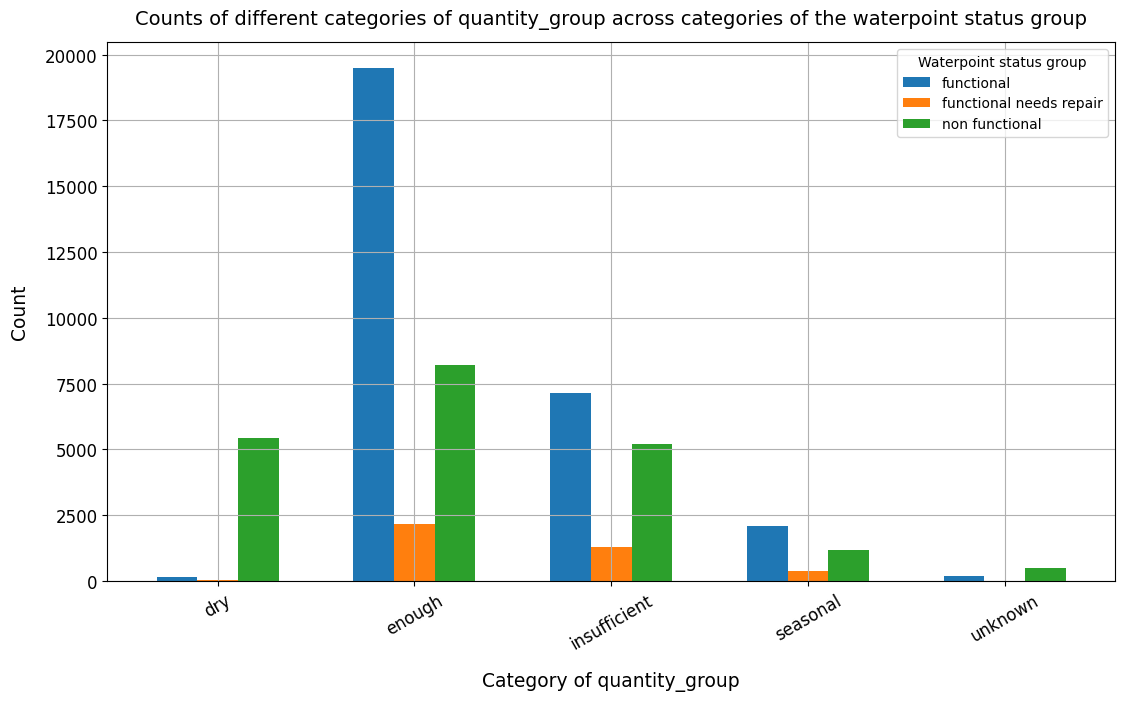

<Figure size 1400x1000 with 0 Axes>

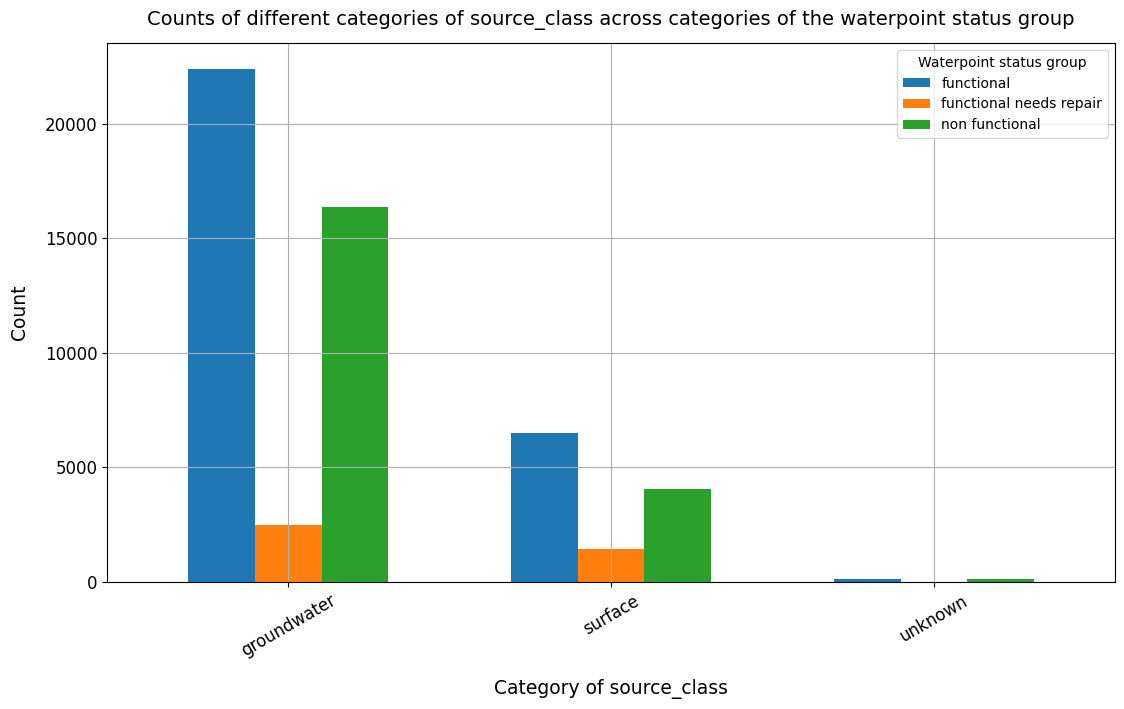

<Figure size 1400x1000 with 0 Axes>

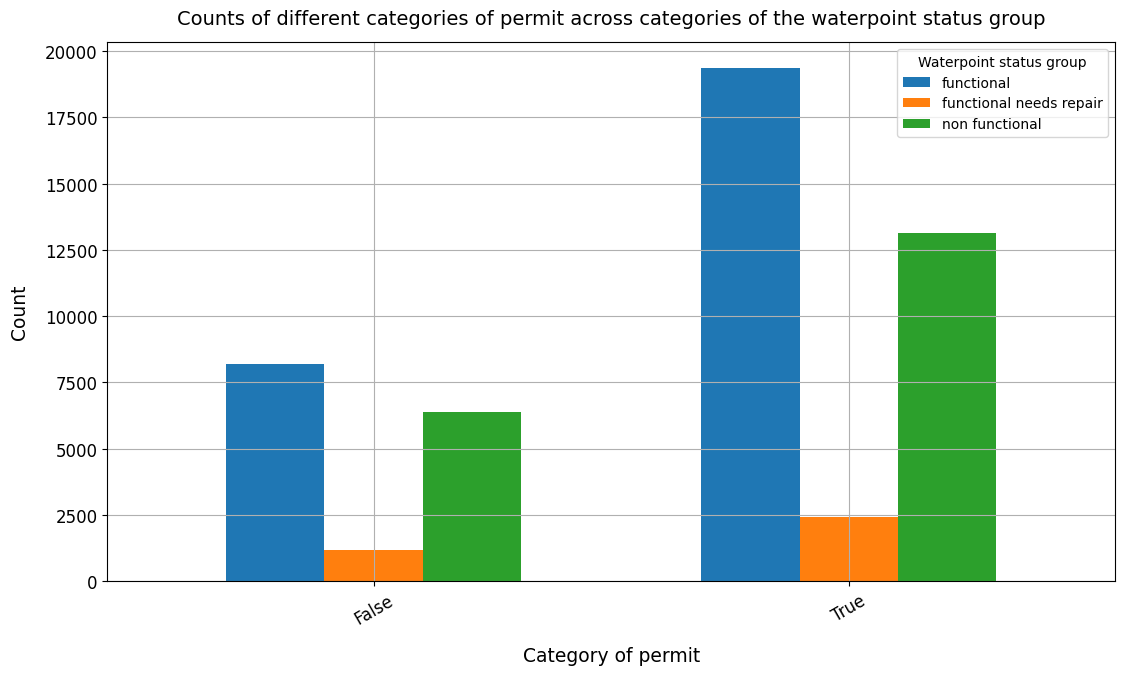

<Figure size 1400x1000 with 0 Axes>

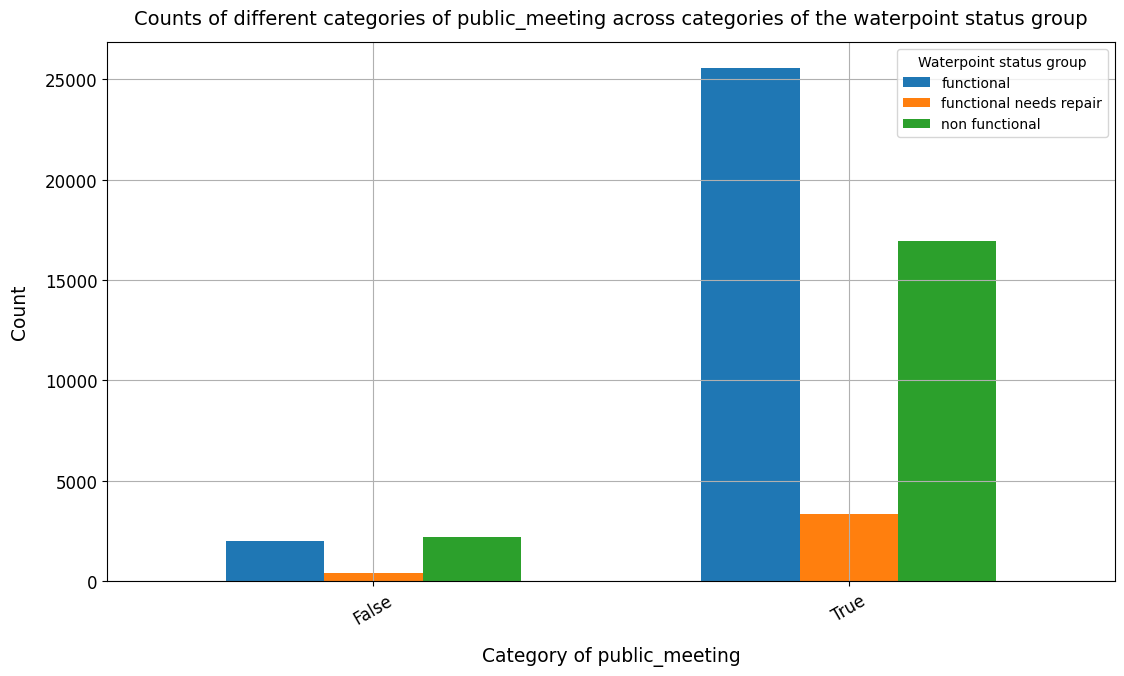

In [97]:
for i, v in zip(less_ten_uniq_vals.index, less_ten_uniq_vals.values) :
    if i != 'status_group' :
        plt.figure(figsize = (14, 10))
        plot_grouped_bar(Xy_train, [i, 'status_group'], i, 'status_group',\
                    title = f'Counts of different categories of {i} across categories of the waterpoint status group',\
                xlabel = f'Category of {i}', ylabel = 'Count',\
                    leg_title = 'Waterpoint status group')
        
       

We can observe that :
- 

In [98]:
for i, v in zip(at_least_ten_uniq_vals.index, at_least_ten_uniq_vals.values) :
    if i != 'status_group' :
        print()
        display(plot_grouped_bar(Xy_train, [i, 'status_group'], i, 'status_group',\
                    title = f'Counts of different categories of {i} across categories of the waterpoint status group',\
                xlabel = f'Category of {i}', ylabel = 'Count',\
                    leg_title = 'Waterpoint status group', pivot_only = True))
        print()

status_group,functional,functional needs repair,non functional
region,,,
Arusha,2079,159,789
Dar es Salaam,418,3,313
Dodoma,891,186,870
Iringa,3744,113,913
Kagera,1538,276,1156
Kigoma,1221,551,761
Kilimanjaro,2379,278,1285
Lindi,419,79,896
Manyara,898,80,447


status_group,functional,functional needs repair,non functional
extraction_type,,,
afridev,1067.0,39.0,471.0
cemo,40.0,7.0,32.0
climax,7.0,NaN,24.0
gravity,14466.0,2425.0,7223.0
india mark ii,1315.0,70.0,788.0
india mark iii,39.0,1.0,47.0
ksb,630.0,24.0,606.0
mono,958.0,119.0,1469.0
nira/tanira,4883.0,581.0,1878.0


status_group,functional,functional needs repair,non functional
scheme_management,,,
Company,482.0,31.0,437.0
None,1.0,NaN,NaN
Other,414.0,19.0,257.0
Parastatal,874.0,185.0,460.0
Private operator,660.0,22.0,278.0
SWC,16.0,1.0,68.0
Trust,40.0,5.0,20.0
VWC,17129.0,2094.0,13924.0
WUA,1796.0,215.0,584.0


status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,1067,39,471
gravity,14466,2425,7223
india mark ii,1315,70,788
india mark iii,39,1,47
mono,958,119,1469
nira/tanira,4883,581,1878
other,921,187,4674
other handpump,159,19,151
other motorpump,47,7,56


status_group,functional,functional needs repair,non functional
management,,,
company,239,13,362
other,453,49,254
other - school,20,1,69
parastatal,918,192,485
private operator,1320,41,396
trust,41,6,25
unknown,203,26,273
vwc,18439,2508,15538
water authority,405,46,365


status_group,functional,functional needs repair,non functional
source,,,
dam,223,22,329
hand dtw,432,15,327
lake,141,11,524
machine dbh,4913,442,4626
other,114,1,79
rainwater harvesting,1245,283,537
river,4911,1108,2669
shallow well,7498,870,6778
spring,9555,1137,4608


In [99]:
Xy_train.population.describe().round(2)

count    34271.00
mean       279.96
std        561.79
min          1.00
25%         40.00
50%        150.00
75%        324.50
max      30500.00
Name: population, dtype: float64

In [100]:
Xy_train.groupby('status_group').population.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,18941.0,285.46,605.86,1.0,45.0,150.0,312.0,30500.0
functional needs repair,2290.0,301.62,532.68,1.0,60.0,200.0,400.0,15300.0
non functional,13040.0,268.17,496.23,1.0,1.0,150.0,320.0,9865.0


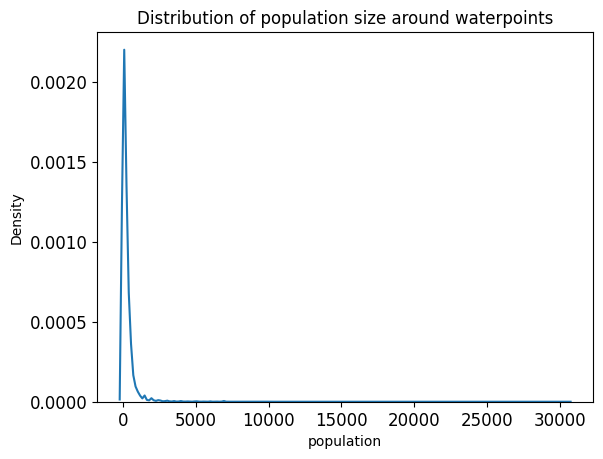

In [101]:
sns.kdeplot(x = 'population', data = Xy_train)
plt.title('Distribution of population size around waterpoints')
plt.show()

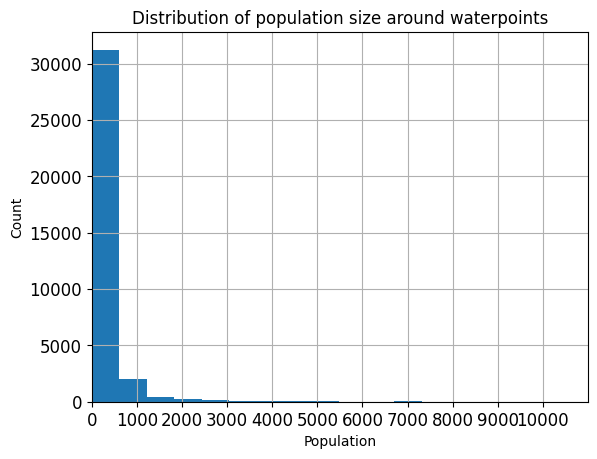

In [102]:
Xy_train.population.plot.hist(bins = 50)
plt.xlabel('Population')
plt.ylabel('Count')
plt.title('Distribution of population size around waterpoints')
plt.xlim((0, 11000))
plt.xticks([*range(0, 11000, 1000)])
plt.grid()
plt.show()

In [103]:
#pop = pd.read_csv('sample10population_above_5000.csv')
#= Xy_train[Xy_train.population > 5000].sample(n = 10)

On inspecting random 10 population entries above 5000 peeple the data seem more or less plausible, since the population around the well is always less than the actual population of the whole ward and is not so extreme.

In [104]:
Xy_train[Xy_train.population > 10000]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30750,50.0,2011-03-04,Wsdp,26.0,DWE,38.727663,-6.724701,Msagasa,Wami / Ruvu,Kilangalang,Pwani,6,2.0,Kibaha,Mlandizi,11463.0,True,VWC,Borehole,True,2006.0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
12169,0.0,2011-03-12,Government Of Tanzania,184.0,DWE,38.783756,-5.181904,Mkwajuni,Pangani,Mkwajuni,Tanga,4,3.0,Muheza,Masuguru,30500.0,True,VWC,NaN,False,2008.0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
49354,0.0,2013-02-21,Water Board,1084.0,Water board,36.386050,-4.787678,Mashineni,Internal,Engarakashi,Manyara,21,5.0,Kiteto,Makame,15300.0,True,VWC,Water board,False,1983.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional needs repair


Mkwajuni had a population of 22K back in 2002 so it's conceivable that it grew by 8500 or 39 % over the next 10 years.

https://en.wikipedia.org/wiki/Mkwajuni#:~:text=Mkwajuni%20is%20an%20administrative%20ward,a%20total%20population%20of%2022%2C101.

It seems that the values in population are on the whole correct.

In [105]:
Xy_train[Xy_train.latitude > - 0.9]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12282,0.0,2011-08-07,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Bombani,Lake Victoria,K/Center,Mwanza,19,6.0,Geita,Kakora,NaN,True,VWC,Nyamtukuza,True,NaN,ksb,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,lake,river/lake,surface,hand pump,hand pump,non functional
56023,0.0,2011-07-18,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Hospital,Lake Victoria,Nyanza,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,Kalangalala,True,NaN,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,hand pump,hand pump,functional
26944,0.0,2011-07-30,Hesawa,NaN,DWE,0.0,-2.000000e-08,Bombani,Lake Victoria,Ushirika,Mwanza,19,6.0,Geita,Kasamwa,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
45957,0.0,2011-07-24,Tanapa,NaN,TANAPA,0.0,-2.000000e-08,Jamii,Lake Victoria,Mwamongo,Shinyanga,17,1.0,Bariadi,Mwaswale,NaN,False,Parastatal,NaN,False,NaN,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
16593,0.0,2011-08-26,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Shabani,Lake Victoria,Majengo,Mwanza,19,6.0,Geita,Nyachiluluma,NaN,True,VWC,NaN,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30428,0.0,2013-02-16,Dwsp,NaN,DWE,0.0,-2.000000e-08,Muungano,Lake Victoria,Nyamswa,Shinyanga,17,1.0,Bariadi,Mhango,NaN,NaN,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
60259,0.0,2011-07-19,Hesawa,NaN,DWE,0.0,-2.000000e-08,Maige,Lake Victoria,Katundu,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
55213,0.0,2012-10-24,Hesawa,NaN,DWE,0.0,-2.000000e-08,Kwa Kanuti,Lake Victoria,Selya,Mwanza,19,2.0,Magu,Mwananyili,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [106]:
print('Some latitudes have a format like this : {}. It"s type is {}'\
      .format(Xy_train.loc[12282].latitude, type(Xy_train.loc[12282].latitude)))

Some latitudes have a format like this : -2e-08. It"s type is <class 'numpy.float64'>


In [107]:
Xy_train[Xy_train.latitude.astype(str).str.contains('-2e-08')]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12282,0.0,2011-08-07,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Bombani,Lake Victoria,K/Center,Mwanza,19,6.0,Geita,Kakora,NaN,True,VWC,Nyamtukuza,True,NaN,ksb,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,lake,river/lake,surface,hand pump,hand pump,non functional
56023,0.0,2011-07-18,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Hospital,Lake Victoria,Nyanza,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,Kalangalala,True,NaN,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,hand pump,hand pump,functional
26944,0.0,2011-07-30,Hesawa,NaN,DWE,0.0,-2.000000e-08,Bombani,Lake Victoria,Ushirika,Mwanza,19,6.0,Geita,Kasamwa,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
45957,0.0,2011-07-24,Tanapa,NaN,TANAPA,0.0,-2.000000e-08,Jamii,Lake Victoria,Mwamongo,Shinyanga,17,1.0,Bariadi,Mwaswale,NaN,False,Parastatal,NaN,False,NaN,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
16593,0.0,2011-08-26,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Shabani,Lake Victoria,Majengo,Mwanza,19,6.0,Geita,Nyachiluluma,NaN,True,VWC,NaN,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30428,0.0,2013-02-16,Dwsp,NaN,DWE,0.0,-2.000000e-08,Muungano,Lake Victoria,Nyamswa,Shinyanga,17,1.0,Bariadi,Mhango,NaN,NaN,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
60259,0.0,2011-07-19,Hesawa,NaN,DWE,0.0,-2.000000e-08,Maige,Lake Victoria,Katundu,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
55213,0.0,2012-10-24,Hesawa,NaN,DWE,0.0,-2.000000e-08,Kwa Kanuti,Lake Victoria,Selya,Mwanza,19,2.0,Magu,Mwananyili,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [108]:
Xy_train.loc[Xy_train.latitude.astype(str).str.contains('-2e-08'), 'latitude'] = np.nan

In [109]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(15)

scheme_name          0.47
population           0.36
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
latitude             0.03
subvillage           0.01
district_code        0.00
management_group     0.00
quantity_group       0.00
quantity             0.00
dtype: float64

In [110]:
Xy_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,NaN,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,NaN,False,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,50.0,2013-02-16,Jaica,-33.0,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.0,True,VWC,Tangazo water supply,True,2008.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
72545,0.0,2011-03-20,Dhv,298.0,DWE,36.353508,-8.780099,Kwa Mgirigiti,Rufiji,Kilungwili,Morogoro,5,4.0,Ulanga,Mtimbira,1.0,True,NaN,NaN,True,1991.0,other,other,other,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
44490,0.0,2012-10-12,Rwssp,NaN,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,NaN,True,WUG,NaN,True,NaN,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,5.0,2013-02-04,Ces (gmbh),1088.0,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.0,True,Water Board,Lyamungo umbwe water supply,True,2007.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


In [111]:
Xy_train[(Xy_train.longitude > 40.5) | (Xy_train.longitude < 28.5)]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12282,0.0,2011-08-07,Government Of Tanzania,NaN,Government,0.0,NaN,Bombani,Lake Victoria,K/Center,Mwanza,19,6.0,Geita,Kakora,NaN,True,VWC,Nyamtukuza,True,NaN,ksb,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,lake,river/lake,surface,hand pump,hand pump,non functional
56023,0.0,2011-07-18,Government Of Tanzania,NaN,Government,0.0,NaN,Hospital,Lake Victoria,Nyanza,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,Kalangalala,True,NaN,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,hand pump,hand pump,functional
26944,0.0,2011-07-30,Hesawa,NaN,DWE,0.0,NaN,Bombani,Lake Victoria,Ushirika,Mwanza,19,6.0,Geita,Kasamwa,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
45957,0.0,2011-07-24,Tanapa,NaN,TANAPA,0.0,NaN,Jamii,Lake Victoria,Mwamongo,Shinyanga,17,1.0,Bariadi,Mwaswale,NaN,False,Parastatal,NaN,False,NaN,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
16593,0.0,2011-08-26,Government Of Tanzania,NaN,Government,0.0,NaN,Shabani,Lake Victoria,Majengo,Mwanza,19,6.0,Geita,Nyachiluluma,NaN,True,VWC,NaN,True,NaN,ksb,submersible,submersible,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30428,0.0,2013-02-16,Dwsp,NaN,DWE,0.0,NaN,Muungano,Lake Victoria,Nyamswa,Shinyanga,17,1.0,Bariadi,Mhango,NaN,NaN,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
60259,0.0,2011-07-19,Hesawa,NaN,DWE,0.0,NaN,Maige,Lake Victoria,Katundu,Mwanza,19,6.0,Geita,Kalangalala,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
55213,0.0,2012-10-24,Hesawa,NaN,DWE,0.0,NaN,Kwa Kanuti,Lake Victoria,Selya,Mwanza,19,2.0,Magu,Mwananyili,NaN,True,VWC,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [112]:
Xy_train[(Xy_train.longitude > 40.5) | (Xy_train.longitude < 28.5)].longitude.unique()

array([0.])

In [113]:
long_nans = Xy_train.longitude.isnull().sum()
print(f'Before replacing 0.0 longitude with NaNs there were {long_nans} NaNs')

Before replacing 0.0 longitude with NaNs there were 0 NaNs


In [114]:
Xy_train.loc[Xy_train.longitude == 0, 'longitude'] = np.nan

In [115]:
print(f'After replacing 0.0 longitude with NaNs there are {Xy_train.longitude.isnull().sum()} NaNs, so there are {Xy_train.longitude.isnull().sum() - long_nans} additional NaNs')

After replacing 0.0 longitude with NaNs there are 1621 NaNs, so there are 1621 additional NaNs


In [116]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(14)

scheme_name          0.47
population           0.36
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
latitude             0.03
subvillage           0.01
district_code        0.00
source               0.00
dtype: float64

In [117]:
Xy_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,0.0,2012-10-10,Dwe,NaN,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,NaN,False,Water authority,Kilimi and uchama dam,True,NaN,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,50.0,2013-02-16,Jaica,-33.0,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.0,True,VWC,Tangazo water supply,True,2008.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
72545,0.0,2011-03-20,Dhv,298.0,DWE,36.353508,-8.780099,Kwa Mgirigiti,Rufiji,Kilungwili,Morogoro,5,4.0,Ulanga,Mtimbira,1.0,True,NaN,NaN,True,1991.0,other,other,other,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
44490,0.0,2012-10-12,Rwssp,NaN,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,NaN,True,WUG,NaN,True,NaN,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,5.0,2013-02-04,Ces (gmbh),1088.0,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.0,True,Water Board,Lyamungo umbwe water supply,True,2007.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


In [118]:
count_values(df = Xy_train, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,
amount_tsh,37474,70.1


In [119]:
Xy_train[Xy_train.region != 0].groupby('region')['amount_tsh'].nunique()

region
Arusha           21
Dar es Salaam    15
Dodoma            1
Iringa           38
Kagera            1
Kigoma           26
Kilimanjaro      38
Lindi            18
Manyara          23
Mara             20
Mbeya             1
Morogoro         25
Mtwara           23
Mwanza           13
Pwani            37
Rukwa            25
Ruvuma           35
Shinyanga         7
Singida          26
Tabora            1
Tanga            28
Name: amount_tsh, dtype: int64

In [120]:
Xy_train[Xy_train.region != 0].groupby('region')['amount_tsh'].value_counts().groupby('region').sum()

region
Arusha           3027
Dar es Salaam     734
Dodoma           1947
Iringa           4770
Kagera           2970
Kigoma           2533
Kilimanjaro      3942
Lindi            1394
Manyara          1425
Mara             1765
Mbeya            4161
Morogoro         3617
Mtwara           1565
Mwanza           2794
Pwani            2376
Rukwa            1630
Ruvuma           2387
Shinyanga        4469
Singida          1885
Tabora           1773
Tanga            2296
Name: amount_tsh, dtype: int64

In [121]:
Xy_train[Xy_train.region != 0].groupby('region')['amount_tsh'].mean()

region
Arusha            374.256690
Dar es Salaam     255.386921
Dodoma              0.000000
Iringa           1204.581761
Kagera              0.000000
Kigoma            351.320568
Kilimanjaro       257.878095
Lindi              29.167862
Manyara           243.181053
Mara              111.972238
Mbeya               0.000000
Morogoro          207.353331
Mtwara             62.783387
Mwanza             16.088046
Pwani             608.158670
Rukwa             819.677914
Ruvuma            901.567658
Shinyanga          12.553144
Singida           466.456340
Tabora              0.000000
Tanga             255.373258
Name: amount_tsh, dtype: float64

In [122]:
replace_hidden_nans(Xy_train, nan_symbol = 0.0, col_name = 'amount_tsh')

In [123]:
Xy_train.amount_tsh.isnull().sum() / len(Xy_train)

0.7009726898615788

In [124]:
count_values(df = Xy_train, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,


In [125]:
count_values(df = Xy_train, value = 0)

,Count of 0,0's as % of Total
Feature,,


In [126]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(14)

amount_tsh           0.70
scheme_name          0.47
population           0.36
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
latitude             0.03
longitude            0.03
subvillage           0.01
district_code        0.00
dtype: float64

<center>Imputing missing values on the train data</center>

scheme_name :

In [127]:
def value_counts_head(data, grouper, target, n = 5, m = 5, output = False, normalize = True) :
    
    grouped_val_counts = data.groupby(grouper)[target].value_counts(normalize = normalize)
    
    index = grouped_val_counts.index.levels[0].tolist()
    
    sub_series = []
    
    for i, v in enumerate(index) :
        if i == n - 1 :
            break
        small_series = grouped_val_counts.loc[v].head(m)
        small_series.name = v
        sub_series.append(small_series)
    
    if output :
        return sub_series
    
    for s in sub_series :
        print()
        print('The value counts in {} {} : '.format(grouper, s.name))
        print()
        display(s)
        print()

In [128]:
def grab_top_value_of_each_series(series_iterab) -> dict :
    
    """
    Parameters
    ----------
    series_iterab : list. List of elements which are of class pd.Series.
    
    Returns
    -------
    dict.
    """

    top_value_by_series_name = {}
    series_no_nans = [s.dropna() for s in series_iterab]

    for si in series_no_nans :
        if (len(si) != 0) & (si.index.is_unique) :
            top_value_by_series_name[si.name] = (si.head(1).index[0], round(si.head(1).values[0], 3))
        else :
            top_value_by_series_name[si.name] = np.nan

    return top_value_by_series_name 

In [129]:
def grouped_mode_imputat_categ(data, grouper, target, n = 5000, m = 5, output = False, normalize = True) :
    
    series_iterab = value_counts_head(data = data, grouper = grouper, target = target,\
                                      n = n, m = m, output = output, normalize = normalize)
    
    top_value_by_series_name_tups_vals = grab_top_value_of_each_series(series_iterab)
    imputatation_per_category = {k : v[0] for k, v in top_value_by_series_name_tups_vals.items()}
    
    return imputatation_per_category

In [130]:
def impute_grouped_categorical_data(data, grouper, target, n=5000, m=5, normalize=True):
    
    """
    Takes a Pandas DataFrame, a grouper column name, and a target column name as inputs.
    The function imputes missing values in the target column by filling them with the modes of the
    unique values in the grouper column. The mode modes are simply most common values per each unique value of the grouper. 
    The output of the function is the copy of original DataFrame with missing values in the target column imputed.
    
    
    Parameters
    ----------
    data : pd.DataFrame.
    grouper : str. The name of the grouper categorical
                   column for which we want to calculate the mode.
    
    target : str. The name of the categorical column whose missing
                  values we want to impute with the mode of the observations
                  of unique values of grouper.
    n : int.
    m : int.
    normalize : bool. Defaults to True.
    
    Example
    -------
    Xy_test = impute_grouped_categorical_data(Xy_test, 'region', 'scheme_name')
        
        Xy_test.scheme_name.isnull().sum()
        
        0
    """
    # so as to enable retrieving output from  function, by passing it correct argument
    output = True
    data = data.copy()
    
    # Call the grouped_mode_imputat_categ function to get the imputation values per category
    imputation_per_category = grouped_mode_imputat_categ(data, grouper, target, n=n, m=m, output=output, normalize=normalize)

    # Fill NaN values in the target column using the imputation values per category
    data[target] = data.groupby(grouper)[target].transform(lambda x: x.fillna(imputation_per_category[x.name]))
        
    return data

In [131]:
series_iterab = value_counts_head(Xy_train, grouper = 'region', target = 'scheme_name', n = 1000, output = True)
series_iterab

[scheme_name
 Machumba estate pipe line         0.061977
 Maambreni gravity water supply    0.042966
 Nabaiye pipe line                 0.036882
 Nasula gravity water supply       0.036122
 Olkokola pipe line                0.027757
 Name: Arusha, dtype: float64,
 scheme_name
 J    0.30
 M    0.28
 G    0.24
 N    0.07
 S    0.07
 Name: Dar es Salaam, dtype: float64,
 scheme_name
 Ntom    0.027458
 Cham    0.020434
 Ihum    0.015326
 Kwa     0.014687
 Kise    0.014049
 Name: Dodoma, dtype: float64,
 scheme_name
 wanging'ombe water supply s    0.058824
 wanging'ombe supply scheme     0.051932
 mtwango water supply scheme    0.033227
 Roman                          0.030765
 imalinyi supply scheme         0.018952
 Name: Iringa, dtype: float64,
 scheme_name
 Kaisho/Isingiro w                    0.066038
 NCHULOWAIBALE WATER SUPPLY SCHEME    0.056604
 Nyamitoko  water                     0.036792
 Kan                                  0.033962
 B                                    0.030189

In [132]:
mode_scheme_name_per_region = grab_top_value_of_each_series(series_iterab = series_iterab)
mode_scheme_name_per_region

{'Arusha': ('Machumba estate pipe line', 0.062),
 'Dar es Salaam': ('J', 0.3),
 'Dodoma': ('Ntom', 0.027),
 'Iringa': ("wanging'ombe water supply s", 0.059),
 'Kagera': ('Kaisho/Isingiro w', 0.066),
 'Kigoma': ('Mkongoro Two', 0.084),
 'Kilimanjaro': ("Uroki-Bomang'ombe water sup", 0.051),
 'Lindi': ('GEN Borehole Scheme', 0.082),
 'Manyara': ('Kijiji', 0.187),
 'Mara': ('Mradi wa maji Komuge', 0.128),
 'Mbeya': ('K', 0.286),
 'Morogoro': ('Ki', 0.065),
 'Mtwara': ('Borehole', 0.283),
 'Mwanza': ('None', 0.248),
 'Pwani': ('Chalinze wate', 0.354),
 'Rukwa': ('K', 0.081),
 'Ruvuma': ('DANIDA', 0.196),
 'Shinyanga': ('None', 0.457),
 'Singida': ('M', 0.181),
 'Tabora': ('World Bank', 0.133),
 'Tanga': ('Handeni Trunk Main(H', 0.082)}

In [133]:
scheme_name_imputatation_per_region = {k : v[0] for k, v in mode_scheme_name_per_region.items()}
scheme_name_imputatation_per_region

{'Arusha': 'Machumba estate pipe line',
 'Dar es Salaam': 'J',
 'Dodoma': 'Ntom',
 'Iringa': "wanging'ombe water supply s",
 'Kagera': 'Kaisho/Isingiro w',
 'Kigoma': 'Mkongoro Two',
 'Kilimanjaro': "Uroki-Bomang'ombe water sup",
 'Lindi': 'GEN Borehole Scheme',
 'Manyara': 'Kijiji',
 'Mara': 'Mradi wa maji Komuge',
 'Mbeya': 'K',
 'Morogoro': 'Ki',
 'Mtwara': 'Borehole',
 'Mwanza': 'None',
 'Pwani': 'Chalinze wate',
 'Rukwa': 'K',
 'Ruvuma': 'DANIDA',
 'Shinyanga': 'None',
 'Singida': 'M',
 'Tabora': 'World Bank',
 'Tanga': 'Handeni Trunk Main(H'}

In [134]:
Xy_train.scheme_name.isnull().sum()

25308

In [135]:
Xy_train['scheme_name'] = Xy_train.groupby('region')['scheme_name'].transform(lambda x: x.fillna(scheme_name_imputatation_per_region[x.name]))

In [136]:
Xy_train.scheme_name.isnull().sum()

0

In [137]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(13)

amount_tsh           0.70
population           0.36
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
latitude             0.03
longitude            0.03
subvillage           0.01
district_code        0.00
dtype: float64

In [138]:
from typing import Dict

def calculate_grouped_aggregations(df: pd.DataFrame, grouper: str, column: str, aggregation: str = 'mean') -> Dict:
    """
    Calculate grouped aggregations for a given DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to group and aggregate.
        grouper (str): The column to group the data by.
        column (str): The column to perform the aggregation on.
        aggregation (str): The type of aggregation to perform. Can be 'mean', 'median', or 'mode'. Defaults to 'mean'.

    Returns:
        dict: A dictionary with unique values from the grouper column as keys and the corresponding calculated
            aggregation as values.
    """
    # Check if the aggregation type is valid
    if aggregation not in ['mean', 'median', 'mode']:
        raise ValueError("Invalid aggregation type. Must be 'mean', 'median', or 'mode'.")

    # Calculate the aggregation for each group
    if aggregation == 'mean':
        agg_df = df.groupby(grouper)[column].mean()
    elif aggregation == 'median':
        agg_df = df.groupby(grouper)[column].median()
    else:
        agg_df = df.groupby(grouper)[column].apply(lambda x: x.mode().iloc[0])

    # Convert the aggregation Series to a dictionary
    agg_dict = agg_df.to_dict()

    return agg_dict


In [139]:
mean_population_by_region = calculate_grouped_aggregations(Xy_train, 'region', 'population')
mean_population_by_region

{'Arusha': 262.3621943159286,
 'Dar es Salaam': 244.86103542234332,
 'Dodoma': nan,
 'Iringa': 118.37601296596435,
 'Kagera': nan,
 'Kigoma': 503.79688747007185,
 'Kilimanjaro': 105.79756468797565,
 'Lindi': 364.7632711621234,
 'Manyara': 316.44421052631577,
 'Mara': 534.1495750708216,
 'Mbeya': nan,
 'Morogoro': 264.14100082941667,
 'Mtwara': 270.05686900958466,
 'Mwanza': 558.3783783783783,
 'Pwani': 343.69094736842106,
 'Rukwa': 378.79596977329976,
 'Ruvuma': 235.73833671399595,
 'Shinyanga': 435.94594594594594,
 'Singida': 278.6914498141264,
 'Tabora': nan,
 'Tanga': 246.0518292682927}

In [140]:
mean_population_by_region_no_nans = {k : v for k, v in mean_population_by_region.items() if not np.isnan(v)}

In [141]:
mean_population_by_region_no_nans

{'Arusha': 262.3621943159286,
 'Dar es Salaam': 244.86103542234332,
 'Iringa': 118.37601296596435,
 'Kigoma': 503.79688747007185,
 'Kilimanjaro': 105.79756468797565,
 'Lindi': 364.7632711621234,
 'Manyara': 316.44421052631577,
 'Mara': 534.1495750708216,
 'Morogoro': 264.14100082941667,
 'Mtwara': 270.05686900958466,
 'Mwanza': 558.3783783783783,
 'Pwani': 343.69094736842106,
 'Rukwa': 378.79596977329976,
 'Ruvuma': 235.73833671399595,
 'Shinyanga': 435.94594594594594,
 'Singida': 278.6914498141264,
 'Tanga': 246.0518292682927}

In [142]:
mean_population_by_ward = calculate_grouped_aggregations(Xy_train, 'ward', 'population')
mean_population_by_ward_no_nans = {k : v for k, v in mean_population_by_ward.items() if not np.isnan(v)}

# LAter automate generating dictions so that they don't have to be passed to the function and then stored as a variable

In [143]:
def remove_nans_of_diction_vals(diction : dict) -> dict :
    return {k : v for k, v in diction.items() if not np.isnan(v)} 

In [144]:
def impute_missing_with_grouped_stat(df: pd.DataFrame, diction_a, diction_b,\
                                     grouper_col_a: str, grouper_col_b : str, col_to_impute: str,\
                                     inspect = False) -> list :
    
    """
    Takes a dataframe, two dictionaries containing grouped statistics per some category, two names
    of the columns whose unique values correspond to the keys of the respective dictionaries and the
    name of the column to impute missing values in. Returns a list containing all values without
    NaNs for the column to be imputted (col_to_impute).
    
    
    Parameters
    ----------
    df : pd.DataFrame. DataFrame containing column with nans to impute.
    
    diction_a : dict. Dictionary with the unique values of a
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    diction_b : dict. Dictionary with the unique values of an alternative
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    grouper_col_a : str. The name of the column whose unique values are the keys of diction_a.
    grouper_col_b : str. The name of the column whose unique values are the keys of diction_b.
    col_to_impute: str. The name of the column for which we want to impute missing values with
                        a grouped statistic.
    
    inspect : bool. Defaults to False. If True, prints out the number of 
                    NaNs before and after the imputation.
    
    Returns
    -------
    list.
    
    Example
    -------
    impute_missing_with_grouped_stat(Xy_train, mean_population_by_ward_no_nans,\
                                 mean_population_by_region, 'ward', 'region', 'population') [ : 10]
    
        [526.0149600290962,
         1000.0,
         1.0,
         368.1137264817312,
         50.0,
         400.0,
         515.9409556027978,
         243.3043180952449,
         700.0,
         100.0]
    """
    
    starting_nans = df[col_to_impute].isnull().sum()
    general_avg = df[col_to_impute].mean()
    missing_imputed = 0
    imputation_values = []
    
    for c, a, b in zip(df[col_to_impute], df[grouper_col_a], df[grouper_col_b]) :
        if np.isnan(c) :
            try :
                imputat_val = diction_a[a]
                imputation_values.append(imputat_val)
                
                if not np.isnan(imputat_val) :
                    missing_imputed += 1
            
            except KeyError :
                try :
                    imputat_val = diction_b[b]
                    imputation_values.append(imputat_val)
                    
                    if not np.isnan(imputat_val) :
                        missing_imputed += 1
                        
                except KeyError :
                    imputation_values.append(general_avg)
                    missing_imputed += 1
        
        else :
            imputation_values.append(c)
    
    if inspect :
        print()
        print(f'Out of initial {starting_nans} NaNs {missing_imputed} missing values were correctly imputted.')
        print()
    
    return imputation_values


In [145]:
def overwrite_feature_with_list(df: pd.DataFrame, feature_name: str, values: list) -> pd.DataFrame:
    """
    Overwrites the values in a specified feature of a pandas DataFrame with values from a given list.
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame containing the feature to be overwritten.
    feature_name : str
        The name of the feature to be overwritten.
    values : list
        The list of values to overwrite the feature with.
    
    Returns
    -------
    pandas DataFrame
        A new DataFrame with the specified feature overwritten with the provided list of values.
    """
    new_df = df.copy()  # Make a copy of the input DataFrame to avoid modifying the original
    
    new_df[feature_name] = values  # Overwrite the specified feature with the provided list of values
    
    return new_df


In [146]:
def imput_col_of_frame_using_grouped_stat(df: pd.DataFrame, diction_a, diction_b, grouper_col_a: str,\
                                          grouper_col_b : str, col_to_impute: str, inspect = False) :
    
    """
    Parameters
    ----------
    df : pd.DataFrame. DataFrame containing column with nans to impute.
    
    diction_a : dict. Dictionary with the unique values of a
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    diction_b : dict. Dictionary with the unique values of an alternative
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    grouper_col_a : str. The name of the column whose unique values are the keys of diction_a.
    grouper_col_b : str. The name of the column whose unique values are the keys of diction_b.
    col_to_impute: str. The name of the column for which we want to impute missing values with
                        a grouped statistic.
    
    inspect : bool. Defaults to False. If True, prints out the number of 
                    NaNs before and after the imputation.
    
    Returns
    -------
    """
    
    values = impute_missing_with_grouped_stat(df, diction_a, diction_b,\
                                              grouper_col_a, grouper_col_b, col_to_impute, inspect)
    
    new_frame = overwrite_feature_with_list(df, feature_name = col_to_impute, values = values)
    
    return new_frame
    

In [147]:
help(imput_col_of_frame_using_grouped_stat)

Help on function imput_col_of_frame_using_grouped_stat in module __main__:

imput_col_of_frame_using_grouped_stat(df: pandas.core.frame.DataFrame, diction_a, diction_b, grouper_col_a: str, grouper_col_b: str, col_to_impute: str, inspect=False)
    Parameters
    ----------
    df : pd.DataFrame. DataFrame containing column with nans to impute.
    
    diction_a : dict. Dictionary with the unique values of a
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    diction_b : dict. Dictionary with the unique values of an alternative
                      grouper as keys and the grouped statistic (such as mean) as values.
    
    grouper_col_a : str. The name of the column whose unique values are the keys of diction_a.
    grouper_col_b : str. The name of the column whose unique values are the keys of diction_b.
    col_to_impute: str. The name of the column for which we want to impute missing values with
                        a grouped stati

In [148]:
def do_away_nans_via_group_agg(df: pd.DataFrame, grouper_col_a: str, grouper_col_b : str, col_to_impute: str,\
                               inspect = False, aggregation: str = 'mean', debug = False) :
    
    """
    Calculates the grouped aggregations with grouper_col_a and grouper_col_b as groupers.
    Next it uses these values to impute missing values in the column col_to_impute.
    Returns new dataframe without missing values in feature col_to_impute.
    
    Parameters
    ----------
    df : pd.DataFrame. DataFrame containing column with nans to impute.
    grouper_col_a : str. The name of the column for whose unique values we want to calculate the aggregation.
    grouper_col_b : str. The name of the column for whose unique values we want to calculate the
                         secondary aggregation.
    col_to_impute: str. The name of the column for which we want to impute missing values with
                        a grouped statistic.
    
    inspect : bool. Defaults to False. If True, prints out the number of 
                    NaNs before and after the imputation.
    
    Returns
    -------
    pd.DataFrame.
    
    """
    
    diction_a = remove_nans_of_diction_vals(calculate_grouped_aggregations(df = df, grouper = grouper_col_a,\
                                               column = col_to_impute, aggregation = aggregation))
   
    diction_b = remove_nans_of_diction_vals(calculate_grouped_aggregations(df = df, grouper = grouper_col_b,\
                                               column = col_to_impute, aggregation = aggregation))
    
    if debug :
        return diction_a, diction_b
    
    new_frame = imput_col_of_frame_using_grouped_stat(df, diction_a, diction_b, grouper_col_a,\
                                            grouper_col_b, col_to_impute, inspect)
    
    return new_frame
    

In [149]:
Xy_train = imput_col_of_frame_using_grouped_stat(Xy_train, mean_population_by_ward_no_nans,\
                                 mean_population_by_region_no_nans, 'ward', 'region', 'population')

In [150]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(15)

amount_tsh           0.70
construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
latitude             0.03
longitude            0.03
subvillage           0.01
district_code        0.00
basin                0.00
payment_type         0.00
water_quality        0.00
dtype: float64

Let's remove amount_tsh which has 70% missing values and if we don't like our results down the line we can always go back and work on it :

In [151]:
Xy_train.drop('amount_tsh', axis = 1, inplace = True)

In [152]:
Xy_train.columns.tolist()

['date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [153]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(15)

construction_year    0.35
gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
latitude             0.03
subvillage           0.01
district_code        0.00
management_group     0.00
source               0.00
quantity_group       0.00
quantity             0.00
dtype: float64

In [154]:
Xy_train.groupby('ward')['construction_year'].std().mean() / Xy_train.groupby('ward')['construction_year'].mean().mean()

0.003947677158040355

In [155]:
Xy_train.construction_year.std() / Xy_train.construction_year.mean()

0.006250695393096657

In [156]:
0.003947677158040355 / 0.006250695393096657

0.6315580763062326

<center>Imputing construction_year</center>

In [157]:
mean_constr_year_by_ward_no_nans = remove_nans_of_diction_vals(\
                                                               calculate_grouped_aggregations(Xy_train,\
                                                                                              'ward', 'construction_year'))

In [158]:
mean_constr_year_by_region_no_nans = remove_nans_of_diction_vals(\
                                                               calculate_grouped_aggregations(Xy_train,\
                                                                                              'region', 'construction_year'))

In [159]:
Xy_train = imput_col_of_frame_using_grouped_stat(Xy_train, mean_constr_year_by_ward_no_nans,\
                                 mean_constr_year_by_region_no_nans, 'ward', 'region', 'construction_year')

In [160]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(15)

gps_height           0.34
scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
latitude             0.03
subvillage           0.01
district_code        0.00
source_type          0.00
management           0.00
source               0.00
quantity_group       0.00
quantity             0.00
dtype: float64

<center>Imputing gps_height</center>

In [161]:
Xy_train.gps_height.describe().round(2)

count    35147.00
mean      1017.74
std        613.00
min        -63.00
25%        391.00
50%       1166.00
75%       1497.00
max       2770.00
Name: gps_height, dtype: float64

In [162]:
Xy_train[Xy_train.gps_height < 0]

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17282,2013-02-16,Jaica,-33.0,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.0,True,VWC,Tangazo water supply,True,2008.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
60872,2013-02-01,Fini Water,-6.0,Fini water,40.064719,-10.205821,Kwa Hasani Mohamed,Ruvuma / Southern Coast,Mikuva,Mtwara,99,1.0,Mtwara Rural,Naumbu,400.0,True,NaN,Borehole,True,1977.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
4039,2011-03-11,Hery,-14.0,Hery,38.894103,-5.700479,Kwa Mzee Hery,Pangani,Sange Kuu,Tanga,4,5.0,Pangani,Mkwaja,620.0,True,Private operator,Handeni Trunk Main(H,False,2003.4,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
21299,2013-03-16,0,-21.0,0,39.536890,-7.015605,Kwa Mwajava,Wami / Ruvu,Kidagaa,Dar es Salaam,7,3.0,Temeke,Kimbiji,70.0,True,SWC,J,False,2010.0,mono,mono,motorpump,other - school,other,pay per bucket,per bucket,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
10649,2013-02-15,Fini Water,-25.0,Fini water,40.305421,-10.335600,Kwa Mzee Mataka,Ruvuma / Southern Coast,Nalingu,Mtwara,99,1.0,Mtwara Rural,Ziwani,1000.0,True,NaN,Borehole,True,1977.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25493,2011-02-26,Dwe,-8.0,DWE,38.756641,-7.886859,Mtambo,Rufiji,Mkoge,Pwani,60,53.0,Rufiji,Mkongo,1.0,True,VWC,Chalinze wate,True,1974.0,mono,mono,motorpump,vwc,user-group,other,other,soft,good,seasonal,seasonal,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
2417,2013-02-02,Unicef,-41.0,Unisef,40.004725,-10.248279,Kwa Hohamed Ridame,Ruvuma / Southern Coast,Mbuojuu,Mtwara,99,1.0,Mtwara Rural,Ndumbwe,600.0,True,VWC,Mbuo mkunwa water supply,True,2004.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
33298,2013-03-15,0,-50.0,0,39.412527,-6.865332,Zahanati,Wami / Ruvu,Zahanati,Dar es Salaam,7,3.0,Temeke,Somangira,100.0,True,VWC,J,False,1970.0,mono,mono,motorpump,vwc,user-group,never pay,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,other,other,non functional


In [163]:
Xy_train.groupby('ward')['gps_height'].describe().sort_values(by = 'min').head(60)

,count,mean,std,min,25%,50%,75%,max
ward,,,,,,,,
Chuno,5.0,-44.800000,10.686440,-63.0,-45.00,-41.0,-39.00,-36.0
Mji Mwema,36.0,-27.194444,12.125108,-63.0,-33.50,-27.5,-18.75,-7.0
Somangira,49.0,-22.408163,16.913898,-59.0,-29.00,-26.0,-10.00,22.0
Salale,5.0,-44.400000,11.760102,-57.0,-52.00,-48.0,-37.00,-28.0
Shungubweni,12.0,-30.166667,12.755272,-55.0,-35.50,-29.0,-22.50,-13.0
Pemba Mnazi,42.0,-16.952381,10.469357,-52.0,-23.75,-16.0,-10.25,1.0
Songosongo,13.0,-39.769231,8.043153,-51.0,-41.00,-40.0,-38.00,-18.0
Magengeni,7.0,-12.571429,51.396683,-50.0,-36.50,-30.0,-18.00,101.0
Mahurunga,35.0,-20.942857,24.173324,-50.0,-34.50,-25.0,-15.00,84.0


In [164]:
Xy_train[Xy_train.gps_height > 0].groupby('ward')['gps_height'].describe().sort_values(by = 'min').head(60)

,count,mean,std,min,25%,50%,75%,max
ward,,,,,,,,
Ng'apa,13.0,13.461538,10.054977,1.0,6.00,12.0,21.00,35.0
Mkongo,59.0,792.271186,249.968883,1.0,830.00,869.0,905.50,961.0
Tingi,23.0,1178.434783,265.732919,1.0,1172.00,1211.0,1271.00,1374.0
Ruvu,33.0,352.363636,299.250085,1.0,38.00,600.0,623.00,656.0
Ngorongo,31.0,10.096774,5.042188,1.0,6.00,11.0,13.50,21.0
Ziwani,12.0,12.000000,16.101948,1.0,2.75,6.0,11.50,56.0
Pemba Mnazi,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
Naumbu,2.0,4.000000,4.242641,1.0,2.50,4.0,5.50,7.0
Utete,40.0,47.475000,49.789293,1.0,7.00,14.5,81.50,151.0


In [165]:
Xy_train.groupby('region')['gps_height'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,3027.0,1400.03,298.07,612.0,1182.0,1400.0,1564.50,2770.0
Dar es Salaam,732.0,31.37,38.50,-63.0,5.0,29.0,61.00,151.0
Dodoma,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iringa,4770.0,1698.51,358.55,445.0,1517.0,1720.0,1947.75,2568.0
Kagera,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kigoma,2533.0,1235.40,211.45,768.0,1085.0,1273.0,1362.00,1732.0
Kilimanjaro,3942.0,1178.64,333.28,337.0,904.0,1239.0,1433.00,1888.0
Lindi,1390.0,211.61,172.65,-51.0,54.0,232.0,345.75,851.0
Manyara,1425.0,1424.46,352.59,561.0,1183.0,1470.0,1672.00,2196.0


In [166]:
Xy_train[Xy_train.gps_height > 0].groupby('region')['gps_height'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,3027.0,1400.03,298.07,612.0,1182.0,1400.0,1564.50,2770.0
Dar es Salaam,569.0,46.40,29.06,1.0,19.0,48.0,67.00,151.0
Iringa,4770.0,1698.51,358.55,445.0,1517.0,1720.0,1947.75,2568.0
Kigoma,2533.0,1235.40,211.45,768.0,1085.0,1273.0,1362.00,1732.0
Kilimanjaro,3942.0,1178.64,333.28,337.0,904.0,1239.0,1433.00,1888.0
Lindi,1223.0,243.99,158.51,1.0,90.0,262.0,360.00,851.0
Manyara,1425.0,1424.46,352.59,561.0,1183.0,1470.0,1672.00,2196.0
Mara,1765.0,1341.87,156.73,1127.0,1214.0,1295.0,1434.00,1854.0
Morogoro,3394.0,406.42,234.11,66.0,280.0,334.5,450.75,1665.0


In [167]:
Xy_train.groupby('ward')['gps_height'].nunique().sort_values(ascending = False).head(30)

ward
Igosi               174
Imalinyi            167
Siha Kati           167
Mishamo             137
Mdandu              135
Msindo              130
Maji ya Chai        127
Usuka               118
Ngarenanyuki        114
Kikatiti            101
Matola               98
Wanging'ombe         98
Olkokola             98
Masama Magharibi     95
Mtwango              95
Siha Mashariki       92
Kimochi              90
Lupalilo             87
Masama Mashariki     85
Nduruma              83
Igongolo             82
Kagongo              82
Makuyuni             82
Leguruki             81
Mahongole            80
Chalinze             79
Kiranyi              78
Mamire               75
Mbulumbulu           75
Hedaru               74
Name: gps_height, dtype: int64

In [168]:
Xy_train.groupby('region')['gps_height'].describe().round(2).head(30)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,3027.0,1400.03,298.07,612.0,1182.0,1400.0,1564.50,2770.0
Dar es Salaam,732.0,31.37,38.50,-63.0,5.0,29.0,61.00,151.0
Dodoma,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iringa,4770.0,1698.51,358.55,445.0,1517.0,1720.0,1947.75,2568.0
Kagera,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kigoma,2533.0,1235.40,211.45,768.0,1085.0,1273.0,1362.00,1732.0
Kilimanjaro,3942.0,1178.64,333.28,337.0,904.0,1239.0,1433.00,1888.0
Lindi,1390.0,211.61,172.65,-51.0,54.0,232.0,345.75,851.0
Manyara,1425.0,1424.46,352.59,561.0,1183.0,1470.0,1672.00,2196.0


In [169]:
Xy_train.groupby('ward')['gps_height'].describe().round(2).head(30)

,count,mean,std,min,25%,50%,75%,max
ward,,,,,,,,
Aghondi,12.0,1314.33,4.31,1308.0,1311.00,1314.5,1316.25,1323.0
Akheri,39.0,1364.69,69.92,1248.0,1312.50,1330.0,1440.50,1481.0
Arash,11.0,1890.00,67.43,1822.0,1854.00,1860.0,1905.50,2016.0
Arri,16.0,1577.25,69.08,1442.0,1550.50,1610.0,1625.50,1635.0
Arusha Chini,54.0,724.00,40.18,666.0,684.25,715.5,755.25,806.0
Babayu,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Badi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Badugu,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bahi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
mean_gps_height_by_ward_no_nans = remove_nans_of_diction_vals(\
                                                               calculate_grouped_aggregations(Xy_train,\
                                                                                              'ward', 'gps_height'))

In [171]:
mean_gps_height_by_region_no_nans = remove_nans_of_diction_vals(\
                                                               calculate_grouped_aggregations(Xy_train,\
                                                                                              'region', 'gps_height'))

In [172]:
Xy_train = imput_col_of_frame_using_grouped_stat(Xy_train, mean_gps_height_by_ward_no_nans,\
                                 mean_gps_height_by_region_no_nans, 'ward', 'region', 'gps_height')

In [173]:
#Xy_train.loc[Xy_train['gps_height'] < 0, 'gps_height'] = np.nan

In [174]:
neg_height_impute_diction = Xy_train.groupby('region')['gps_height'].mean().to_dict()

In [175]:
np.isnan(np.nan)

True

In [176]:
height_col_neg_imputations = {}

for i, r, h in zip(Xy_train.region.index, Xy_train.region, Xy_train.gps_height) :
    if np.isnan(h) :
        height_col_neg_imputations[i] = neg_height_impute_diction[r]

In [177]:
Xy_train['gps_height'] = Xy_train['gps_height'].fillna(height_col_neg_imputations)

In [178]:
def impute_numeric_by_group(df, numeric_column, grouper):
    # Compute mean values for each group
    overal_mean = df[numeric_column].mean()
    neg_impute_dict = df.groupby(grouper)[numeric_column].mean().to_dict()
    neg_impute_dict = {k : v for k, v in neg_impute_dict.items() if not np.isnan(v)}
    
    # Create dictionary of negative imputations
    numeric_col_neg_imputations = {}
    
    for i, g, n in zip(df.index, df[grouper], df[numeric_column]):
        if np.isnan(n):
            try :
                numeric_col_neg_imputations[i] = neg_impute_dict[g]
            except KeyError :
                numeric_col_neg_imputations[i] = overal_mean
                
    
    # Create new DataFrame with imputed values
    new_df = df.copy()
    new_df[numeric_column] = new_df[numeric_column].fillna(numeric_col_neg_imputations)
    
    return new_df


In [179]:
(Xy_train.isnull().sum().sort_values(ascending = False) / len(Xy_train)).round(2).head(15)

scheme_management    0.06
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
latitude             0.03
subvillage           0.01
district_code        0.00
source_type          0.00
source               0.00
management           0.00
quantity_group       0.00
quantity             0.00
quality_group        0.00
dtype: float64

Let's be lazy for a time being and remove the rest of NaNs, dropping 6 % of the data.

In [180]:
Xy_train = Xy_train.dropna()

In [181]:
Xy_train.isnull().sum().sum()

0

In [182]:
Xy_train.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,2012-10-10,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,2013-02-16,Jaica,-33.000000,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.000000,True,VWC,Tangazo water supply,True,2008.000000,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
44490,2012-10-12,Rwssp,1350.912162,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,435.945946,True,WUG,None,True,2002.614865,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,2013-02-04,Ces (gmbh),1088.000000,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.000000,True,Water Board,Lyamungo umbwe water supply,True,2007.000000,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37560,2011-03-15,Mkinga Distric Coun,670.494376,DWE,38.768891,-4.751313,Shabani Wambua,Pangani,Kibaoni B,Tanga,4,8.0,Mkinga,Daluni,400.000000,True,VWC,Kigongoi gravity wat,True,2000.000000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,enough,other,other,unknown,communal standpipe,communal standpipe,functional


In [183]:
train_features = Xy_train.drop('status_group', axis = 1).columns.tolist()

<center>Handling missing values and outliers in the competition"s test data</center>

In [184]:
comp_test = pd.read_csv('https://github.com/KCristopher/drivendata_competitions/raw/main/data/competition_test_data.csv')

In [185]:
summarize_df(comp_test)


Glance at the data : 



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe



Data types, dimension of the data : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code  

None


Missing values across variables : 



scheme_name              7092
scheme_management         969
installer                 877
funder                    869
public_meeting            821
permit                    737
subvillage                 99
management_group            0
waterpoint_type             0
extraction_type             0
extraction_type_group       0
source_class                0
extraction_type_class       0
management                  0
source_type                 0
source                      0
payment_type                0
water_quality               0
construction_year           0
quality_group               0
quantity                    0
quantity_group              0
payment                     0
id                          0
amount_tsh                  0
recorded_by                 0
population                  0
ward                        0
lga                         0
district_code               0
region_code                 0
region                      0
basin                       0
num_privat


Missing values - % of the data : 


scheme_name              47.76
scheme_management         6.53
installer                 5.91
funder                    5.85
public_meeting            5.53
permit                    4.96
subvillage                0.67
management_group          0.00
waterpoint_type           0.00
extraction_type           0.00
extraction_type_group     0.00
source_class              0.00
extraction_type_class     0.00
management                0.00
source_type               0.00
source                    0.00
payment_type              0.00
water_quality             0.00
construction_year         0.00
quality_group             0.00
quantity                  0.00
quantity_group            0.00
payment                   0.00
id                        0.00
amount_tsh                0.00
recorded_by               0.00
population                0.00
ward                      0.00
lga                       0.00
district_code             0.00
region_code               0.00
region                    0.00
basin   

In [186]:
summarize_numeric_data(comp_test, exclude = ['id', 'region_code', 'district_code'])


The correlation between the variables in the dataset :



,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.00,0.10,0.03,-0.07,0.02,0.03,0.09
gps_height,0.10,1.00,0.15,-0.05,0.01,0.13,0.66
longitude,0.03,0.15,1.00,-0.43,0.03,0.09,0.40
latitude,-0.07,-0.05,-0.43,1.00,0.00,-0.02,-0.26
num_private,0.02,0.01,0.03,0.00,1.00,0.00,0.04
population,0.03,0.13,0.09,-0.02,0.00,1.00,0.27
construction_year,0.09,0.66,0.40,-0.26,0.04,0.27,1.00



Descriptive statistics of numeric data : 



,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
count,14850.00,14850.00,14850.00,14850.00,14850.00,14850.00,14850.00
mean,322.83,655.15,34.06,-5.68,0.42,184.11,1289.71
std,2510.97,691.26,6.59,2.94,8.17,469.50,955.24
min,0.00,-57.00,0.00,-11.56,0.00,0.00,0.00
25%,0.00,0.00,33.07,-8.44,0.00,0.00,0.00
50%,0.00,344.00,34.90,-5.05,0.00,20.00,1986.00
75%,25.00,1308.00,37.20,-3.32,0.00,220.00,2004.00
max,200000.00,2777.00,40.33,-0.00,669.00,11469.00,2013.00


It seems that the values of the features are distorted in a similar way as in the training set.

In [187]:
look_at_variables_values(comp_test)


Unique values from id, limited to 30

5812     25444
1179     37615
3636     59333
2203     39793
11427     9216
10520    69040
5638      3483
1722     42635
9085     20258
8480     15059
14394    25256
7671      2125
5206      8787
2878     72318
1801     13057
2674     23260
8120       507
12913    62541
19       18532
905       8500
11484    69637
5505     62328
9887     41809
7251     25771
12205    48179
8346     65364
5162     54012
3902     25537
9280     32743
8568     30448
dtype: int64


Unique values from amount_tsh, limited to 30

53    14000.0
11        7.0
9      1500.0
48    15000.0
10     2400.0
13     2000.0
59       35.0
55     3500.0
34     3600.0
66      550.0
2        30.0
26      600.0
23       40.0
29     6000.0
45    30000.0
61        3.0
22        6.0
18     4000.0
31    18000.0
47    35000.0
57    40000.0
38      450.0
44       70.0
42    20000.0
37     4700.0
43     6500.0
3         5.0
64    60000.0
5      1200.0
67     2800.0
dtype: float64


Unique values

In [188]:
for c in comp_test.columns :
    if c not in Xy_train.columns :
        print(f'{c} is in the competition"s test data but not in our training data !')

id is in the competition"s test data but not in our training data !
amount_tsh is in the competition"s test data but not in our training data !
num_private is in the competition"s test data but not in our training data !
recorded_by is in the competition"s test data but not in our training data !


In [189]:
for c in Xy_train.columns :
    if c not in comp_test.columns :
        print(f'{c} is in our training data data but not in the competition"s test!')

status_group is in our training data data but not in the competition"s test!


We will remove amount_tsh, num_private and recorded_by from competition"s test data since our model will be trained without those features.

In [190]:
comp_test.drop(labels = ['amount_tsh', 'num_private', 'recorded_by'], axis = 1, inplace = True)

In [191]:
count_values(df = comp_test, value = 0)

,Count of 0,0's as % of Total
Feature,,
population,5453,36.7
construction_year,5260,35.4
gps_height,5211,35.1
district_code,4,0.0


In [192]:
count_values(df = comp_test, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,
longitude,457,3.1


In [193]:
replace_hidden_nans(comp_test, 0, col_name = 'population')

In [194]:
replace_hidden_nans(comp_test, 0, col_name = 'construction_year')

In [195]:
replace_hidden_nans(comp_test, 0, col_name = 'gps_height')

In [196]:
Xy_train.district_code.value_counts()

1.0     8978
2.0     7778
4.0     6533
3.0     6281
5.0     3517
6.0     2935
7.0     2175
8.0      914
30.0     878
33.0     754
53.0     645
43.0     393
23.0     266
63.0     145
13.0      50
62.0      10
80.0       8
Name: district_code, dtype: int64

In [197]:
'district_code' in Xy_train.columns

True

In [198]:
replace_hidden_nans(comp_test, 0, col_name = 'district_code')

In [199]:
replace_hidden_nans(comp_test, 0.0, col_name = 'longitude')

In [200]:
get_nans(comp_test)

Missing values across variables : 



scheme_name              7092
population               5453
construction_year        5260
gps_height               5211
scheme_management         969
installer                 877
funder                    869
public_meeting            821
permit                    737
longitude                 457
subvillage                 99
district_code               4
management                  0
quantity                    0
quality_group               0
quantity_group              0
source                      0
source_type                 0
water_quality               0
source_class                0
waterpoint_type             0
payment_type                0
payment                     0
management_group            0
id                          0
extraction_type_class       0
extraction_type_group       0
extraction_type             0
date_recorded               0
ward                        0
lga                         0
region_code                 0
region                      0
basin     


Missing values - % of the data : 


scheme_name              47.76
population               36.72
construction_year        35.42
gps_height               35.09
scheme_management         6.53
installer                 5.91
funder                    5.85
public_meeting            5.53
permit                    4.96
longitude                 3.08
subvillage                0.67
district_code             0.03
management                0.00
quantity                  0.00
quality_group             0.00
quantity_group            0.00
source                    0.00
source_type               0.00
water_quality             0.00
source_class              0.00
waterpoint_type           0.00
payment_type              0.00
payment                   0.00
management_group          0.00
id                        0.00
extraction_type_class     0.00
extraction_type_group     0.00
extraction_type           0.00
date_recorded             0.00
ward                      0.00
lga                       0.00
region_code               0.00
region  

<center>Imputing scheme name on competition"s test data</center>

In [201]:
comp_test.groupby('region').scheme_name.value_counts()

region  scheme_name                   
Arusha  Machumba estate pipe line         40
        Maambreni gravity water supply    24
        Nasula gravity water supply       24
        Nabaiye pipe line                 20
        Olkokola pipe line                17
                                          ..
Tanga   Sakale water supply                1
        Shallow Well                       1
        Tewe water supply                  1
        WSDP                               1
        Welei water supply                 1
Name: scheme_name, Length: 1833, dtype: int64

In [202]:
comp_test = impute_grouped_categorical_data(comp_test, 'region', 'scheme_name')

<center>Imputing population on competition"s test data</center>

In [203]:
comp_test[[c for c in comp_test.columns if 'code' not in c]].describe().iloc[ : , 1 : ].round(2)

,gps_height,longitude,latitude,population,construction_year
count,9639.00,14393.00,14850.00,9397.00,9590.00
mean,1009.33,35.14,-5.68,290.95,1997.10
std,615.36,2.61,2.94,563.27,12.31
min,-57.00,29.61,-11.56,1.00,1960.00
25%,380.00,33.24,-8.44,40.00,1988.00
50%,1165.00,35.01,-5.05,150.00,2000.00
75%,1493.00,37.26,-3.32,350.00,2008.00
max,2777.00,40.33,-0.00,11469.00,2013.00


In [204]:
comp_test.groupby('region')['population'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,761.0,248.55,408.52,1.0,120.00,150.0,250.0,6000.0
Dar es Salaam,215.0,223.24,268.57,1.0,100.00,150.0,250.0,2152.0
Dodoma,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iringa,1016.0,119.21,251.82,1.0,25.00,50.0,110.0,4900.0
Kagera,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kigoma,708.0,530.65,637.65,1.0,230.00,350.0,555.0,6000.0
Kilimanjaro,1114.0,105.08,313.60,1.0,1.00,42.0,120.0,7600.0
Lindi,374.0,370.39,399.74,1.0,213.25,306.5,409.0,4200.0
Manyara,389.0,360.40,506.23,1.0,150.00,230.0,360.0,5000.0


In [205]:
comp_test.groupby('ward')['population'].describe().head(60).round(2)

,count,mean,std,min,25%,50%,75%,max
ward,,,,,,,,
Aghondi,4.0,170.00,92.74,80.0,95.00,175.0,250.00,250.0
Akheri,9.0,87.33,24.28,45.0,89.00,98.0,98.00,120.0
Arri,1.0,400.00,NaN,400.0,400.00,400.0,400.00,400.0
Arusha Chini,5.0,90.60,174.26,1.0,1.00,1.0,50.00,400.0
Babayu,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Badi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Badugu,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bahi,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Balangidalalu,1.0,203.00,NaN,203.0,203.00,203.0,203.00,203.0


In [206]:
comp_test.population.isnull().sum()

5453

In [207]:
comp_test = do_away_nans_via_group_agg(df = comp_test, grouper_col_a = 'ward', grouper_col_b = 'region', col_to_impute = 'population')

In [208]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(15)

construction_year    0.35
gps_height           0.35
scheme_management    0.07
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
subvillage           0.01
district_code        0.00
id                   0.00
water_quality        0.00
payment              0.00
payment_type         0.00
quantity_group       0.00
dtype: float64

<center>Imputing construction_year on competition"s test data</center>

In [209]:
comp_test.construction_year.describe().round(2)

count    9590.00
mean     1997.10
std        12.31
min      1960.00
25%      1988.00
50%      2000.00
75%      2008.00
max      2013.00
Name: construction_year, dtype: float64

In [210]:
comp_test = do_away_nans_via_group_agg(df = comp_test, grouper_col_a = 'ward', grouper_col_b = 'region', col_to_impute = 'construction_year')

<center>Imputing gps_height on competition"s test data</center>

In [211]:
comp_test.gps_height.describe().round(2)

count    9639.00
mean     1009.33
std       615.36
min       -57.00
25%       380.00
50%      1165.00
75%      1493.00
max      2777.00
Name: gps_height, dtype: float64

In [212]:
comp_test[comp_test.gps_height < 0].region.value_counts()

Pwani            206
Mtwara            54
Dar es Salaam     45
Tanga             41
Lindi             39
Name: region, dtype: int64

In [213]:
comp_test.groupby('region')['gps_height'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Arusha,761.0,1402.04,291.97,626.0,1189.00,1392.0,1569.00,2777.0
Dar es Salaam,213.0,32.08,39.75,-47.0,5.00,26.0,61.00,145.0
Dodoma,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iringa,1305.0,1708.25,346.75,445.0,1522.00,1723.0,1957.00,2576.0
Kagera,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kigoma,717.0,1233.47,211.97,768.0,1085.00,1275.0,1355.00,1770.0
Kilimanjaro,1115.0,1187.30,332.68,456.0,912.50,1256.0,1438.50,2230.0
Lindi,374.0,215.51,178.16,-56.0,47.75,225.0,353.75,847.0
Manyara,389.0,1443.48,350.12,603.0,1215.00,1516.0,1700.00,2187.0


The negative heights seem dubious, so we will replace them with NaNs.

In [214]:
#comp_test.loc[comp_test['gps_height'] < 0, 'gps_height'] = np.nan

In [215]:
comp_test.gps_height.isnull().sum()

5211

In [216]:
comp_test = impute_numeric_by_group(comp_test, 'gps_height', 'region')

In [217]:
#comp_test = do_away_nans_via_group_agg(df = comp_test, grouper_col_a = 'ward', grouper_col_b = 'region', col_to_impute = 'gps_height')

In [218]:
comp_test.gps_height.isnull().sum()

0

In [219]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(15)

scheme_management    0.07
installer            0.06
funder               0.06
public_meeting       0.06
permit               0.05
longitude            0.03
subvillage           0.01
district_code        0.00
id                   0.00
water_quality        0.00
management_group     0.00
payment              0.00
payment_type         0.00
quantity             0.00
quality_group        0.00
dtype: float64

<center>Imputing scheme_management on competition"s test data</center>

In [220]:
comp_test.groupby('region')['scheme_management'].value_counts(normalize = True).head(20).round(2)

region         scheme_management
Arusha         VWC                  0.78
               Parastatal           0.07
               WUA                  0.07
               Water Board          0.07
               Water authority      0.01
               WUG                  0.00
               Private operator     0.00
Dar es Salaam  WUG                  0.31
               Private operator     0.27
               VWC                  0.17
               SWC                  0.12
               Parastatal           0.11
               WUA                  0.01
Dodoma         VWC                  0.98
               WUG                  0.01
               Water authority      0.01
               Other                0.00
               Private operator     0.00
Iringa         VWC                  0.77
               WUA                  0.20
Name: scheme_management, dtype: float64

In [221]:
comp_test.head(2)

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,2013-02-04,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,Internal,Magoma,Manyara,21,3.0,Mbulu,Bashay,321.0,True,Parastatal,Kijiji,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,2013-02-04,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,Pangani,Kimnyak,Arusha,2,2.0,Arusha Rural,Kimnyaki,300.0,True,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


In [222]:
comp_test.scheme_management.isnull().sum()

969

In [223]:
comp_test = impute_grouped_categorical_data(comp_test, 'region', 'scheme_management')

In [224]:
comp_test.scheme_management.isnull().sum()

0

In [225]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(15)

installer           0.06
funder              0.06
public_meeting      0.06
permit              0.05
longitude           0.03
subvillage          0.01
district_code       0.00
id                  0.00
water_quality       0.00
management          0.00
management_group    0.00
payment             0.00
payment_type        0.00
quantity            0.00
quality_group       0.00
dtype: float64

<center>Imputing installer on competition"s test data</center>

In [226]:
comp_test.installer.value_counts(normalize = True)

DWE           0.311243
Government    0.032706
RWE           0.020897
Commu         0.020540
DANIDA        0.018249
                ...   
Commun        0.000072
QUIKWIN       0.000072
SDG           0.000072
MoWI          0.000072
LIVI          0.000072
Name: installer, Length: 1091, dtype: float64

In [227]:
comp_test['installer'] = comp_test['installer'].fillna('DWE')

In [228]:
comp_test['installer'].isnull().sum()

0

In [229]:
comp_test['public_meeting'] = comp_test['public_meeting'].fillna(True)

In [230]:
comp_test.installer.value_counts(normalize = True)

DWE           0.351919
Government    0.030774
RWE           0.019663
Commu         0.019327
DANIDA        0.017172
                ...   
Commun        0.000067
QUIKWIN       0.000067
SDG           0.000067
MoWI          0.000067
LIVI          0.000067
Name: installer, Length: 1091, dtype: float64

In [231]:
Xy_train.public_meeting.value_counts()

True     38485
False     3775
Name: public_meeting, dtype: int64

<center>Imputing permit on competition"s test data</center>

In [232]:
comp_test.permit.value_counts()

True     9754
False    4359
Name: permit, dtype: int64

In [233]:
comp_test.groupby('region')['permit'].value_counts()

region         permit
Arusha         True       594
               False       59
Dar es Salaam  False      203
Dodoma         False      316
               True       262
Iringa         True       795
               False      510
Kagera         True       639
               False      219
Kigoma         True       410
               False      307
Kilimanjaro    True       982
               False      101
Lindi          True       211
               False      163
Manyara        True       365
               False       24
Mara           True       250
               False      128
Mbeya          True       498
               False      346
Morogoro       True      1019
               False       13
Mtwara         True       327
               False       87
Mwanza         True       756
               False       39
Pwani          True       408
               False      288
Rukwa          True       285
               False      149
Ruvuma         True       456
               Fal

In [234]:
comp_test['permit'] = comp_test['permit'].fillna(True)

In [235]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(15)

funder                   0.06
longitude                0.03
subvillage               0.01
district_code            0.00
id                       0.00
extraction_type_class    0.00
management               0.00
management_group         0.00
payment                  0.00
payment_type             0.00
water_quality            0.00
quantity                 0.00
quality_group            0.00
extraction_type          0.00
quantity_group           0.00
dtype: float64

In [236]:
comp_test.funder.value_counts(normalize = True).round(2)

Government Of Tanzania    0.16
Danida                    0.06
Hesawa                    0.04
World Bank                0.03
Kkkt                      0.02
                          ... 
Oxfarm Gb                 0.00
Mount Meru Flowers        0.00
Idara Ya Afya             0.00
Italy                     0.00
Livin                     0.00
Name: funder, Length: 980, dtype: float64

In [237]:
comp_test.groupby('region')['funder'].value_counts(normalize = True)

region  funder                
Arusha  Government Of Tanzania    0.312500
        World Vision              0.050872
        Oikos E.Afrika            0.049419
        Private Individual        0.047965
        Adra                      0.039244
                                    ...   
Tanga   Tomas Kasmil              0.001570
        Twe                       0.001570
        Umfaiswary                0.001570
        Village Authority         0.001570
        Water User Associat       0.001570
Name: funder, Length: 1358, dtype: float64

In [238]:
value_counts_head(comp_test, 'region', 'funder', n = 15, m = 5, output = False, normalize = True)


The value counts in region Arusha : 



funder
Government Of Tanzania    0.312500
World Vision              0.050872
Oikos E.Afrika            0.049419
Private Individual        0.047965
Adra                      0.039244
Name: Arusha, dtype: float64



The value counts in region Dar es Salaam : 



funder
0    1.0
Name: Dar es Salaam, dtype: float64



The value counts in region Dodoma : 



funder
Government Of Tanzania    0.275087
Water                     0.269896
World Bank                0.128028
Lvia                      0.057093
Bsf                       0.032872
Name: Dodoma, dtype: float64



The value counts in region Iringa : 



funder
Danida                    0.190951
Unicef                    0.088190
Government Of Tanzania    0.079755
Kkkt                      0.076687
Shipo                     0.046012
Name: Iringa, dtype: float64



The value counts in region Kagera : 



funder
Hesawa                    0.224367
Government Of Tanzania    0.165259
Concern World Wide        0.039807
He                        0.033776
World Vision              0.032569
Name: Kagera, dtype: float64



The value counts in region Kigoma : 



funder
Norad                     0.200837
Government Of Tanzania    0.192469
Danida                    0.080893
Isf                       0.054393
Oxfam                     0.039052
Name: Kigoma, dtype: float64



The value counts in region Kilimanjaro : 



funder
Government Of Tanzania    0.312388
Germany Republi           0.139138
Ces(gmbh)                 0.050269
Kiliwater                 0.048474
District Council          0.047576
Name: Kilimanjaro, dtype: float64



The value counts in region Lindi : 



funder
Government Of Tanzania    0.344920
Fini Water                0.136364
Tasaf                     0.072193
Jica                      0.050802
Jaica                     0.048128
Name: Lindi, dtype: float64



The value counts in region Manyara : 



funder
Dmdd                      0.131105
Government Of Tanzania    0.123393
World Bank                0.097686
Adra                      0.077121
Wateraid                  0.069409
Name: Manyara, dtype: float64



The value counts in region Mara : 



funder
Hesawa                    0.285115
Ministry Of Water         0.111111
Government Of Tanzania    0.073375
Amref                     0.037736
Marafip                   0.037736
Name: Mara, dtype: float64



The value counts in region Mbeya : 



funder
Kkkt                      0.309375
Danida                    0.278125
Government Of Tanzania    0.160938
Kkkt_makwale              0.067187
Wananchi                  0.043750
Name: Mbeya, dtype: float64



The value counts in region Morogoro : 



funder
Dhv                       0.227934
Government Of Tanzania    0.095053
World Bank                0.068865
Dh                        0.046557
African                   0.041707
Name: Morogoro, dtype: float64



The value counts in region Mtwara : 



funder
Lga           0.207729
Finw          0.149758
Fw            0.099034
Fini Water    0.072464
Unicef        0.072464
Name: Mtwara, dtype: float64



The value counts in region Mwanza : 



funder
Hesawa                    0.329082
Hifab                     0.161990
Government Of Tanzania    0.158163
Swedish                   0.031888
H                         0.020408
Name: Mwanza, dtype: float64

In [239]:
comp_test = impute_grouped_categorical_data(comp_test, 'region', 'funder')

In [240]:
comp_test[comp_test.latitude.astype(str).str.contains('2e-08')].head()

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
28,44718,2013-02-04,Dwsp,1349.169811,DWE,NaN,-2.000000e-08,Nkubanija,Lake Victoria,Nkonze,Shinyanga,17,1.0,Bariadi,Lugulu,478.000000,True,WUG,None,False,2002.245283,nira/tanira,nira/tanira,handpump,wug,user-group,pay when scheme fails,on failure,salty abandoned,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
55,15962,2011-08-01,Hesawa,1198.298077,Hesawa,NaN,-2.000000e-08,Bombani,Lake Victoria,Nyang'Hulukulu,Mwanza,19,6.0,Geita,Nyang'hwale,552.105769,True,VWC,Borehole,True,1995.227723,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,other,other
68,45374,2013-02-16,Dwsp,1198.298077,DWE,NaN,-2.000000e-08,Maendeleo,Lake Victoria,Magua,Mwanza,17,1.0,Magu,Nkungulu,552.105769,True,WUG,None,False,1995.227723,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
139,68616,2011-07-19,Plan International,1198.298077,Plan Internationa,NaN,-2.000000e-08,Mwatulole,Lake Victoria,Ihayabuyaga,Mwanza,19,6.0,Geita,Kalangalala,552.105769,True,VWC,Borehole,True,1995.227723,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump
150,51539,2013-02-09,Dwsp,1349.169811,DWE,NaN,-2.000000e-08,Mwashidakwa,Lake Victoria,Magongolo,Shinyanga,17,1.0,Bariadi,Gamboshi,478.000000,True,WUG,None,False,2002.245283,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [241]:
comp_test.longitude.sample(n = 100).head(60)

4039     39.074148
13223    33.079943
7247     37.420913
11464    33.685272
12097    33.193176
11279    34.661888
2057     34.092644
6957     40.115016
2233     33.934912
11295    36.653365
9217     39.140468
10622    30.557326
7406     38.168920
10570    36.166522
5408     34.781294
4223     29.698300
14487    37.193338
5446     32.791813
8365     36.768006
1447     39.113047
11257    35.364700
14150    33.245835
3981     33.610036
571      31.731816
11291    39.566562
9849     35.805948
8969     31.454968
878      35.317837
5226     33.632690
10395    32.767479
6492     33.034678
14704    34.727689
12970    35.474454
11692    37.183469
6450     37.626724
1080     34.910234
11068    34.969531
13094    33.269311
11346    31.256914
8507     32.566024
5070     38.974249
10494    39.078922
13440    33.449684
9232     34.856843
12571    30.711549
2092     30.498248
3031     31.646867
14134    35.044920
8913     31.778504
229      34.996980
9359     33.096292
10521    37.654863
13534    34.

In [242]:
comp_test.longitude.describe().round(2)

count    14393.00
mean        35.14
std          2.61
min         29.61
25%         33.24
50%         35.01
75%         37.26
max         40.33
Name: longitude, dtype: float64

In [243]:
comp_test.latitude.describe().round(2)

count    14850.00
mean        -5.68
std          2.94
min        -11.56
25%         -8.44
50%         -5.05
75%         -3.32
max         -0.00
Name: latitude, dtype: float64

In [244]:
comp_test.loc[comp_test.latitude.astype(str).str.contains('2e-08'), 'latitude'] = np.nan

In [245]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(7)

longitude                0.03
latitude                 0.03
subvillage               0.01
district_code            0.00
id                       0.00
extraction_type_class    0.00
management               0.00
dtype: float64

In [246]:
comp_test = do_away_nans_via_group_agg(df = comp_test, grouper_col_a = 'ward', grouper_col_b = 'region', col_to_impute = 'longitude')

In [247]:
comp_test = do_away_nans_via_group_agg(df = comp_test, grouper_col_a = 'ward', grouper_col_b = 'region', col_to_impute = 'latitude')

In [248]:
comp_test['subvillage'] = comp_test['subvillage'].fillna('Unknown')

In [249]:
(comp_test.isnull().sum().sort_values(ascending = False) / len(comp_test)).round(2).head(7)

district_code            0.0
id                       0.0
payment_type             0.0
extraction_type          0.0
extraction_type_group    0.0
extraction_type_class    0.0
management               0.0
dtype: float64

In [250]:
comp_test.head()

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,2013-02-04,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,Internal,Magoma,Manyara,21,3.0,Mbulu,Bashay,321.0,True,Parastatal,Kijiji,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,2013-02-04,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,Pangani,Kimnyak,Arusha,2,2.0,Arusha Rural,Kimnyaki,300.0,True,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,2013-02-01,Tcrs,1567.0,DWE,34.767863,-5.004344,Puma Secondary,Internal,Msatu,Singida,13,2.0,Singida Rural,Puma,500.0,True,VWC,P,True,2010.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,2013-01-22,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43.0,Liwale,Mkutano,250.0,True,VWC,GEN Borehole Scheme,True,1987.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,2013-03-27,Bruder,1260.0,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3.0,Mbinga,Mbinga Urban,60.0,True,Water Board,BRUDER,True,2000.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [251]:
comp_test.index = comp_test['id'].copy()
comp_test.drop('id', axis = 1, inplace = True)

In [252]:
comp_test.columns.tolist() == Xy_train.drop('status_group', axis = 1).columns.tolist()

True

# Feature engineering on train data

In [253]:
Xy_train.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,2012-10-10,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,2013-02-16,Jaica,-33.000000,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.000000,True,VWC,Tangazo water supply,True,2008.000000,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
44490,2012-10-12,Rwssp,1350.912162,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,435.945946,True,WUG,None,True,2002.614865,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,2013-02-04,Ces (gmbh),1088.000000,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.000000,True,Water Board,Lyamungo umbwe water supply,True,2007.000000,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37560,2011-03-15,Mkinga Distric Coun,670.494376,DWE,38.768891,-4.751313,Shabani Wambua,Pangani,Kibaoni B,Tanga,4,8.0,Mkinga,Daluni,400.000000,True,VWC,Kigongoi gravity wat,True,2000.000000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,enough,other,other,unknown,communal standpipe,communal standpipe,functional


<center>Checking the cardinality of categorical features</center>

In [254]:
Xy_train.shape

(42260, 37)

In [255]:
categoricals_card = Xy_train.select_dtypes(include=['object']).nunique().sort_values(ascending = False)
categoricals_card

wpt_name                 27793
subvillage               14814
scheme_name               2470
ward                      1799
installer                 1673
funder                    1466
date_recorded              321
lga                        116
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
source_type                  7
payment_type                 7
waterpoint_type              7
extraction_type_class        7
payment                      7
quality_group                6
waterpoint_type_group        6
quantity                     5
quantity_group               5
management_group             5
source_class                 3
status_group                 3
permit                       2
public_meeting               2
dtype: int64

In [256]:
help(value_counts_head)

Help on function value_counts_head in module __main__:

value_counts_head(data, grouper, target, n=5, m=5, output=False, normalize=True)



In [257]:
value_counts_head(Xy_train, 'funder', 'status_group', n = 25, normalize = False)


The value counts in funder 0 : 



status_group
non functional             186
functional                 125
functional needs repair      3
Name: 0, dtype: int64



The value counts in funder A/co Germany : 



status_group
functional                 7
non functional             7
functional needs repair    1
Name: A/co Germany, dtype: int64



The value counts in funder Aar : 



status_group
functional                 20
non functional              6
functional needs repair     4
Name: Aar, dtype: int64



The value counts in funder Abasia : 



status_group
functional                 32
non functional              5
functional needs repair     2
Name: Abasia, dtype: int64



The value counts in funder Abc-ihushi Development Cent : 



status_group
non functional    1
Name: Abc-ihushi Development Cent, dtype: int64



The value counts in funder Abd : 



status_group
functional        4
non functional    1
Name: Abd, dtype: int64



The value counts in funder Abdul : 



status_group
non functional    1
Name: Abdul, dtype: int64



The value counts in funder Abood : 



status_group
non functional    1
Name: Abood, dtype: int64



The value counts in funder Abs : 



status_group
functional    1
Name: Abs, dtype: int64



The value counts in funder Aco/germany : 



status_group
functional                 11
functional needs repair     1
Name: Aco/germany, dtype: int64



The value counts in funder Acord : 



status_group
non functional    2
Name: Acord, dtype: int64



The value counts in funder Acra : 



status_group
functional    43
Name: Acra, dtype: int64



The value counts in funder Action Aid : 



status_group
functional        4
non functional    3
Name: Action Aid, dtype: int64



The value counts in funder Action Contre La Faim : 



status_group
functional        7
non functional    2
Name: Action Contre La Faim, dtype: int64



The value counts in funder Adap : 



status_group
non functional    3
functional        1
Name: Adap, dtype: int64



The value counts in funder Adb : 



status_group
functional                 281
non functional              62
functional needs repair     13
Name: Adb, dtype: int64



The value counts in funder Adf : 



status_group
functional        3
non functional    3
Name: Adf, dtype: int64



The value counts in funder Adp : 



status_group
non functional    15
functional         8
Name: Adp, dtype: int64



The value counts in funder Adp Bungu : 



status_group
functional    1
Name: Adp Bungu, dtype: int64



The value counts in funder Adp Mombo : 



status_group
functional        6
non functional    6
Name: Adp Mombo, dtype: int64



The value counts in funder Adp/w : 



status_group
functional    1
Name: Adp/w, dtype: int64



The value counts in funder Adra : 



status_group
non functional             131
functional                 103
functional needs repair      2
Name: Adra, dtype: int64



The value counts in funder Af : 



status_group
functional        6
non functional    5
Name: Af, dtype: int64



The value counts in funder Afdp : 



status_group
functional    1
Name: Afdp, dtype: int64

In [258]:
value_counts_head(Xy_train, 'scheme_name', 'status_group', n = 25, normalize = False)


The value counts in scheme_name ADP : 



status_group
functional        4
non functional    3
Name: ADP, dtype: int64



The value counts in scheme_name ADP Simbo : 



status_group
functional        14
non functional     8
Name: ADP Simbo, dtype: int64



The value counts in scheme_name ADP Simbu : 



status_group
non functional    1
Name: ADP Simbu, dtype: int64



The value counts in scheme_name ADRA : 



status_group
functional        6
non functional    1
Name: ADRA, dtype: int64



The value counts in scheme_name AIC : 



status_group
functional    1
Name: AIC, dtype: int64



The value counts in scheme_name AIC kahunda : 



status_group
functional    1
Name: AIC kahunda, dtype: int64



The value counts in scheme_name AUWASA Pipe scheme : 



status_group
functional    4
Name: AUWASA Pipe scheme, dtype: int64



The value counts in scheme_name AUWASA pipe scheme : 



status_group
functional    4
Name: AUWASA pipe scheme, dtype: int64



The value counts in scheme_name African Barrick Gold : 



status_group
functional    1
Name: African Barrick Gold, dtype: int64



The value counts in scheme_name Akheri gravity water supply : 



status_group
functional                 4
functional needs repair    1
non functional             1
Name: Akheri gravity water supply, dtype: int64



The value counts in scheme_name Amani Water Supply : 



status_group
functional needs repair    10
Name: Amani Water Supply, dtype: int64



The value counts in scheme_name Amani spring : 



status_group
functional        20
non functional     2
Name: Amani spring, dtype: int64



The value counts in scheme_name Anglic : 



status_group
functional        20
non functional     2
Name: Anglic, dtype: int64



The value counts in scheme_name Araa : 



status_group
non functional    2
Name: Araa, dtype: int64



The value counts in scheme_name Arashi water scheme : 



status_group
functional    1
Name: Arashi water scheme, dtype: int64



The value counts in scheme_name Arisi/himo : 



status_group
functional needs repair    2
functional                 1
Name: Arisi/himo, dtype: int64



The value counts in scheme_name Arusha chini water supply : 



status_group
non functional    3
functional        1
Name: Arusha chini water supply, dtype: int64



The value counts in scheme_name Atta : 



status_group
functional    5
Name: Atta, dtype: int64



The value counts in scheme_name B : 



status_group
non functional    10
functional         7
Name: B, dtype: int64



The value counts in scheme_name BADIMKA : 



status_group
functional    3
Name: BADIMKA, dtype: int64



The value counts in scheme_name BASSONYAGWE AND NG'WANDKW : 



status_group
functional        13
non functional     3
Name: BASSONYAGWE AND NG'WANDKW, dtype: int64



The value counts in scheme_name BFFS : 



status_group
non functional    6
functional        2
Name: BFFS, dtype: int64



The value counts in scheme_name BFFS water supplying : 



status_group
non functional    1
Name: BFFS water supplying, dtype: int64



The value counts in scheme_name BL Bingati A : 



status_group
functional    3
Name: BL Bingati A, dtype: int64

In [259]:
value_counts_head(Xy_train, 'installer', 'status_group', n = 25, normalize = False)


The value counts in installer 0 : 



status_group
non functional             186
functional                 125
functional needs repair      3
Name: 0, dtype: int64



The value counts in installer A.D.B : 



status_group
functional needs repair    1
Name: A.D.B, dtype: int64



The value counts in installer AAR : 



status_group
functional needs repair    2
non functional             2
Name: AAR, dtype: int64



The value counts in installer ABASIA : 



status_group
functional                 19
non functional              4
functional needs repair     2
Name: ABASIA, dtype: int64



The value counts in installer ABD : 



status_group
functional    1
Name: ABD, dtype: int64



The value counts in installer ABDUL : 



status_group
non functional    1
Name: ABDUL, dtype: int64



The value counts in installer AC : 



status_group
functional    2
Name: AC, dtype: int64



The value counts in installer ACORD : 



status_group
non functional    2
Name: ACORD, dtype: int64



The value counts in installer ACRA : 



status_group
functional        243
non functional      6
Name: ACRA, dtype: int64



The value counts in installer ACTION AID : 



status_group
functional    1
Name: ACTION AID, dtype: int64



The value counts in installer ACTIVE TANK CO : 



status_group
functional    3
Name: ACTIVE TANK CO, dtype: int64



The value counts in installer ACTIVE TANK CO LTD : 



status_group
functional    2
Name: ACTIVE TANK CO LTD, dtype: int64



The value counts in installer AD : 



status_group
functional        12
non functional     1
Name: AD, dtype: int64



The value counts in installer ADAP : 



status_group
non functional    3
functional        1
Name: ADAP, dtype: int64



The value counts in installer ADB : 



status_group
non functional    3
functional        2
Name: ADB, dtype: int64



The value counts in installer ADRA : 



status_group
functional                 38
non functional             10
functional needs repair     2
Name: ADRA, dtype: int64



The value counts in installer ADRA /Government : 



status_group
functional    5
Name: ADRA /Government, dtype: int64



The value counts in installer ADRA/Government : 



status_group
functional    3
Name: ADRA/Government, dtype: int64



The value counts in installer AF : 



status_group
non functional    4
Name: AF, dtype: int64



The value counts in installer AFRICA : 



status_group
functional    1
Name: AFRICA, dtype: int64



The value counts in installer AFRICA MUSLIM : 



status_group
functional    1
Name: AFRICA MUSLIM, dtype: int64



The value counts in installer AFRICAN DEVELOPMENT FOUNDATION : 



status_group
non functional    5
Name: AFRICAN DEVELOPMENT FOUNDATION, dtype: int64



The value counts in installer AFRICAN REFLECTIONS FOUNDATION : 



status_group
non functional    1
Name: AFRICAN REFLECTIONS FOUNDATION, dtype: int64



The value counts in installer AI : 



status_group
non functional    10
functional         1
Name: AI, dtype: int64

In [260]:
excess_cardinality = categoricals_card[categoricals_card > 321].dropna().index.tolist()

In [261]:
high_cardinality = categoricals_card[(categoricals_card > 10) & (categoricals_card < 1000000)].dropna().index.tolist()
high_cardinality = [hg for hg in high_cardinality if hg != 'date_recorded']
high_cardinality

['wpt_name',
 'subvillage',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'lga',
 'region',
 'extraction_type',
 'extraction_type_group',
 'scheme_management',
 'management']

In [262]:
moderate_card = categoricals_card[categoricals_card <= 10].dropna().index.tolist()

In [263]:
moderate_card = [m for m in moderate_card if m != 'status_group']

In [264]:
moderate_card

['source',
 'basin',
 'water_quality',
 'source_type',
 'payment_type',
 'waterpoint_type',
 'extraction_type_class',
 'payment',
 'quality_group',
 'waterpoint_type_group',
 'quantity',
 'quantity_group',
 'management_group',
 'source_class',
 'permit',
 'public_meeting']

In [265]:
help(PolynomialWrapper)

Help on class PolynomialWrapper in module category_encoders.wrapper:

class PolynomialWrapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  PolynomialWrapper(feature_encoder: category_encoders.utils.BaseEncoder)
 |  
 |  Extend supervised encoders to n-class labels, where n >= 2.
 |  
 |  The label can be numerical (e.g.: 0, 1, 2, 3,...,n), string or categorical (pandas.Categorical).
 |  The label is first encoded into n-1 binary columns. Subsequently, the inner supervised encoder
 |  is executed for each binarized label.
 |  
 |  The names of the encoded features are suffixed with underscore and the corresponding class name
 |  (edge scenarios like 'dog'+'cat_frog' vs. 'dog_cat'+'frog' are not currently handled).
 |  
 |  The implementation is experimental and the API may change in the future.
 |  The order of the returned features may change in the future.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |  feature_encoder: Object
 |      an instance of a supervised enc

In [266]:
value_counts_head(Xy_train, 'scheme_name', 'status_group', n = 1000, m = 5, output = False, normalize = False)


The value counts in scheme_name ADP : 



status_group
functional        4
non functional    3
Name: ADP, dtype: int64



The value counts in scheme_name ADP Simbo : 



status_group
functional        14
non functional     8
Name: ADP Simbo, dtype: int64



The value counts in scheme_name ADP Simbu : 



status_group
non functional    1
Name: ADP Simbu, dtype: int64



The value counts in scheme_name ADRA : 



status_group
functional        6
non functional    1
Name: ADRA, dtype: int64



The value counts in scheme_name AIC : 



status_group
functional    1
Name: AIC, dtype: int64



The value counts in scheme_name AIC kahunda : 



status_group
functional    1
Name: AIC kahunda, dtype: int64



The value counts in scheme_name AUWASA Pipe scheme : 



status_group
functional    4
Name: AUWASA Pipe scheme, dtype: int64



The value counts in scheme_name AUWASA pipe scheme : 



status_group
functional    4
Name: AUWASA pipe scheme, dtype: int64



The value counts in scheme_name African Barrick Gold : 



status_group
functional    1
Name: African Barrick Gold, dtype: int64



The value counts in scheme_name Akheri gravity water supply : 



status_group
functional                 4
functional needs repair    1
non functional             1
Name: Akheri gravity water supply, dtype: int64



The value counts in scheme_name Amani Water Supply : 



status_group
functional needs repair    10
Name: Amani Water Supply, dtype: int64



The value counts in scheme_name Amani spring : 



status_group
functional        20
non functional     2
Name: Amani spring, dtype: int64



The value counts in scheme_name Anglic : 



status_group
functional        20
non functional     2
Name: Anglic, dtype: int64



The value counts in scheme_name Araa : 



status_group
non functional    2
Name: Araa, dtype: int64



The value counts in scheme_name Arashi water scheme : 



status_group
functional    1
Name: Arashi water scheme, dtype: int64



The value counts in scheme_name Arisi/himo : 



status_group
functional needs repair    2
functional                 1
Name: Arisi/himo, dtype: int64



The value counts in scheme_name Arusha chini water supply : 



status_group
non functional    3
functional        1
Name: Arusha chini water supply, dtype: int64



The value counts in scheme_name Atta : 



status_group
functional    5
Name: Atta, dtype: int64



The value counts in scheme_name B : 



status_group
non functional    10
functional         7
Name: B, dtype: int64



The value counts in scheme_name BADIMKA : 



status_group
functional    3
Name: BADIMKA, dtype: int64



The value counts in scheme_name BASSONYAGWE AND NG'WANDKW : 



status_group
functional        13
non functional     3
Name: BASSONYAGWE AND NG'WANDKW, dtype: int64



The value counts in scheme_name BFFS : 



status_group
non functional    6
functional        2
Name: BFFS, dtype: int64



The value counts in scheme_name BFFS water supplying : 



status_group
non functional    1
Name: BFFS water supplying, dtype: int64



The value counts in scheme_name BL Bingati A : 



status_group
functional    3
Name: BL Bingati A, dtype: int64



The value counts in scheme_name BL Bingati B : 



status_group
functional    1
Name: BL Bingati B, dtype: int64



The value counts in scheme_name BL Bondeni : 



status_group
functional    2
Name: BL Bondeni, dtype: int64



The value counts in scheme_name BL Cosmas Woiso : 



status_group
functional    1
Name: BL Cosmas Woiso, dtype: int64



The value counts in scheme_name BL Dahani Sec : 



status_group
functional    4
Name: BL Dahani Sec, dtype: int64



The value counts in scheme_name BL Dispensary : 



status_group
functional    1
Name: BL Dispensary, dtype: int64



The value counts in scheme_name BL Eligudi : 



status_group
non functional    1
Name: BL Eligudi, dtype: int64



The value counts in scheme_name BL Embokoi : 



status_group
functional    1
Name: BL Embokoi, dtype: int64



The value counts in scheme_name BL Embukoi : 



status_group
functional    2
Name: BL Embukoi, dtype: int64



The value counts in scheme_name BL Erasto Laizer : 



status_group
functional    1
Name: BL Erasto Laizer, dtype: int64



The value counts in scheme_name BL Esilalei : 



status_group
functional    1
Name: BL Esilalei, dtype: int64



The value counts in scheme_name BL K puchini Sisters : 



status_group
functional    1
Name: BL K puchini Sisters, dtype: int64



The value counts in scheme_name BL Kalimaji : 



status_group
functional    4
Name: BL Kalimaji, dtype: int64



The value counts in scheme_name BL Kandash : 



status_group
functional    2
Name: BL Kandash, dtype: int64



The value counts in scheme_name BL Kashashi : 



status_group
functional        21
non functional     3
Name: BL Kashashi, dtype: int64



The value counts in scheme_name BL Kashofu : 



status_group
functional    1
Name: BL Kashofu, dtype: int64



The value counts in scheme_name BL Kiboshoni : 



status_group
functional    3
Name: BL Kiboshoni, dtype: int64



The value counts in scheme_name BL Kijiweni : 



status_group
functional    1
Name: BL Kijiweni, dtype: int64



The value counts in scheme_name BL Kikafu : 



status_group
functional        4
non functional    1
Name: BL Kikafu, dtype: int64



The value counts in scheme_name BL Kilari sister : 



status_group
functional    3
Name: BL Kilari sister, dtype: int64



The value counts in scheme_name BL Kilari sisters : 



status_group
functional    3
Name: BL Kilari sisters, dtype: int64



The value counts in scheme_name BL Kilimasimba : 



status_group
functional    1
Name: BL Kilimasimba, dtype: int64



The value counts in scheme_name BL Kilingi : 



status_group
functional                 3
functional needs repair    1
Name: BL Kilingi, dtype: int64



The value counts in scheme_name BL Kimaroroni : 



status_group
functional    2
Name: BL Kimaroroni, dtype: int64



The value counts in scheme_name BL Kirishi : 



status_group
functional    1
Name: BL Kirishi, dtype: int64



The value counts in scheme_name BL Kiruwa : 



status_group
functional        1
non functional    1
Name: BL Kiruwa, dtype: int64



The value counts in scheme_name BL Kisau : 



status_group
functional    1
Name: BL Kisau, dtype: int64



The value counts in scheme_name BL Kitahemo : 



status_group
functional        6
non functional    1
Name: BL Kitahemo, dtype: int64



The value counts in scheme_name BL Kitahemu : 



status_group
functional    4
Name: BL Kitahemu, dtype: int64



The value counts in scheme_name BL Kiungu Chelwa : 



status_group
functional    1
Name: BL Kiungu Chelwa, dtype: int64



The value counts in scheme_name BL Kiyengia : 



status_group
functional    10
Name: BL Kiyengia, dtype: int64



The value counts in scheme_name BL Kosata : 



status_group
functional    1
Name: BL Kosata, dtype: int64



The value counts in scheme_name BL Kyaboo : 



status_group
functional    4
Name: BL Kyaboo, dtype: int64



The value counts in scheme_name BL Kyengia : 



status_group
functional        7
non functional    1
Name: BL Kyengia, dtype: int64



The value counts in scheme_name BL Kyongwa : 



status_group
functional    1
Name: BL Kyongwa, dtype: int64



The value counts in scheme_name BL Lake Sirwa : 



status_group
functional    1
Name: BL Lake Sirwa, dtype: int64



The value counts in scheme_name BL Lake sirwa : 



status_group
functional    2
Name: BL Lake sirwa, dtype: int64



The value counts in scheme_name BL Laktore : 



status_group
functional    1
Name: BL Laktore, dtype: int64



The value counts in scheme_name BL Lamaungu : 



status_group
functional    1
Name: BL Lamaungu, dtype: int64



The value counts in scheme_name BL Lang'ata : 



status_group
functional    2
Name: BL Lang'ata, dtype: int64



The value counts in scheme_name BL Lekirimuni : 



status_group
functional    3
Name: BL Lekirimuni, dtype: int64



The value counts in scheme_name BL Lekirumuni : 



status_group
functional    7
Name: BL Lekirumuni, dtype: int64



The value counts in scheme_name BL Lekrimuni : 



status_group
functional    2
Name: BL Lekrimuni, dtype: int64



The value counts in scheme_name BL Lengong'u : 



status_group
functional    7
Name: BL Lengong'u, dtype: int64



The value counts in scheme_name BL Losei : 



status_group
functional    1
Name: BL Losei, dtype: int64



The value counts in scheme_name BL Mahakamani : 



status_group
functional    1
Name: BL Mahakamani, dtype: int64



The value counts in scheme_name BL Majengo : 



status_group
functional    1
Name: BL Majengo, dtype: int64



The value counts in scheme_name BL Makiwaru : 



status_group
functional    23
Name: BL Makiwaru, dtype: int64



The value counts in scheme_name BL Makiwaru B : 



status_group
functional    1
Name: BL Makiwaru B, dtype: int64



The value counts in scheme_name BL Manio : 



status_group
functional    2
Name: BL Manio, dtype: int64



The value counts in scheme_name BL Matadi : 



status_group
functional    2
Name: BL Matadi, dtype: int64



The value counts in scheme_name BL Matadi A : 



status_group
functional    2
Name: BL Matadi A, dtype: int64



The value counts in scheme_name BL Matadi B : 



status_group
functional    3
Name: BL Matadi B, dtype: int64



The value counts in scheme_name BL Mese Tank : 



status_group
functional    2
Name: BL Mese Tank, dtype: int64



The value counts in scheme_name BL Mitimirefu : 



status_group
functional    3
Name: BL Mitimirefu, dtype: int64



The value counts in scheme_name BL Mji Mwema : 



status_group
functional    2
Name: BL Mji Mwema, dtype: int64



The value counts in scheme_name BL Mkombozi : 



status_group
functional    7
Name: BL Mkombozi, dtype: int64



The value counts in scheme_name BL Molomo : 



status_group
functional    4
Name: BL Molomo, dtype: int64



The value counts in scheme_name BL Moniko : 



status_group
functional    4
Name: BL Moniko, dtype: int64



The value counts in scheme_name BL Moniko shule : 



status_group
functional    1
Name: BL Moniko shule, dtype: int64



The value counts in scheme_name BL Motomati : 



status_group
functional    1
Name: BL Motomati, dtype: int64



The value counts in scheme_name BL Msumbiji : 



status_group
functional    5
Name: BL Msumbiji, dtype: int64



The value counts in scheme_name BL Munge : 



status_group
functional    3
Name: BL Munge, dtype: int64



The value counts in scheme_name BL Mwakikoti : 



status_group
functional    2
Name: BL Mwakikoti, dtype: int64



The value counts in scheme_name BL Mwangaza : 



status_group
functional    2
Name: BL Mwangaza, dtype: int64



The value counts in scheme_name BL Mwinuko A : 



status_group
functional    3
Name: BL Mwinuko A, dtype: int64



The value counts in scheme_name BL Mwinuko B : 



status_group
functional    8
Name: BL Mwinuko B, dtype: int64



The value counts in scheme_name BL Namwai : 



status_group
functional    1
Name: BL Namwai, dtype: int64



The value counts in scheme_name BL Ndarakwai : 



status_group
functional    1
Name: BL Ndarakwai, dtype: int64



The value counts in scheme_name BL Ndarara : 



status_group
functional    1
Name: BL Ndarara, dtype: int64



The value counts in scheme_name BL Ndinyika : 



status_group
functional    2
Name: BL Ndinyika, dtype: int64



The value counts in scheme_name BL Neema : 



status_group
functional    1
Name: BL Neema, dtype: int64



The value counts in scheme_name BL Ngarenairobi : 



status_group
functional    4
Name: BL Ngarenairobi, dtype: int64



The value counts in scheme_name BL Nkenku kijijini : 



status_group
functional    1
Name: BL Nkenku kijijini, dtype: int64



The value counts in scheme_name BL Nkini : 



status_group
functional    1
Name: BL Nkini, dtype: int64



The value counts in scheme_name BL Nkwamanyire : 



status_group
functional    2
Name: BL Nkwamanyire, dtype: int64



The value counts in scheme_name BL Nshere Juu : 



status_group
functional    1
Name: BL Nshere Juu, dtype: int64



The value counts in scheme_name BL Nsherehehe : 



status_group
functional    1
Name: BL Nsherehehe, dtype: int64



The value counts in scheme_name BL Nyati : 



status_group
functional    2
Name: BL Nyati, dtype: int64



The value counts in scheme_name BL Olkolili : 



status_group
functional    7
Name: BL Olkolili, dtype: int64



The value counts in scheme_name BL Orkugu : 



status_group
functional    1
Name: BL Orkugu, dtype: int64



The value counts in scheme_name BL Ormelili : 



status_group
functional    1
Name: BL Ormelili, dtype: int64



The value counts in scheme_name BL RC : 



status_group
functional    1
Name: BL RC, dtype: int64



The value counts in scheme_name BL Rehema Rajabu : 



status_group
functional    2
Name: BL Rehema Rajabu, dtype: int64



The value counts in scheme_name BL Rosyline : 



status_group
functional    1
Name: BL Rosyline, dtype: int64



The value counts in scheme_name BL Sabuko : 



status_group
functional    6
Name: BL Sabuko, dtype: int64



The value counts in scheme_name BL Sanya Hoi : 



status_group
functional    3
Name: BL Sanya Hoi, dtype: int64



The value counts in scheme_name BL Sanya juu service line : 



status_group
functional    1
Name: BL Sanya juu service line, dtype: int64



The value counts in scheme_name BL Serengeti : 



status_group
functional    1
Name: BL Serengeti, dtype: int64



The value counts in scheme_name BL Shengai : 



status_group
functional    2
Name: BL Shengai, dtype: int64



The value counts in scheme_name BL Sia Eki : 



status_group
functional    1
Name: BL Sia Eki, dtype: int64



The value counts in scheme_name BL Siaseki : 



status_group
functional    1
Name: BL Siaseki, dtype: int64



The value counts in scheme_name BL Siha : 



status_group
functional    2
Name: BL Siha, dtype: int64



The value counts in scheme_name BL Siha Sec : 



status_group
functional    1
Name: BL Siha Sec, dtype: int64



The value counts in scheme_name BL Silasi : 



status_group
functional    4
Name: BL Silasi, dtype: int64



The value counts in scheme_name BL Somali : 



status_group
functional    1
Name: BL Somali, dtype: int64



The value counts in scheme_name BL Tindigani : 



status_group
functional    6
Name: BL Tindigani, dtype: int64



The value counts in scheme_name BL Tingatinga : 



status_group
functional        3
non functional    1
Name: BL Tingatinga, dtype: int64



The value counts in scheme_name BL Tobiko : 



status_group
functional    2
Name: BL Tobiko, dtype: int64



The value counts in scheme_name BL Zahanati : 



status_group
functional    4
Name: BL Zahanati, dtype: int64



The value counts in scheme_name BL deotrfe : 



status_group
non functional    1
Name: BL deotrfe, dtype: int64



The value counts in scheme_name BL kikwe water supply : 



status_group
non functional    3
Name: BL kikwe water supply, dtype: int64



The value counts in scheme_name BL lawate branch line : 



status_group
functional    1
Name: BL lawate branch line, dtype: int64



The value counts in scheme_name BL mese Tank : 



status_group
functional    1
Name: BL mese Tank, dtype: int64



The value counts in scheme_name BL oleve water supply : 



status_group
functional    1
Name: BL oleve water supply, dtype: int64



The value counts in scheme_name BL sangarini : 



status_group
functional    1
Name: BL sangarini, dtype: int64



The value counts in scheme_name BRA : 



status_group
functional    1
Name: BRA, dtype: int64



The value counts in scheme_name BRUDER : 



status_group
functional                 2
functional needs repair    1
Name: BRUDER, dtype: int64



The value counts in scheme_name BSF : 



status_group
functional        1
non functional    1
Name: BSF, dtype: int64



The value counts in scheme_name BULENDA BUFWE GRAVITY SCHEME : 



status_group
non functional    6
Name: BULENDA BUFWE GRAVITY SCHEME, dtype: int64



The value counts in scheme_name BUWADA : 



status_group
non functional    1
Name: BUWADA, dtype: int64



The value counts in scheme_name BUWASA : 



status_group
non functional    8
functional        2
Name: BUWASA, dtype: int64



The value counts in scheme_name Baba : 



status_group
non functional    8
functional        1
Name: Baba, dtype: int64



The value counts in scheme_name Baga 2 streem : 



status_group
functional                 9
functional needs repair    3
non functional             2
Name: Baga 2 streem, dtype: int64



The value counts in scheme_name Bagamoyo Wate : 



status_group
functional        47
non functional    16
Name: Bagamoyo Wate, dtype: int64



The value counts in scheme_name Bagamoyo wate : 



status_group
functional        139
non functional     60
Name: Bagamoyo wate, dtype: int64



The value counts in scheme_name Bahi : 



status_group
functional    3
Name: Bahi, dtype: int64



The value counts in scheme_name Balangai forest : 



status_group
functional        6
non functional    3
Name: Balangai forest, dtype: int64



The value counts in scheme_name Ballaa  pipe line : 



status_group
functional        3
non functional    1
Name: Ballaa  pipe line, dtype: int64



The value counts in scheme_name Ballaa pipe line : 



status_group
functional        17
non functional     5
Name: Ballaa pipe line, dtype: int64



The value counts in scheme_name Bamb : 



status_group
functional        5
non functional    1
Name: Bamb, dtype: int64



The value counts in scheme_name Bang : 



status_group
functional                 2
functional needs repair    1
non functional             1
Name: Bang, dtype: int64



The value counts in scheme_name Bangata water project : 



status_group
functional                 19
non functional              9
functional needs repair     2
Name: Bangata water project, dtype: int64



The value counts in scheme_name Bank : 



status_group
functional    3
Name: Bank, dtype: int64



The value counts in scheme_name Be : 



status_group
functional        7
non functional    4
Name: Be, dtype: int64



The value counts in scheme_name Bendera Kiurio water supply : 



status_group
non functional    1
Name: Bendera Kiurio water supply, dtype: int64



The value counts in scheme_name Bere : 



status_group
functional                 8
functional needs repair    1
non functional             1
Name: Bere, dtype: int64



The value counts in scheme_name Bethania water suppl : 



status_group
functional    1
Name: Bethania water suppl, dtype: int64



The value counts in scheme_name Bili : 



status_group
non functional    1
Name: Bili, dtype: int64



The value counts in scheme_name Bl Aziz water supply : 



status_group
non functional    1
Name: Bl Aziz water supply, dtype: int64



The value counts in scheme_name Boma : 



status_group
functional    2
Name: Boma, dtype: int64



The value counts in scheme_name Bomala : 



status_group
functional        32
non functional    13
Name: Bomala, dtype: int64



The value counts in scheme_name Bomani water supply : 



status_group
functional needs repair    1
non functional             1
Name: Bomani water supply, dtype: int64



The value counts in scheme_name Bombomajimoto water : 



status_group
non functional    6
Name: Bombomajimoto water, dtype: int64



The value counts in scheme_name Bore hole : 



status_group
non functional    3
functional        2
Name: Bore hole, dtype: int64



The value counts in scheme_name Borehole : 



status_group
non functional             649
functional                 241
functional needs repair     80
Name: Borehole, dtype: int64



The value counts in scheme_name Borehole drilling project : 



status_group
functional needs repair    1
Name: Borehole drilling project, dtype: int64



The value counts in scheme_name Borehole pump pumped scheme : 



status_group
non functional    1
Name: Borehole pump pumped scheme, dtype: int64



The value counts in scheme_name Borehole pumped scheme : 



status_group
non functional    2
Name: Borehole pumped scheme, dtype: int64



The value counts in scheme_name Boza water supply : 



status_group
functional        14
non functional    12
Name: Boza water supply, dtype: int64



The value counts in scheme_name Bubu : 



status_group
non functional    2
Name: Bubu, dtype: int64



The value counts in scheme_name Bubujiko spring source : 



status_group
non functional    6
functional        3
Name: Bubujiko spring source, dtype: int64



The value counts in scheme_name Bug : 



status_group
non functional    11
Name: Bug, dtype: int64



The value counts in scheme_name Buge : 



status_group
functional    2
Name: Buge, dtype: int64



The value counts in scheme_name Buhongwa Water Supply : 



status_group
functional needs repair    2
Name: Buhongwa Water Supply, dtype: int64



The value counts in scheme_name Bujara water supp : 



status_group
functional    3
Name: Bujara water supp, dtype: int64



The value counts in scheme_name Bujuruga Spring b : 



status_group
non functional    1
Name: Bujuruga Spring b, dtype: int64



The value counts in scheme_name Bukirilo gravity water supply : 



status_group
functional                 9
functional needs repair    4
Name: Bukirilo gravity water supply, dtype: int64



The value counts in scheme_name Bukonyo Water Supply : 



status_group
non functional    1
Name: Bukonyo Water Supply, dtype: int64



The value counts in scheme_name Buku : 



status_group
functional        6
non functional    6
Name: Buku, dtype: int64



The value counts in scheme_name Bulale Water Supply : 



status_group
functional                 3
functional needs repair    2
non functional             1
Name: Bulale Water Supply, dtype: int64



The value counts in scheme_name Bulamba piped scheme : 



status_group
functional    2
Name: Bulamba piped scheme, dtype: int64



The value counts in scheme_name Bulenya water supply : 



status_group
functional    1
Name: Bulenya water supply, dtype: int64



The value counts in scheme_name Bulong : 



status_group
functional        10
non functional     1
Name: Bulong, dtype: int64



The value counts in scheme_name Bumb : 



status_group
functional    2
Name: Bumb, dtype: int64



The value counts in scheme_name Bumi : 



status_group
non functional    3
Name: Bumi, dtype: int64



The value counts in scheme_name Burieni water supply : 



status_group
functional    1
Name: Burieni water supply, dtype: int64



The value counts in scheme_name Busi : 



status_group
functional needs repair    5
functional                 2
non functional             2
Name: Busi, dtype: int64



The value counts in scheme_name Busisi Water Project : 



status_group
functional        3
non functional    1
Name: Busisi Water Project, dtype: int64



The value counts in scheme_name Busulwa : 



status_group
non functional    2
functional        1
Name: Busulwa, dtype: int64



The value counts in scheme_name Busunzu /Nyankwi gravity water : 



status_group
functional                 12
functional needs repair     1
non functional              1
Name: Busunzu /Nyankwi gravity water, dtype: int64



The value counts in scheme_name Busunzu /Nyankwi gravity water supply : 



status_group
functional    2
Name: Busunzu /Nyankwi gravity water supply, dtype: int64



The value counts in scheme_name Busunzu/ Nyankwi gravity water : 



status_group
functional    1
Name: Busunzu/ Nyankwi gravity water, dtype: int64



The value counts in scheme_name Busunzu/ Nyankwi gravity water supply : 



status_group
functional        3
non functional    1
Name: Busunzu/ Nyankwi gravity water supply, dtype: int64



The value counts in scheme_name Busunzu/Nyankwi gravity water : 



status_group
functional    1
Name: Busunzu/Nyankwi gravity water, dtype: int64



The value counts in scheme_name Butini : 



status_group
non functional    2
Name: Butini, dtype: int64



The value counts in scheme_name Buzinza piped scheme : 



status_group
non functional    3
Name: Buzinza piped scheme, dtype: int64



The value counts in scheme_name Bwak : 



status_group
non functional    5
Name: Bwak, dtype: int64



The value counts in scheme_name Bwambo Water Supply : 



status_group
functional        7
non functional    1
Name: Bwambo Water Supply, dtype: int64



The value counts in scheme_name Bwaw : 



status_group
functional needs repair    2
Name: Bwaw, dtype: int64



The value counts in scheme_name Bwawa : 



status_group
non functional    1
Name: Bwawa, dtype: int64



The value counts in scheme_name Bwisya Water Supply : 



status_group
non functional    1
Name: Bwisya Water Supply, dtype: int64



The value counts in scheme_name Bwiti gravity water : 



status_group
functional        9
non functional    1
Name: Bwiti gravity water, dtype: int64



The value counts in scheme_name CDG : 



status_group
non functional    5
functional        2
Name: CDG, dtype: int64



The value counts in scheme_name CDTF : 



status_group
non functional    7
functional        6
Name: CDTF, dtype: int64



The value counts in scheme_name CH : 



status_group
functional    1
Name: CH, dtype: int64



The value counts in scheme_name CONCERN Water Supply : 



status_group
non functional    3
functional        1
Name: CONCERN Water Supply, dtype: int64



The value counts in scheme_name CSPD : 



status_group
non functional    2
Name: CSPD, dtype: int64



The value counts in scheme_name CSPD PROJECT : 



status_group
non functional    1
Name: CSPD PROJECT, dtype: int64



The value counts in scheme_name CTU pipe scheme : 



status_group
non functional    2
Name: CTU pipe scheme, dtype: int64



The value counts in scheme_name Calvary water supply : 



status_group
functional    2
Name: Calvary water supply, dtype: int64



The value counts in scheme_name Care international : 



status_group
functional    7
Name: Care international, dtype: int64



The value counts in scheme_name Center : 



status_group
non functional    1
Name: Center, dtype: int64



The value counts in scheme_name Centra : 



status_group
functional                 4
functional needs repair    1
Name: Centra, dtype: int64



The value counts in scheme_name Central basin : 



status_group
functional        7
non functional    3
Name: Central basin, dtype: int64



The value counts in scheme_name Ch : 



status_group
non functional             12
functional needs repair     2
functional                  1
Name: Ch, dtype: int64



The value counts in scheme_name Chah : 



status_group
non functional    10
Name: Chah, dtype: int64



The value counts in scheme_name Chajo Water Supply : 



status_group
functional    1
Name: Chajo Water Supply, dtype: int64



The value counts in scheme_name Chal : 



status_group
functional needs repair    9
non functional             3
functional                 2
Name: Chal, dtype: int64



The value counts in scheme_name Chalinze Wate : 



status_group
functional    1
Name: Chalinze Wate, dtype: int64



The value counts in scheme_name Chalinze wate : 



status_group
functional                 909
non functional             656
functional needs repair     16
Name: Chalinze wate, dtype: int64



The value counts in scheme_name Cham : 



status_group
non functional    9
functional        6
Name: Cham, dtype: int64



The value counts in scheme_name Chambogo forest : 



status_group
functional        7
non functional    4
Name: Chambogo forest, dtype: int64



The value counts in scheme_name Chan : 



status_group
non functional    1
Name: Chan, dtype: int64



The value counts in scheme_name Chang'ombe water supply : 



status_group
functional        7
non functional    4
Name: Chang'ombe water supply, dtype: int64



The value counts in scheme_name Changalikwa water su : 



status_group
non functional    4
Name: Changalikwa water su, dtype: int64



The value counts in scheme_name Changwale water supply : 



status_group
non functional             3
functional                 1
functional needs repair    1
Name: Changwale water supply, dtype: int64



The value counts in scheme_name Chanjare  water supply : 



status_group
functional        1
non functional    1
Name: Chanjare  water supply, dtype: int64



The value counts in scheme_name Chanjare water supply : 



status_group
non functional             22
functional                 14
functional needs repair     3
Name: Chanjare water supply, dtype: int64



The value counts in scheme_name Chankele/Bubango water project : 



status_group
functional needs repair    14
functional                  9
non functional              2
Name: Chankele/Bubango water project, dtype: int64



The value counts in scheme_name Chanyangabwa wate : 



status_group
functional                 8
non functional             3
functional needs repair    1
Name: Chanyangabwa wate, dtype: int64



The value counts in scheme_name Charles Mushi  Branch line : 



status_group
functional    1
Name: Charles Mushi  Branch line, dtype: int64



The value counts in scheme_name Chas : 



status_group
functional needs repair    1
Name: Chas, dtype: int64



The value counts in scheme_name Chawi water supply : 



status_group
non functional    5
Name: Chawi water supply, dtype: int64



The value counts in scheme_name Chazi ri : 



status_group
functional needs repair    2
non functional             1
Name: Chazi ri, dtype: int64



The value counts in scheme_name Cheleweni Water Supply : 



status_group
non functional    3
Name: Cheleweni Water Supply, dtype: int64



The value counts in scheme_name Chem : 



status_group
functional        5
non functional    5
Name: Chem, dtype: int64



The value counts in scheme_name Chemchem ya Wamweru : 



status_group
functional    1
Name: Chemchem ya Wamweru, dtype: int64



The value counts in scheme_name Chen : 



status_group
non functional    3
Name: Chen, dtype: int64



The value counts in scheme_name Chepete water supply : 



status_group
functional    1
Name: Chepete water supply, dtype: int64



The value counts in scheme_name Chib : 



status_group
functional                 8
functional needs repair    1
Name: Chib, dtype: int64



The value counts in scheme_name Chibula : 



status_group
functional    2
Name: Chibula, dtype: int64



The value counts in scheme_name Chid : 



status_group
functional    4
Name: Chid, dtype: int64



The value counts in scheme_name Chienjele : 



status_group
non functional    3
Name: Chienjele, dtype: int64



The value counts in scheme_name Chif : 



status_group
functional                 2
functional needs repair    1
Name: Chif, dtype: int64



The value counts in scheme_name Chig : 



status_group
functional                 7
functional needs repair    2
Name: Chig, dtype: int64



The value counts in scheme_name Chik : 



status_group
non functional    2
Name: Chik, dtype: int64



The value counts in scheme_name Chikola water supply : 



status_group
non functional    6
Name: Chikola water supply, dtype: int64



The value counts in scheme_name Chikombo water supply : 



status_group
non functional    1
Name: Chikombo water supply, dtype: int64



The value counts in scheme_name Chikuyu water supply : 



status_group
non functional    4
Name: Chikuyu water supply, dtype: int64



The value counts in scheme_name Chil : 



status_group
functional        6
non functional    6
Name: Chil, dtype: int64



The value counts in scheme_name Chimbendenga : 



status_group
non functional    5
Name: Chimbendenga, dtype: int64



The value counts in scheme_name Chin : 



status_group
functional                 2
functional needs repair    1
non functional             1
Name: Chin, dtype: int64



The value counts in scheme_name Chiola : 



status_group
non functional    9
functional        1
Name: Chiola, dtype: int64



The value counts in scheme_name Chip : 



status_group
functional        9
non functional    2
Name: Chip, dtype: int64



The value counts in scheme_name Chipuputa : 



status_group
functional        1
non functional    1
Name: Chipuputa, dtype: int64



The value counts in scheme_name Chis : 



status_group
non functional    7
functional        3
Name: Chis, dtype: int64



The value counts in scheme_name Chiw : 



status_group
functional        2
non functional    1
Name: Chiw, dtype: int64



The value counts in scheme_name Chiwindi : 



status_group
non functional    2
Name: Chiwindi, dtype: int64



The value counts in scheme_name Chiz : 



status_group
non functional    4
Name: Chiz, dtype: int64



The value counts in scheme_name Chog : 



status_group
functional                 3
functional needs repair    3
Name: Chog, dtype: int64



The value counts in scheme_name Chol : 



status_group
non functional    7
Name: Chol, dtype: int64



The value counts in scheme_name Chongera water su : 



status_group
functional    4
Name: Chongera water su, dtype: int64



The value counts in scheme_name Chovora : 



status_group
functional                 12
functional needs repair     8
non functional              6
Name: Chovora, dtype: int64



The value counts in scheme_name Chub : 



status_group
non functional    1
Name: Chub, dtype: int64



The value counts in scheme_name Chun : 



status_group
non functional    2
Name: Chun, dtype: int64



The value counts in scheme_name Churazo gravity water supply : 



status_group
functional                 3
functional needs repair    1
Name: Churazo gravity water supply, dtype: int64



The value counts in scheme_name Churu water supply : 



status_group
functional                 45
non functional             11
functional needs repair     6
Name: Churu water supply, dtype: int64



The value counts in scheme_name Chusuro water sup : 



status_group
functional    1
Name: Chusuro water sup, dtype: int64



The value counts in scheme_name Coffee curing-Kahe pipeline : 



status_group
functional                 6
non functional             6
functional needs repair    4
Name: Coffee curing-Kahe pipeline, dtype: int64



The value counts in scheme_name Coffee-curing pipeline : 



status_group
non functional    16
Name: Coffee-curing pipeline, dtype: int64



The value counts in scheme_name DANIDA : 



status_group
functional                 645
non functional             398
functional needs repair     23
Name: DANIDA, dtype: int64



The value counts in scheme_name DED : 



status_group
non functional    9
functional        6
Name: DED, dtype: int64



The value counts in scheme_name DMK : 



status_group
non functional    1
Name: DMK, dtype: int64



The value counts in scheme_name DMK:Anglican church : 



status_group
non functional    1
Name: DMK:Anglican church, dtype: int64



The value counts in scheme_name Dacp Nyambogo : 



status_group
non functional    1
Name: Dacp Nyambogo, dtype: int64



The value counts in scheme_name Dam : 



status_group
non functional    1
Name: Dam, dtype: int64



The value counts in scheme_name Dam piped scheme : 



status_group
non functional    1
Name: Dam piped scheme, dtype: int64



The value counts in scheme_name Damowaso : 



status_group
functional    1
Name: Damowaso, dtype: int64



The value counts in scheme_name Dara : 



status_group
non functional    1
Name: Dara, dtype: int64



The value counts in scheme_name Darida : 



status_group
functional    1
Name: Darida, dtype: int64



The value counts in scheme_name Deep well : 



status_group
non functional    1
Name: Deep well, dtype: int64



The value counts in scheme_name Diburuma : 



status_group
non functional    18
Name: Diburuma, dtype: int64



The value counts in scheme_name Digodigo water scheme : 



status_group
non functional             3
functional                 2
functional needs repair    1
Name: Digodigo water scheme, dtype: int64



The value counts in scheme_name Digoma r : 



status_group
functional    1
Name: Digoma r, dtype: int64



The value counts in scheme_name Dihimba water supply : 



status_group
functional    4
Name: Dihimba water supply, dtype: int64



The value counts in scheme_name Dimamba : 



status_group
non functional             11
functional needs repair    10
functional                  7
Name: Dimamba, dtype: int64



The value counts in scheme_name Dina : 



status_group
functional        1
non functional    1
Name: Dina, dtype: int64



The value counts in scheme_name Dindimo Water Supply : 



status_group
functional    3
Name: Dindimo Water Supply, dtype: int64



The value counts in scheme_name Dingidingi water supply : 



status_group
functional needs repair    1
non functional             1
Name: Dingidingi water supply, dtype: int64



The value counts in scheme_name Diocese of Geita : 



status_group
non functional    1
Name: Diocese of Geita, dtype: int64



The value counts in scheme_name Distri : 



status_group
functional                 19
functional needs repair     1
non functional              1
Name: Distri, dtype: int64



The value counts in scheme_name Divue ri : 



status_group
functional                 3
functional needs repair    1
non functional             1
Name: Divue ri, dtype: int64



The value counts in scheme_name Doe water supply : 



status_group
non functional    3
Name: Doe water supply, dtype: int64



The value counts in scheme_name Dong : 



status_group
functional        1
non functional    1
Name: Dong, dtype: int64



The value counts in scheme_name Donge : 



status_group
functional                 7
non functional             2
functional needs repair    1
Name: Donge, dtype: int64



The value counts in scheme_name Dons : 



status_group
non functional    1
Name: Dons, dtype: int64



The value counts in scheme_name Doroto water supply : 



status_group
non functional    10
functional         1
Name: Doroto water supply, dtype: int64



The value counts in scheme_name Du : 



status_group
functional        16
non functional     8
Name: Du, dtype: int64



The value counts in scheme_name Dudu : 



status_group
functional needs repair    4
functional                 1
Name: Dudu, dtype: int64



The value counts in scheme_name EKTM 2 water  supply : 



status_group
non functional    1
Name: EKTM 2 water  supply, dtype: int64



The value counts in scheme_name EKTM 2 water suply : 



status_group
non functional    21
functional         2
Name: EKTM 2 water suply, dtype: int64



The value counts in scheme_name EKTM 2 water supply : 



status_group
non functional    5
Name: EKTM 2 water supply, dtype: int64



The value counts in scheme_name EKTM 3 water supply : 



status_group
non functional    34
functional        13
Name: EKTM 3 water supply, dtype: int64



The value counts in scheme_name ENDAGULDA SPRING : 



status_group
functional    1
Name: ENDAGULDA SPRING, dtype: int64



The value counts in scheme_name ENDAMASAK : 



status_group
non functional    5
Name: ENDAMASAK, dtype: int64



The value counts in scheme_name ENDANANG'WENI SPRING : 



status_group
functional    3
Name: ENDANANG'WENI SPRING, dtype: int64



The value counts in scheme_name ENDAYAYA WATER SUPPLY : 



status_group
functional        16
non functional     1
Name: ENDAYAYA WATER SUPPLY, dtype: int64



The value counts in scheme_name Ekenywa pipe scheme : 



status_group
non functional             10
functional                  2
functional needs repair     1
Name: Ekenywa pipe scheme, dtype: int64



The value counts in scheme_name Elang'atadapash water proj : 



status_group
functional                 5
non functional             2
functional needs repair    1
Name: Elang'atadapash water proj, dtype: int64



The value counts in scheme_name Elerai water project : 



status_group
functional    5
Name: Elerai water project, dtype: int64



The value counts in scheme_name Emanyata pipelines : 



status_group
functional    1
Name: Emanyata pipelines, dtype: int64



The value counts in scheme_name Embaruway water scheme : 



status_group
functional    4
Name: Embaruway water scheme, dtype: int64



The value counts in scheme_name Embarway water scheme : 



status_group
functional    1
Name: Embarway water scheme, dtype: int64



The value counts in scheme_name Endagire gravity piped scheme : 



status_group
functional    9
Name: Endagire gravity piped scheme, dtype: int64



The value counts in scheme_name Endawasu : 



status_group
functional        45
non functional     2
Name: Endawasu, dtype: int64



The value counts in scheme_name Endenoga water scheme : 



status_group
non functional    4
functional        1
Name: Endenoga water scheme, dtype: int64



The value counts in scheme_name Engaranaibor water project : 



status_group
functional                 2
non functional             2
functional needs repair    1
Name: Engaranaibor water project, dtype: int64



The value counts in scheme_name FW : 



status_group
non functional    9
functional        7
Name: FW, dtype: int64



The value counts in scheme_name Fark : 



status_group
functional        2
non functional    1
Name: Fark, dtype: int64



The value counts in scheme_name Fikare water supply : 



status_group
non functional             3
functional needs repair    2
functional                 1
Name: Fikare water supply, dtype: int64



The value counts in scheme_name Fili : 



status_group
functional                 1
functional needs repair    1
Name: Fili, dtype: int64



The value counts in scheme_name FinWater : 



status_group
non functional    10
functional         2
Name: FinWater, dtype: int64



The value counts in scheme_name FinWater Borehole Scheme : 



status_group
non functional    1
Name: FinWater Borehole Scheme, dtype: int64



The value counts in scheme_name Fingan : 



status_group
functional    1
Name: Fingan, dtype: int64



The value counts in scheme_name Fini water : 



status_group
non functional    3
functional        1
Name: Fini water, dtype: int64



The value counts in scheme_name Finwater Supply : 



status_group
non functional    2
Name: Finwater Supply, dtype: int64



The value counts in scheme_name Flood water sustainability project : 



status_group
functional    1
Name: Flood water sustainability project, dtype: int64



The value counts in scheme_name Foki : 



status_group
functional                 4
non functional             2
functional needs repair    1
Name: Foki, dtype: int64



The value counts in scheme_name Forforo water supply : 



status_group
functional    1
Name: Forforo water supply, dtype: int64



The value counts in scheme_name Fufu : 



status_group
functional    1
Name: Fufu, dtype: int64



The value counts in scheme_name Fufulamsuri water supply : 



status_group
functional    1
Name: Fufulamsuri water supply, dtype: int64



The value counts in scheme_name Fukayosi Wate : 



status_group
non functional    4
functional        1
Name: Fukayosi Wate, dtype: int64



The value counts in scheme_name G : 



status_group
non functional    26
functional         1
Name: G, dtype: int64



The value counts in scheme_name GEN Borehole Scheme : 



status_group
non functional             312
functional                 113
functional needs repair      9
Name: GEN Borehole Scheme, dtype: int64



The value counts in scheme_name GRUMETI : 



status_group
functional    1
Name: GRUMETI, dtype: int64



The value counts in scheme_name Ga : 



status_group
non functional             19
functional needs repair     8
functional                  3
Name: Ga, dtype: int64



The value counts in scheme_name Gale water supply : 



status_group
non functional    24
functional         5
Name: Gale water supply, dtype: int64



The value counts in scheme_name Gallapo water supply : 



status_group
functional                 12
non functional              9
functional needs repair     5
Name: Gallapo water supply, dtype: int64



The value counts in scheme_name Gamowaso : 



status_group
functional        18
non functional     4
Name: Gamowaso, dtype: int64



The value counts in scheme_name Gawa : 



status_group
functional needs repair    5
non functional             4
functional                 1
Name: Gawa, dtype: int64



The value counts in scheme_name Gayu : 



status_group
functional    1
Name: Gayu, dtype: int64



The value counts in scheme_name Gedamar water supply : 



status_group
functional    10
Name: Gedamar water supply, dtype: int64



The value counts in scheme_name Gelailumbwa water project : 



status_group
functional                 1
functional needs repair    1
Name: Gelailumbwa water project, dtype: int64



The value counts in scheme_name Gezaul : 



status_group
functional    5
Name: Gezaul, dtype: int64



The value counts in scheme_name Goha Kambeni Water Supply : 



status_group
functional    2
Name: Goha Kambeni Water Supply, dtype: int64



The value counts in scheme_name Gonjaugu water supply : 



status_group
non functional    5
functional        2
Name: Gonjaugu water supply, dtype: int64



The value counts in scheme_name Government : 



status_group
functional                 63
non functional             27
functional needs repair     6
Name: Government, dtype: int64



The value counts in scheme_name Gumb : 



status_group
non functional    5
Name: Gumb, dtype: int64



The value counts in scheme_name Gwan : 



status_group
functional needs repair    2
functional                 1
non functional             1
Name: Gwan, dtype: int64



The value counts in scheme_name Gwang'a Chome water supply : 



status_group
functional                 1
functional needs repair    1
Name: Gwang'a Chome water supply, dtype: int64



The value counts in scheme_name Gwang'a chome water supply : 



status_group
functional                 3
functional needs repair    2
non functional             1
Name: Gwang'a chome water supply, dtype: int64



The value counts in scheme_name Gwanumpu Secondary  Pimping water supply : 



status_group
functional    1
Name: Gwanumpu Secondary  Pimping water supply, dtype: int64



The value counts in scheme_name Gwanumpu Secondary Pimping water supply : 



status_group
functional    2
Name: Gwanumpu Secondary Pimping water supply, dtype: int64



The value counts in scheme_name Gwarama point  sources water supply : 



status_group
functional needs repair    1
Name: Gwarama point  sources water supply, dtype: int64



The value counts in scheme_name Gwarama point source water supply : 



status_group
functional    2
Name: Gwarama point source water supply, dtype: int64



The value counts in scheme_name Gwata water supply : 



status_group
functional    4
Name: Gwata water supply, dtype: int64



The value counts in scheme_name Gyewasu : 



status_group
functional        42
non functional     2
Name: Gyewasu, dtype: int64



The value counts in scheme_name HESAWA : 



status_group
functional        36
non functional    23
Name: HESAWA, dtype: int64



The value counts in scheme_name HSW : 



status_group
non functional    4
functional        1
Name: HSW, dtype: int64



The value counts in scheme_name HTM water supply : 



status_group
functional    2
Name: HTM water supply, dtype: int64



The value counts in scheme_name Hakwe water supply : 



status_group
non functional    8
functional        2
Name: Hakwe water supply, dtype: int64



The value counts in scheme_name Hale water Supply : 



status_group
functional    2
Name: Hale water Supply, dtype: int64



The value counts in scheme_name Hale water supply : 



status_group
functional    3
Name: Hale water supply, dtype: int64



The value counts in scheme_name Hale water suppy : 



status_group
functional    1
Name: Hale water suppy, dtype: int64



The value counts in scheme_name Halmashauri : 



status_group
non functional    1
Name: Halmashauri, dtype: int64



The value counts in scheme_name Hami : 



status_group
functional    2
Name: Hami, dtype: int64



The value counts in scheme_name Hand : 



status_group
functional    2
Name: Hand, dtype: int64



The value counts in scheme_name Handeni Trunk Mai (H : 



status_group
non functional    1
Name: Handeni Trunk Mai (H, dtype: int64



The value counts in scheme_name Handeni Trunk Main ( : 



status_group
functional        2
non functional    2
Name: Handeni Trunk Main (, dtype: int64



The value counts in scheme_name Handeni Trunk Main(H : 



status_group
non functional             427
functional                 314
functional needs repair      8
Name: Handeni Trunk Main(H, dtype: int64



The value counts in scheme_name Handeni Trunk Maini( : 



status_group
functional    1
Name: Handeni Trunk Maini(, dtype: int64



The value counts in scheme_name Handeni water suply : 



status_group
non functional    5
Name: Handeni water suply, dtype: int64



The value counts in scheme_name Handeni water supply : 



status_group
non functional    7
Name: Handeni water supply, dtype: int64



The value counts in scheme_name Hane : 



status_group
functional                 7
non functional             5
functional needs repair    2
Name: Hane, dtype: int64



The value counts in scheme_name Hasu : 



status_group
functional    1
Name: Hasu, dtype: int64



The value counts in scheme_name Haub : 



status_group
functional    2
Name: Haub, dtype: int64



The value counts in scheme_name Hawe : 



status_group
non functional    1
Name: Hawe, dtype: int64



The value counts in scheme_name Hedaru kati water supply : 



status_group
functional                 23
non functional              7
functional needs repair     6
Name: Hedaru kati water supply, dtype: int64



The value counts in scheme_name Heivu water supply : 



status_group
functional                 8
functional needs repair    2
non functional             2
Name: Heivu water supply, dtype: int64



The value counts in scheme_name Heka water supply : 



status_group
functional    1
Name: Heka water supply, dtype: int64



The value counts in scheme_name Hemerera water supply : 



status_group
functional                 2
functional needs repair    2
non functional             1
Name: Hemerera water supply, dtype: int64



The value counts in scheme_name Hempanga water supply : 



status_group
functional                 10
functional needs repair     4
non functional              3
Name: Hempanga water supply, dtype: int64



The value counts in scheme_name Heshivu water supply : 



status_group
functional    1
Name: Heshivu water supply, dtype: int64



The value counts in scheme_name Hingilili : 



status_group
non functional             12
functional needs repair     8
functional                  3
Name: Hingilili, dtype: int64



The value counts in scheme_name Hinju water supply : 



status_group
functional    5
Name: Hinju water supply, dtype: int64



The value counts in scheme_name Hivuga Water Supply : 



status_group
functional    1
Name: Hivuga Water Supply, dtype: int64



The value counts in scheme_name Holili water supply : 



status_group
functional        11
non functional    11
Name: Holili water supply, dtype: int64



The value counts in scheme_name Homb : 



status_group
functional needs repair    6
functional                 2
non functional             2
Name: Homb, dtype: int64



The value counts in scheme_name Huma : 



status_group
non functional    1
Name: Huma, dtype: int64



The value counts in scheme_name Hume : 



status_group
non functional    3
functional        1
Name: Hume, dtype: int64



The value counts in scheme_name Huru materuni water supply : 



status_group
non functional             9
functional                 3
functional needs repair    2
Name: Huru materuni water supply, dtype: int64



The value counts in scheme_name Huru mawela water project : 



status_group
functional                 14
non functional              5
functional needs repair     2
Name: Huru mawela water project, dtype: int64



The value counts in scheme_name Huru/mawela water project : 



status_group
functional    1
Name: Huru/mawela water project, dtype: int64



The value counts in scheme_name Husia Dam : 



status_group
non functional    15
Name: Husia Dam, dtype: int64



The value counts in scheme_name Huzi : 



status_group
non functional    2
functional        1
Name: Huzi, dtype: int64



The value counts in scheme_name I : 



status_group
functional        13
non functional    12
Name: I, dtype: int64



The value counts in scheme_name IFAD : 



status_group
non functional    1
Name: IFAD, dtype: int64



The value counts in scheme_name IKTM 2 : 



status_group
non functional    1
Name: IKTM 2, dtype: int64



The value counts in scheme_name IKTM 2 water supply : 



status_group
non functional    1
Name: IKTM 2 water supply, dtype: int64



The value counts in scheme_name ILOL : 



status_group
functional    2
Name: ILOL, dtype: int64



The value counts in scheme_name IRAMBA NAMHULA WATER SCHEME : 



status_group
non functional    9
Name: IRAMBA NAMHULA WATER SCHEME, dtype: int64



The value counts in scheme_name ISANJU WATER SCHEME : 



status_group
non functional    1
Name: ISANJU WATER SCHEME, dtype: int64



The value counts in scheme_name IWEKULE WATER SUPPLY : 



status_group
functional    15
Name: IWEKULE WATER SUPPLY, dtype: int64



The value counts in scheme_name Ibih : 



status_group
functional    2
Name: Ibih, dtype: int64



The value counts in scheme_name Ibiki gravity water scheme : 



status_group
functional    22
Name: Ibiki gravity water scheme, dtype: int64



The value counts in scheme_name Iboja pipe scheme : 



status_group
non functional    3
Name: Iboja pipe scheme, dtype: int64



The value counts in scheme_name Ibug : 



status_group
functional    2
Name: Ibug, dtype: int64



The value counts in scheme_name Ibukoni kimanga water supply : 



status_group
non functional    1
Name: Ibukoni kimanga water supply, dtype: int64



The value counts in scheme_name Ibumu : 



status_group
functional    3
Name: Ibumu, dtype: int64



The value counts in scheme_name Iburieni water supply : 



status_group
functional        5
non functional    1
Name: Iburieni water supply, dtype: int64



The value counts in scheme_name Ichemba water supply : 



status_group
non functional    1
Name: Ichemba water supply, dtype: int64



The value counts in scheme_name Ichonde : 



status_group
functional        21
non functional     4
Name: Ichonde, dtype: int64



The value counts in scheme_name Idegen : 



status_group
functional        13
non functional     3
Name: Idegen, dtype: int64



The value counts in scheme_name Idegerimu : 



status_group
functional    1
Name: Idegerimu, dtype: int64



The value counts in scheme_name Idif : 



status_group
non functional    4
functional        2
Name: Idif, dtype: int64



The value counts in scheme_name Idodi : 



status_group
functional        35
non functional     6
Name: Idodi, dtype: int64



The value counts in scheme_name Idugal : 



status_group
functional    4
Name: Idugal, dtype: int64



The value counts in scheme_name Idukilo water piped scheme : 



status_group
non functional    8
Name: Idukilo water piped scheme, dtype: int64



The value counts in scheme_name Idunda : 



status_group
functional    19
Name: Idunda, dtype: int64



The value counts in scheme_name Ifunda : 



status_group
functional    11
Name: Ifunda, dtype: int64



The value counts in scheme_name Igalula water supply : 



status_group
functional    3
Name: Igalula water supply, dtype: int64



The value counts in scheme_name Igoj : 



status_group
non functional             2
functional needs repair    1
Name: Igoj, dtype: int64



The value counts in scheme_name Igoma : 



status_group
non functional             2
functional                 1
functional needs repair    1
Name: Igoma, dtype: int64



The value counts in scheme_name Igoma Water Supply : 



status_group
functional    6
Name: Igoma Water Supply, dtype: int64



The value counts in scheme_name Igongolo gravity water sch : 



status_group
functional    1
Name: Igongolo gravity water sch, dtype: int64



The value counts in scheme_name Igongolo gravity water sche : 



status_group
functional    33
Name: Igongolo gravity water sche, dtype: int64



The value counts in scheme_name Igosi : 



status_group
functional        23
non functional     3
Name: Igosi, dtype: int64



The value counts in scheme_name Igumbi : 



status_group
functional        7
non functional    1
Name: Igumbi, dtype: int64



The value counts in scheme_name Igunga : 



status_group
non functional    4
Name: Igunga, dtype: int64



The value counts in scheme_name Ihanda spring box : 



status_group
non functional    1
Name: Ihanda spring box, dtype: int64



The value counts in scheme_name Ihanga : 



status_group
functional    6
Name: Ihanga, dtype: int64



The value counts in scheme_name Ihela : 



status_group
functional        8
non functional    2
Name: Ihela, dtype: int64



The value counts in scheme_name Ihongo : 



status_group
functional    6
Name: Ihongo, dtype: int64



The value counts in scheme_name Ihowanja : 



status_group
non functional    4
Name: Ihowanja, dtype: int64



The value counts in scheme_name Ihum : 



status_group
functional                 10
non functional             10
functional needs repair     4
Name: Ihum, dtype: int64



The value counts in scheme_name Ijindile : 



status_group
functional    10
Name: Ijindile, dtype: int64



The value counts in scheme_name Ijndila : 



status_group
functional    1
Name: Ijndila, dtype: int64



The value counts in scheme_name Ikela Wa : 



status_group
functional                 59
functional needs repair    17
non functional              6
Name: Ikela Wa, dtype: int64



The value counts in scheme_name Ikelebelo : 



status_group
non functional    2
Name: Ikelebelo, dtype: int64



The value counts in scheme_name Ikelu pumping scheme : 



status_group
non functional    3
Name: Ikelu pumping scheme, dtype: int64



The value counts in scheme_name Iken : 



status_group
non functional    1
Name: Iken, dtype: int64



The value counts in scheme_name Ikete : 



status_group
functional    9
Name: Ikete, dtype: int64



The value counts in scheme_name Ikola water suply : 



status_group
non functional    1
Name: Ikola water suply, dtype: int64



The value counts in scheme_name Ikola water supply : 



status_group
non functional    8
Name: Ikola water supply, dtype: int64



The value counts in scheme_name Ikom : 



status_group
functional                 4
functional needs repair    1
Name: Ikom, dtype: int64



The value counts in scheme_name Ikonda : 



status_group
functional        23
non functional     1
Name: Ikonda, dtype: int64



The value counts in scheme_name Ikondo electrical water sch : 



status_group
functional    20
Name: Ikondo electrical water sch, dtype: int64



The value counts in scheme_name Ikovo : 



status_group
functional    1
Name: Ikovo, dtype: int64



The value counts in scheme_name Ikuna gravity water Scheme : 



status_group
functional    4
Name: Ikuna gravity water Scheme, dtype: int64



The value counts in scheme_name Ikuna gravity water project : 



status_group
functional    1
Name: Ikuna gravity water project, dtype: int64



The value counts in scheme_name Ikungi : 



status_group
non functional    1
Name: Ikungi, dtype: int64



The value counts in scheme_name Ikungu : 



status_group
non functional    2
Name: Ikungu, dtype: int64



The value counts in scheme_name Ikuy : 



status_group
functional                 3
functional needs repair    1
Name: Ikuy, dtype: int64



The value counts in scheme_name Ilala water supply : 



status_group
non functional    3
Name: Ilala water supply, dtype: int64



The value counts in scheme_name Ilamalamsuka water supply : 



status_group
non functional             5
functional                 1
functional needs repair    1
Name: Ilamalamsuka water supply, dtype: int64



The value counts in scheme_name Ilambila water supply : 



status_group
functional    3
Name: Ilambila water supply, dtype: int64



The value counts in scheme_name Ilas : 



status_group
non functional    2
Name: Ilas, dtype: int64



The value counts in scheme_name Ilawa : 



status_group
functional        5
non functional    1
Name: Ilawa, dtype: int64



The value counts in scheme_name Ilente streem : 



status_group
functional                 18
functional needs repair     7
non functional              4
Name: Ilente streem, dtype: int64



The value counts in scheme_name Ilesi gravity water supply : 



status_group
functional    16
Name: Ilesi gravity water supply, dtype: int64



The value counts in scheme_name Ilevel : 



status_group
functional    6
Name: Ilevel, dtype: int64



The value counts in scheme_name Ilew : 



status_group
non functional    1
Name: Ilew, dtype: int64



The value counts in scheme_name Ilindi : 



status_group
functional    12
Name: Ilindi, dtype: int64



The value counts in scheme_name Ilol : 



status_group
functional    2
Name: Ilol, dtype: int64



The value counts in scheme_name Ilolangulu water  supply : 



status_group
functional    2
Name: Ilolangulu water  supply, dtype: int64



The value counts in scheme_name Ilolangulu water supply : 



status_group
functional        16
non functional     2
Name: Ilolangulu water supply, dtype: int64



The value counts in scheme_name Ilolo : 



status_group
non functional             22
functional                  9
functional needs repair     1
Name: Ilolo, dtype: int64



The value counts in scheme_name Ilongo water supply : 



status_group
functional                 3
non functional             2
functional needs repair    1
Name: Ilongo water supply, dtype: int64



The value counts in scheme_name Ilorionite water project : 



status_group
functional                 4
functional needs repair    2
non functional             1
Name: Ilorionite water project, dtype: int64



The value counts in scheme_name Ilunda pumping scheme : 



status_group
non functional    9
Name: Ilunda pumping scheme, dtype: int64



The value counts in scheme_name Image : 



status_group
functional        6
non functional    6
Name: Image, dtype: int64



The value counts in scheme_name Imaleseko water user association : 



status_group
functional                 2
functional needs repair    2
Name: Imaleseko water user association, dtype: int64



The value counts in scheme_name Imalinyi supply scheme : 



status_group
functional    1
Name: Imalinyi supply scheme, dtype: int64



The value counts in scheme_name Imara water supply : 



status_group
non functional    2
Name: Imara water supply, dtype: int64



The value counts in scheme_name Imbaseny gravity water supply : 



status_group
non functional    1
Name: Imbaseny gravity water supply, dtype: int64



The value counts in scheme_name Imbaseny pumping wate Supply : 



status_group
non functional    11
functional         6
Name: Imbaseny pumping wate Supply, dtype: int64



The value counts in scheme_name Imbaseny pumping wate supply : 



status_group
non functional             3
functional                 1
functional needs repair    1
Name: Imbaseny pumping wate supply, dtype: int64



The value counts in scheme_name Imbaseny pumping wate water : 



status_group
non functional    2
Name: Imbaseny pumping wate water, dtype: int64



The value counts in scheme_name Imbaseny pumping water supply : 



status_group
functional        2
non functional    2
Name: Imbaseny pumping water supply, dtype: int64



The value counts in scheme_name Imehe : 



status_group
functional    7
Name: Imehe, dtype: int64



The value counts in scheme_name Imesela : 



status_group
non functional    1
Name: Imesela, dtype: int64



The value counts in scheme_name Iniho : 



status_group
functional        9
non functional    5
Name: Iniho, dtype: int64



The value counts in scheme_name Intinka Water Suppy : 



status_group
non functional    2
Name: Intinka Water Suppy, dtype: int64



The value counts in scheme_name Inyonga water supply : 



status_group
functional    1
Name: Inyonga water supply, dtype: int64



The value counts in scheme_name Ipal : 



status_group
non functional    6
functional        1
Name: Ipal, dtype: int64



The value counts in scheme_name Ipalam : 



status_group
functional    5
Name: Ipalam, dtype: int64



The value counts in scheme_name Ipande water supply : 



status_group
non functional    4
Name: Ipande water supply, dtype: int64



The value counts in scheme_name Ipelel : 



status_group
functional    13
Name: Ipelel, dtype: int64



The value counts in scheme_name Ipepo : 



status_group
functional        17
non functional     1
Name: Ipepo, dtype: int64



The value counts in scheme_name Ipuli pipes water supply : 



status_group
functional needs repair    7
functional                 3
Name: Ipuli pipes water supply, dtype: int64



The value counts in scheme_name Ipululu water supply : 



status_group
non functional    9
functional        1
Name: Ipululu water supply, dtype: int64



The value counts in scheme_name Iragua w : 



status_group
non functional    2
Name: Iragua w, dtype: int64



The value counts in scheme_name Irente juu stree : 



status_group
functional    2
Name: Irente juu stree, dtype: int64



The value counts in scheme_name Irevea sister water projec : 



status_group
functional    2
Name: Irevea sister water projec, dtype: int64



The value counts in scheme_name Irin : 



status_group
non functional    3
Name: Irin, dtype: int64



The value counts in scheme_name Irole : 



status_group
functional        10
non functional     1
Name: Irole, dtype: int64



The value counts in scheme_name Irrigation Scheme : 



status_group
non functional    3
Name: Irrigation Scheme, dtype: int64



The value counts in scheme_name Isanga : 



status_group
functional    6
Name: Isanga, dtype: int64



The value counts in scheme_name Isapul : 



status_group
functional    10
Name: Isapul, dtype: int64



The value counts in scheme_name Iseke : 



status_group
non functional    1
Name: Iseke, dtype: int64



The value counts in scheme_name Iseke water supply : 



status_group
non functional    5
Name: Iseke water supply, dtype: int64



The value counts in scheme_name Isikizya water supply : 



status_group
non functional    3
Name: Isikizya water supply, dtype: int64



The value counts in scheme_name Isin : 



status_group
functional    1
Name: Isin, dtype: int64



The value counts in scheme_name Islamic : 



status_group
non functional    1
Name: Islamic, dtype: int64



The value counts in scheme_name Isongo w : 



status_group
functional    12
Name: Isongo w, dtype: int64



The value counts in scheme_name Israel Massawe branch line : 



status_group
functional    1
Name: Israel Massawe branch line, dtype: int64



The value counts in scheme_name Isuhuni water supply : 



status_group
functional    2
Name: Isuhuni water supply, dtype: int64



The value counts in scheme_name It : 



status_group
functional    36
Name: It, dtype: int64



The value counts in scheme_name Itete wa : 



status_group
functional    35
Name: Itete wa, dtype: int64



The value counts in scheme_name Itigi water supply : 



status_group
non functional    10
Name: Itigi water supply, dtype: int64



The value counts in scheme_name Itipingi gravity water Sch : 



status_group
functional    1
Name: Itipingi gravity water Sch, dtype: int64



The value counts in scheme_name Itipingi gravity water sche : 



status_group
functional    13
Name: Itipingi gravity water sche, dtype: int64



The value counts in scheme_name Itis : 



status_group
non functional    5
Name: Itis, dtype: int64



The value counts in scheme_name Iton : 



status_group
functional    1
Name: Iton, dtype: int64



The value counts in scheme_name Itoo water supply : 



status_group
functional    1
Name: Itoo water supply, dtype: int64



The value counts in scheme_name Itun : 



status_group
functional needs repair    4
functional                 3
non functional             1
Name: Itun, dtype: int64



The value counts in scheme_name Itunun : 



status_group
functional        10
non functional     3
Name: Itunun, dtype: int64



The value counts in scheme_name Ivalal : 



status_group
functional    15
Name: Ivalal, dtype: int64



The value counts in scheme_name Ivego : 



status_group
functional    1
Name: Ivego, dtype: int64



The value counts in scheme_name Ivigo : 



status_group
functional        12
non functional     2
Name: Ivigo, dtype: int64



The value counts in scheme_name Ivuga Water Supply : 



status_group
non functional    1
Name: Ivuga Water Supply, dtype: int64



The value counts in scheme_name Iw : 



status_group
functional    9
Name: Iw, dtype: int64



The value counts in scheme_name Iwil : 



status_group
non functional    1
Name: Iwil, dtype: int64



The value counts in scheme_name Iwumbu : 



status_group
functional    15
Name: Iwumbu, dtype: int64



The value counts in scheme_name Iyai : 



status_group
functional    7
Name: Iyai, dtype: int64



The value counts in scheme_name Iyani gravity water supply : 



status_group
functional    7
Name: Iyani gravity water supply, dtype: int64



The value counts in scheme_name Iyen : 



status_group
functional                 5
functional needs repair    1
Name: Iyen, dtype: int64



The value counts in scheme_name Iyoka : 



status_group
non functional    4
Name: Iyoka, dtype: int64



The value counts in scheme_name Iyom : 



status_group
non functional    5
Name: Iyom, dtype: int64



The value counts in scheme_name Izav : 



status_group
non functional    7
functional        3
Name: Izav, dtype: int64



The value counts in scheme_name Izazi : 



status_group
functional        5
non functional    1
Name: Izazi, dtype: int64



The value counts in scheme_name J : 



status_group
non functional             157
functional                 107
functional needs repair      3
Name: J, dtype: int64



The value counts in scheme_name JAICA : 



status_group
functional        3
non functional    1
Name: JAICA, dtype: int64



The value counts in scheme_name JAICA Borehole Scheme : 



status_group
functional                 32
functional needs repair     7
non functional              7
Name: JAICA Borehole Scheme, dtype: int64



The value counts in scheme_name JICA : 



status_group
functional        1
non functional    1
Name: JICA, dtype: int64



The value counts in scheme_name JUWAMASU : 



status_group
functional    7
Name: JUWAMASU, dtype: int64



The value counts in scheme_name Jadowaso : 



status_group
functional    4
Name: Jadowaso, dtype: int64



The value counts in scheme_name Jaduwaso : 



status_group
functional    1
Name: Jaduwaso, dtype: int64



The value counts in scheme_name Jaira borehole : 



status_group
non functional    1
Name: Jaira borehole, dtype: int64



The value counts in scheme_name Jaira water supply : 



status_group
non functional    5
Name: Jaira water supply, dtype: int64



The value counts in scheme_name Janda : 



status_group
functional                 13
functional needs repair     7
Name: Janda, dtype: int64



The value counts in scheme_name Japan : 



status_group
functional        16
non functional     8
Name: Japan, dtype: int64



The value counts in scheme_name Jema water scheme : 



status_group
functional needs repair    2
non functional             1
Name: Jema water scheme, dtype: int64



The value counts in scheme_name Jica : 



status_group
non functional    1
Name: Jica, dtype: int64



The value counts in scheme_name Jidowaso : 



status_group
functional    11
Name: Jidowaso, dtype: int64



The value counts in scheme_name Jihoro : 



status_group
functional                 3
non functional             2
functional needs repair    1
Name: Jihoro, dtype: int64



The value counts in scheme_name Jihu piped water Scheme : 



status_group
functional needs repair    1
non functional             1
Name: Jihu piped water Scheme, dtype: int64



The value counts in scheme_name Jilimri water supply : 



status_group
functional    1
Name: Jilimri water supply, dtype: int64



The value counts in scheme_name Jimmy : 



status_group
non functional    1
Name: Jimmy, dtype: int64



The value counts in scheme_name Jipe water supply : 



status_group
functional                 4
functional needs repair    1
Name: Jipe water supply, dtype: int64



The value counts in scheme_name Jiungeni water supply : 



status_group
functional                 2
functional needs repair    1
Name: Jiungeni water supply, dtype: int64



The value counts in scheme_name Jodiwaso : 



status_group
functional    1
Name: Jodiwaso, dtype: int64



The value counts in scheme_name Jodowaso : 



status_group
functional    1
Name: Jodowaso, dtype: int64



The value counts in scheme_name JongoJ : 



status_group
functional    1
Name: JongoJ, dtype: int64



The value counts in scheme_name Jongoj : 



status_group
functional    11
Name: Jongoj, dtype: int64



The value counts in scheme_name Jongom : 



status_group
functional    1
Name: Jongom, dtype: int64



The value counts in scheme_name Jongoo : 



status_group
functional                 19
functional needs repair     2
non functional              1
Name: Jongoo, dtype: int64



The value counts in scheme_name Jumuhiya ya watumia  maji : 



status_group
functional        28
non functional     2
Name: Jumuhiya ya watumia  maji, dtype: int64



The value counts in scheme_name Jumuhiya ya watumia maji : 



status_group
functional                 37
functional needs repair     1
Name: Jumuhiya ya watumia maji, dtype: int64



The value counts in scheme_name Jumuiya ya watumia maji kilema kusini : 



status_group
functional                 7
non functional             7
functional needs repair    1
Name: Jumuiya ya watumia maji kilema kusini, dtype: int64



The value counts in scheme_name Jumwia ya wa tumia maji Vumamti : 



status_group
functional    1
Name: Jumwia ya wa tumia maji Vumamti, dtype: int64



The value counts in scheme_name K : 



status_group
non functional             1305
functional                 1198
functional needs repair     251
Name: K, dtype: int64



The value counts in scheme_name KAIBANJA PUMPING SCHEME : 



status_group
non functional    1
Name: KAIBANJA PUMPING SCHEME, dtype: int64



The value counts in scheme_name KARUKEKERE WATER ENVIRONMENT SANITATION SCHEME : 



status_group
non functional    15
Name: KARUKEKERE WATER ENVIRONMENT SANITATION SCHEME, dtype: int64



The value counts in scheme_name KASHWASA : 



status_group
functional    8
Name: KASHWASA, dtype: int64



The value counts in scheme_name KATORO PUMPING SCHEME : 



status_group
functional                 7
non functional             6
functional needs repair    1
Name: KATORO PUMPING SCHEME, dtype: int64



The value counts in scheme_name KIBUWA : 



status_group
functional        7
non functional    7
Name: KIBUWA, dtype: int64



The value counts in scheme_name KIIBUWA : 



status_group
functional    1
Name: KIIBUWA, dtype: int64



The value counts in scheme_name KINAPA : 



status_group
functional                 7
functional needs repair    3
non functional             1
Name: KINAPA, dtype: int64



The value counts in scheme_name KIUWASSA : 



status_group
functional                 8
functional needs repair    5
non functional             1
Name: KIUWASSA, dtype: int64



The value counts in scheme_name KKKT : 



status_group
functional    1
Name: KKKT, dtype: int64



The value counts in scheme_name KKKT Water Project : 



status_group
functional    1
Name: KKKT Water Project, dtype: int64



The value counts in scheme_name KKT Mbatakero : 



status_group
non functional    1
Name: KKT Mbatakero, dtype: int64



The value counts in scheme_name KSLU07376 : 



status_group
functional                 2
functional needs repair    1
Name: KSLU07376, dtype: int64



The value counts in scheme_name KWA : 



status_group
functional    1
Name: KWA, dtype: int64



The value counts in scheme_name KWIK PROJECT : 



status_group
non functional    2
Name: KWIK PROJECT, dtype: int64



The value counts in scheme_name Ka : 



status_group
functional    1
Name: Ka, dtype: int64



The value counts in scheme_name Kabagendera water : 



status_group
functional    15
Name: Kabagendera water, dtype: int64



The value counts in scheme_name Kabaheshi  spring source : 



status_group
non functional    3
Name: Kabaheshi  spring source, dtype: int64



The value counts in scheme_name Kabaheshi pring source : 



status_group
non functional    1
Name: Kabaheshi pring source, dtype: int64



The value counts in scheme_name Kabaheshi spring source : 



status_group
non functional    4
Name: Kabaheshi spring source, dtype: int64



The value counts in scheme_name Kabakene spring source : 



status_group
functional needs repair    3
functional                 2
Name: Kabakene spring source, dtype: int64



The value counts in scheme_name Kabali : 



status_group
functional                 21
functional needs repair     5
non functional              3
Name: Kabali, dtype: int64



The value counts in scheme_name Kabanga : 



status_group
functional                 15
non functional              6
functional needs repair     1
Name: Kabanga, dtype: int64



The value counts in scheme_name Kabindi Water Supply : 



status_group
non functional    4
Name: Kabindi Water Supply, dtype: int64



The value counts in scheme_name Kabingo/kiobela gravity  water supply : 



status_group
functional        18
non functional    16
Name: Kabingo/kiobela gravity  water supply, dtype: int64



The value counts in scheme_name Kabondo : 



status_group
non functional    11
Name: Kabondo, dtype: int64



The value counts in scheme_name Kabuye : 



status_group
functional                 12
functional needs repair     5
non functional              4
Name: Kabuye, dtype: int64



The value counts in scheme_name Kadashi Water Supply : 



status_group
non functional    8
Name: Kadashi Water Supply, dtype: int64



The value counts in scheme_name Kaduma water supply : 



status_group
functional    1
Name: Kaduma water supply, dtype: int64



The value counts in scheme_name Kaembe Project : 



status_group
functional needs repair    1
Name: Kaembe Project, dtype: int64



The value counts in scheme_name Kaembe project : 



status_group
functional    1
Name: Kaembe project, dtype: int64



The value counts in scheme_name Kafulo water supp : 



status_group
functional                 14
non functional              8
functional needs repair     1
Name: Kafulo water supp, dtype: int64



The value counts in scheme_name Kag : 



status_group
non functional    4
functional        1
Name: Kag, dtype: int64



The value counts in scheme_name Kagambe : 



status_group
functional    1
Name: Kagambe, dtype: int64



The value counts in scheme_name Kagango Water Supply : 



status_group
non functional    3
functional        2
Name: Kagango Water Supply, dtype: int64



The value counts in scheme_name Kage : 



status_group
non functional    3
Name: Kage, dtype: int64



The value counts in scheme_name Kagenyi water sup : 



status_group
non functional             10
functional                  9
functional needs repair     1
Name: Kagenyi water sup, dtype: int64



The value counts in scheme_name Kagongo water project : 



status_group
functional needs repair    10
functional                  9
non functional              4
Name: Kagongo water project, dtype: int64



The value counts in scheme_name Kagunguli Water Supply : 



status_group
non functional    2
Name: Kagunguli Water Supply, dtype: int64



The value counts in scheme_name Kaguruka Water Supply : 



status_group
functional    10
Name: Kaguruka Water Supply, dtype: int64



The value counts in scheme_name Kaisho/Isingiro w : 



status_group
functional                 909
non functional             523
functional needs repair    154
Name: Kaisho/Isingiro w, dtype: int64



The value counts in scheme_name Kakerele  water s : 



status_group
functional    1
Name: Kakerele  water s, dtype: int64



The value counts in scheme_name Kakerele water su : 



status_group
functional        4
non functional    2
Name: Kakerele water su, dtype: int64



The value counts in scheme_name Kakonko /Mbizi gravity water supply : 



status_group
non functional    8
Name: Kakonko /Mbizi gravity water supply, dtype: int64



The value counts in scheme_name Kakonko Mbizi gravity water supply : 



status_group
non functional    1
Name: Kakonko Mbizi gravity water supply, dtype: int64



The value counts in scheme_name Kakonko gravity water supply : 



status_group
non functional    1
Name: Kakonko gravity water supply, dtype: int64



The value counts in scheme_name Kakonko/ Mbizi gravity water supply : 



status_group
non functional    4
Name: Kakonko/ Mbizi gravity water supply, dtype: int64



The value counts in scheme_name Kakonko/Mbizi gravity water supply : 



status_group
non functional    1
Name: Kakonko/Mbizi gravity water supply, dtype: int64



The value counts in scheme_name Kakuta spring source : 



status_group
functional needs repair    3
functional                 2
Name: Kakuta spring source, dtype: int64



The value counts in scheme_name Kala : 



status_group
functional    1
Name: Kala, dtype: int64



The value counts in scheme_name Kalalangabo water project : 



status_group
non functional    3
Name: Kalalangabo water project, dtype: int64



The value counts in scheme_name Kalambwe RC Mission : 



status_group
functional                 2
functional needs repair    2
non functional             1
Name: Kalambwe RC Mission, dtype: int64



The value counts in scheme_name Kalenge : 



status_group
functional needs repair    8
functional                 5
non functional             3
Name: Kalenge, dtype: int64



The value counts in scheme_name Kalenge Water Supply : 



status_group
functional                 8
non functional             3
functional needs repair    1
Name: Kalenge Water Supply, dtype: int64



The value counts in scheme_name Kalenge water project : 



status_group
functional needs repair    3
functional                 2
Name: Kalenge water project, dtype: int64



The value counts in scheme_name Kalesha water supply : 



status_group
non functional             21
functional                  3
functional needs repair     1
Name: Kalesha water supply, dtype: int64



The value counts in scheme_name Kaliua water supply : 



status_group
non functional    5
Name: Kaliua water supply, dtype: int64



The value counts in scheme_name Kamatech gravity water supply : 



status_group
functional    2
Name: Kamatech gravity water supply, dtype: int64



The value counts in scheme_name Kamatendeli no 2  spring source : 



status_group
functional needs repair    2
Name: Kamatendeli no 2  spring source, dtype: int64



The value counts in scheme_name Kamatendeli no 2 spring source : 



status_group
non functional             4
functional needs repair    1
Name: Kamatendeli no 2 spring source, dtype: int64



The value counts in scheme_name Kamatendeli spring source : 



status_group
functional needs repair    6
non functional             6
functional                 3
Name: Kamatendeli spring source, dtype: int64



The value counts in scheme_name Kamb : 



status_group
functional    5
Name: Kamb, dtype: int64



The value counts in scheme_name Kambi number 2 water suppl : 



status_group
functional    2
Name: Kambi number 2 water suppl, dtype: int64



The value counts in scheme_name Kambi ya chokaa pipe scheme : 



status_group
functional        5
non functional    3
Name: Kambi ya chokaa pipe scheme, dtype: int64



The value counts in scheme_name Kambi ya simba Water supply : 



status_group
functional needs repair    4
Name: Kambi ya simba Water supply, dtype: int64



The value counts in scheme_name Kamdawi water supply : 



status_group
functional        4
non functional    2
Name: Kamdawi water supply, dtype: int64



The value counts in scheme_name Kamwanga Erikaswa water pr : 



status_group
functional                 9
functional needs repair    1
non functional             1
Name: Kamwanga Erikaswa water pr, dtype: int64



The value counts in scheme_name Kamwanga/Erikaswa water pr : 



status_group
functional needs repair    1
Name: Kamwanga/Erikaswa water pr, dtype: int64



The value counts in scheme_name Kamzunzu Water Supply : 



status_group
functional    2
Name: Kamzunzu Water Supply, dtype: int64



The value counts in scheme_name Kan : 



status_group
non functional             34
functional                  1
functional needs repair     1
Name: Kan, dtype: int64



The value counts in scheme_name Kand : 



status_group
functional                 8
non functional             7
functional needs repair    1
Name: Kand, dtype: int64



The value counts in scheme_name Kandawale Water supply : 



status_group
non functional    1
Name: Kandawale Water supply, dtype: int64



The value counts in scheme_name Kandika water supply : 



status_group
non functional    4
Name: Kandika water supply, dtype: int64



The value counts in scheme_name Kanenge : 



status_group
functional                 13
non functional              5
functional needs repair     3
Name: Kanenge, dtype: int64



The value counts in scheme_name Kanga  Dam : 



status_group
non functional    1
Name: Kanga  Dam, dtype: int64



The value counts in scheme_name Kanga Dam : 



status_group
non functional    8
Name: Kanga Dam, dtype: int64



The value counts in scheme_name Kanga water supplied scheme : 



status_group
functional                 38
non functional             17
functional needs repair     1
Name: Kanga water supplied scheme, dtype: int64



The value counts in scheme_name Kanza : 



status_group
functional    1
Name: Kanza, dtype: int64



The value counts in scheme_name Kanza water supply : 



status_group
functional    5
Name: Kanza water supply, dtype: int64



The value counts in scheme_name Kapiti water supply : 



status_group
functional    2
Name: Kapiti water supply, dtype: int64



The value counts in scheme_name Kapu chini water supply : 



status_group
functional    1
Name: Kapu chini water supply, dtype: int64



The value counts in scheme_name Kapu chini wster supply : 



status_group
functional    1
Name: Kapu chini wster supply, dtype: int64



The value counts in scheme_name Karamu Uraki gravity water supply : 



status_group
functional    6
Name: Karamu Uraki gravity water supply, dtype: int64



The value counts in scheme_name Kariakoo : 



status_group
non functional    2
Name: Kariakoo, dtype: int64



The value counts in scheme_name Karongo water sup : 



status_group
functional                 2
functional needs repair    1
Name: Karongo water sup, dtype: int64



The value counts in scheme_name Kasahunga pipe scheme : 



status_group
non functional    1
Name: Kasahunga pipe scheme, dtype: int64



The value counts in scheme_name Kasahunga piped scheme : 



status_group
non functional    22
functional         1
Name: Kasahunga piped scheme, dtype: int64



The value counts in scheme_name Kasanda solar pumping water supply : 



status_group
non functional    5
Name: Kasanda solar pumping water supply, dtype: int64



The value counts in scheme_name Kasangezi : 



status_group
functional                 29
functional needs repair    18
non functional              6
Name: Kasangezi, dtype: int64



The value counts in scheme_name Kasansa : 



status_group
functional needs repair    5
functional                 2
non functional             1
Name: Kasansa, dtype: int64



The value counts in scheme_name Kaseke water project : 



status_group
functional needs repair    12
non functional              3
functional                  1
Name: Kaseke water project, dtype: int64



The value counts in scheme_name Kaselya : 



status_group
non functional    8
Name: Kaselya, dtype: int64



The value counts in scheme_name Kaseni water supply : 



status_group
non functional    1
Name: Kaseni water supply, dtype: int64



The value counts in scheme_name Kaserebuka Water Supply : 



status_group
functional        7
non functional    3
Name: Kaserebuka Water Supply, dtype: int64



The value counts in scheme_name Kashanda spring source : 



status_group
functional        4
non functional    1
Name: Kashanda spring source, dtype: int64



The value counts in scheme_name Kashangu water supply : 



status_group
non functional    1
Name: Kashangu water supply, dtype: int64



The value counts in scheme_name Kashishi Water supply : 



status_group
non functional    6
Name: Kashishi Water supply, dtype: int64



The value counts in scheme_name Kashishi water supply : 



status_group
non functional    1
Name: Kashishi water supply, dtype: int64



The value counts in scheme_name Kashutakasimba : 



status_group
functional                 7
functional needs repair    6
non functional             3
Name: Kashutakasimba, dtype: int64



The value counts in scheme_name Kastamu water supply : 



status_group
non functional    6
Name: Kastamu water supply, dtype: int64



The value counts in scheme_name Kasuguti irrigation scheme : 



status_group
functional    1
Name: Kasuguti irrigation scheme, dtype: int64



The value counts in scheme_name Kasurua water supply : 



status_group
functional        4
non functional    3
Name: Kasurua water supply, dtype: int64



The value counts in scheme_name Kat : 



status_group
non functional    5
Name: Kat, dtype: int64



The value counts in scheme_name Katanda Water Sup : 



status_group
functional                 7
non functional             4
functional needs repair    1
Name: Katanda Water Sup, dtype: int64



The value counts in scheme_name Katangara Mrere : 



status_group
non functional    1
Name: Katangara Mrere, dtype: int64



The value counts in scheme_name Katazi : 



status_group
non functional    3
Name: Katazi, dtype: int64



The value counts in scheme_name Katuka group : 



status_group
non functional    9
Name: Katuka group, dtype: int64



The value counts in scheme_name Kavambughu water supply : 



status_group
non functional    2
Name: Kavambughu water supply, dtype: int64



The value counts in scheme_name Kaviwaso : 



status_group
functional        18
non functional     1
Name: Kaviwaso, dtype: int64



The value counts in scheme_name Kaviwasu : 



status_group
functional    28
Name: Kaviwasu, dtype: int64



The value counts in scheme_name Kayugi spring source : 



status_group
functional    1
Name: Kayugi spring source, dtype: int64



The value counts in scheme_name Kazaroho water supply : 



status_group
non functional    3
Name: Kazaroho water supply, dtype: int64



The value counts in scheme_name Kazilamihunda sub gravity point source water : 



status_group
non functional    1
Name: Kazilamihunda sub gravity point source water, dtype: int64



The value counts in scheme_name Kazilamihunda sub gravity water supply : 



status_group
non functional    3
Name: Kazilamihunda sub gravity water supply, dtype: int64



The value counts in scheme_name Kazilankanda Water Supply : 



status_group
non functional    40
Name: Kazilankanda Water Supply, dtype: int64



The value counts in scheme_name Kazunguti : 



status_group
non functional    4
Name: Kazunguti, dtype: int64



The value counts in scheme_name Kazuramimba water project : 



status_group
non functional             13
functional                  2
functional needs repair     1
Name: Kazuramimba water project, dtype: int64



The value counts in scheme_name Keisangura piped Water  Suplly : 



status_group
non functional    1
Name: Keisangura piped Water  Suplly, dtype: int64



The value counts in scheme_name Kelamfua water supply : 



status_group
non functional    2
functional        1
Name: Kelamfua water supply, dtype: int64



The value counts in scheme_name Kele : 



status_group
functional        4
non functional    3
Name: Kele, dtype: int64



The value counts in scheme_name Kenswa : 



status_group
non functional             8
functional needs repair    5
functional                 3
Name: Kenswa, dtype: int64



The value counts in scheme_name Ketumbeine water project : 



status_group
functional    1
Name: Ketumbeine water project, dtype: int64



The value counts in scheme_name Keza water supply : 



status_group
non functional    1
Name: Keza water supply, dtype: int64



The value counts in scheme_name Ki : 



status_group
functional                 707
non functional             590
functional needs repair     68
Name: Ki, dtype: int64



The value counts in scheme_name Kiamachini water supply : 



status_group
functional                 5
functional needs repair    1
Name: Kiamachini water supply, dtype: int64



The value counts in scheme_name Kianama spring source : 



status_group
non functional    1
Name: Kianama spring source, dtype: int64



The value counts in scheme_name Kib : 



status_group
functional        5
non functional    1
Name: Kib, dtype: int64



The value counts in scheme_name Kiba : 



status_group
functional                 4
functional needs repair    4
non functional             4
Name: Kiba, dtype: int64



The value counts in scheme_name Kibafuta : 



status_group
non functional    1
Name: Kibafuta, dtype: int64



The value counts in scheme_name Kibafutwa Water Supp : 



status_group
non functional    1
Name: Kibafutwa Water Supp, dtype: int64



The value counts in scheme_name Kibamba : 



status_group
functional    2
Name: Kibamba, dtype: int64



The value counts in scheme_name Kibaon : 



status_group
functional    1
Name: Kibaon, dtype: int64



The value counts in scheme_name Kibena : 



status_group
non functional    1
Name: Kibena, dtype: int64



The value counts in scheme_name Kibigiri water supply : 



status_group
functional needs repair    2
Name: Kibigiri water supply, dtype: int64



The value counts in scheme_name Kibindu water : 



status_group
functional        14
non functional     1
Name: Kibindu water, dtype: int64



The value counts in scheme_name Kibo sterio water supply : 



status_group
non functional    1
Name: Kibo sterio water supply, dtype: int64



The value counts in scheme_name Kiboelo forest : 



status_group
functional                 31
non functional              8
functional needs repair     7
Name: Kiboelo forest, dtype: int64



The value counts in scheme_name Kibogoizi water s : 



status_group
functional    1
Name: Kibogoizi water s, dtype: int64



The value counts in scheme_name Kibohelo  forest : 



status_group
functional                 29
functional needs repair     3
Name: Kibohelo  forest, dtype: int64



The value counts in scheme_name Kibohelo streem : 



status_group
functional                 18
functional needs repair     1
Name: Kibohelo streem, dtype: int64



The value counts in scheme_name Kibohola gravity water supply : 



status_group
non functional    4
Name: Kibohola gravity water supply, dtype: int64



The value counts in scheme_name Kibola gravity water supply : 



status_group
functional                 13
non functional              3
functional needs repair     1
Name: Kibola gravity water supply, dtype: int64



The value counts in scheme_name Kibondo gravity point source water supply : 



status_group
functional                 19
non functional              4
functional needs repair     2
Name: Kibondo gravity point source water supply, dtype: int64



The value counts in scheme_name Kibuye gravity water supply : 



status_group
functional needs repair    3
non functional             3
Name: Kibuye gravity water supply, dtype: int64



The value counts in scheme_name Kichananga gravity water supply : 



status_group
non functional    3
functional        1
Name: Kichananga gravity water supply, dtype: int64



The value counts in scheme_name Kidaba : 



status_group
functional        6
non functional    2
Name: Kidaba, dtype: int64



The value counts in scheme_name Kidabu : 



status_group
functional                 13
functional needs repair     2
Name: Kidabu, dtype: int64



The value counts in scheme_name Kidahwe water project : 



status_group
functional                 9
functional needs repair    9
non functional             3
Name: Kidahwe water project, dtype: int64



The value counts in scheme_name Kide : 



status_group
functional needs repair    2
Name: Kide, dtype: int64



The value counts in scheme_name Kidege forest : 



status_group
non functional    17
Name: Kidege forest, dtype: int64



The value counts in scheme_name Kidia kIlemapunda : 



status_group
functional    3
Name: Kidia kIlemapunda, dtype: int64



The value counts in scheme_name Kidia kilemapunda : 



status_group
functional                 42
functional needs repair    19
non functional             15
Name: Kidia kilemapunda, dtype: int64



The value counts in scheme_name Kido : 



status_group
functional    6
Name: Kido, dtype: int64



The value counts in scheme_name Kidogozero wa : 



status_group
functional    3
Name: Kidogozero wa, dtype: int64



The value counts in scheme_name Kidope : 



status_group
functional    10
Name: Kidope, dtype: int64



The value counts in scheme_name Kidu : 



status_group
non functional    4
Name: Kidu, dtype: int64



The value counts in scheme_name Kifaru Water Supply : 



status_group
functional    1
Name: Kifaru Water Supply, dtype: int64



The value counts in scheme_name Kifaru water Supply : 



status_group
functional                 19
non functional              3
functional needs repair     2
Name: Kifaru water Supply, dtype: int64



The value counts in scheme_name Kifaru/kituri : 



status_group
non functional    1
Name: Kifaru/kituri, dtype: int64



The value counts in scheme_name Kifaru/kituri Water supply : 



status_group
non functional    2
Name: Kifaru/kituri Water supply, dtype: int64



The value counts in scheme_name Kifaru/kituri water supply : 



status_group
non functional    2
Name: Kifaru/kituri water supply, dtype: int64



The value counts in scheme_name Kifufu road water supply : 



status_group
non functional    1
Name: Kifufu road water supply, dtype: int64



The value counts in scheme_name Kifumangao Water supply : 



status_group
non functional    1
Name: Kifumangao Water supply, dtype: int64



The value counts in scheme_name Kifumbe pumping scheme : 



status_group
non functional    8
Name: Kifumbe pumping scheme, dtype: int64



The value counts in scheme_name Kifungilo : 



status_group
functional                 5
functional needs repair    2
Name: Kifungilo, dtype: int64



The value counts in scheme_name Kifunikoni water supply : 



status_group
non functional    1
Name: Kifunikoni water supply, dtype: int64



The value counts in scheme_name Kifura gravity water supply : 



status_group
functional        12
non functional     3
Name: Kifura gravity water supply, dtype: int64



The value counts in scheme_name Kigaga gravity water supply : 



status_group
non functional             7
functional                 2
functional needs repair    2
Name: Kigaga gravity water supply, dtype: int64



The value counts in scheme_name Kigogo gravity water supply : 



status_group
non functional             14
functional needs repair     1
Name: Kigogo gravity water supply, dtype: int64



The value counts in scheme_name Kigongoi gravity wat : 



status_group
functional        30
non functional     1
Name: Kigongoi gravity wat, dtype: int64



The value counts in scheme_name Kigonigoni Water Supply : 



status_group
non functional    2
Name: Kigonigoni Water Supply, dtype: int64



The value counts in scheme_name Kigonigoni Water supply : 



status_group
functional    4
Name: Kigonigoni Water supply, dtype: int64



The value counts in scheme_name Kigonigoni water supply : 



status_group
functional needs repair    1
Name: Kigonigoni water supply, dtype: int64



The value counts in scheme_name Kiguza Water Supply : 



status_group
functional        1
non functional    1
Name: Kiguza Water Supply, dtype: int64



The value counts in scheme_name Kigw : 



status_group
functional    12
Name: Kigw, dtype: int64



The value counts in scheme_name Kigwa B water supply : 



status_group
functional    2
Name: Kigwa B water supply, dtype: int64



The value counts in scheme_name Kigwa water supply : 



status_group
functional    2
Name: Kigwa water supply, dtype: int64



The value counts in scheme_name Kihanga Water  Su : 



status_group
non functional    7
Name: Kihanga Water  Su, dtype: int64



The value counts in scheme_name Kihimika water supply : 



status_group
functional    1
Name: Kihimika water supply, dtype: int64



The value counts in scheme_name Kihinda water sup : 



status_group
functional        4
non functional    4
Name: Kihinda water sup, dtype: int64



The value counts in scheme_name Kiholo : 



status_group
functional                 11
functional needs repair     1
non functional              1
Name: Kiholo, dtype: int64



The value counts in scheme_name Kihoro : 



status_group
functional                 25
functional needs repair     5
non functional              1
Name: Kihoro, dtype: int64



The value counts in scheme_name Kiindogolo : 



status_group
functional needs repair    1
non functional             1
Name: Kiindogolo, dtype: int64



The value counts in scheme_name Kijiji : 



status_group
functional                 462
non functional             161
functional needs repair     44
Name: Kijiji, dtype: int64



The value counts in scheme_name Kijijini water supply : 



status_group
non functional             4
functional needs repair    1
Name: Kijijini water supply, dtype: int64



The value counts in scheme_name Kijyom : 



status_group
functional    16
Name: Kijyom, dtype: int64



The value counts in scheme_name Kikelelwa water supply : 



status_group
non functional    11
functional         3
Name: Kikelelwa water supply, dtype: int64



The value counts in scheme_name Kiko : 



status_group
non functional    9
functional        2
Name: Kiko, dtype: int64



The value counts in scheme_name Kikololomu gravity water supply : 



status_group
functional    7
Name: Kikololomu gravity water supply, dtype: int64



The value counts in scheme_name Kikoremru : 



status_group
non functional             6
functional needs repair    1
Name: Kikoremru, dtype: int64



The value counts in scheme_name Kiku : 



status_group
functional                 3
functional needs repair    1
Name: Kiku, dtype: int64



The value counts in scheme_name Kikundi : 



status_group
functional    9
Name: Kikundi, dtype: int64



The value counts in scheme_name Kilangangua water su : 



status_group
functional    2
Name: Kilangangua water su, dtype: int64



The value counts in scheme_name Kilanj : 



status_group
non functional    2
Name: Kilanj, dtype: int64



The value counts in scheme_name Kilembela water project : 



status_group
functional                 2
functional needs repair    2
Name: Kilembela water project, dtype: int64



The value counts in scheme_name Kileo Water Supply : 



status_group
non functional    6
Name: Kileo Water Supply, dtype: int64



The value counts in scheme_name Kilesi water supply : 



status_group
functional        2
non functional    2
Name: Kilesi water supply, dtype: int64



The value counts in scheme_name Kilimahewa water supply : 



status_group
non functional    3
Name: Kilimahewa water supply, dtype: int64



The value counts in scheme_name Kilimani water scheme : 



status_group
non functional    1
Name: Kilimani water scheme, dtype: int64



The value counts in scheme_name Kilimarondo : 



status_group
non functional    6
functional        1
Name: Kilimarondo, dtype: int64



The value counts in scheme_name Kilimatinde water supply : 



status_group
non functional    11
functional         6
Name: Kilimatinde water supply, dtype: int64



The value counts in scheme_name Kilimb : 



status_group
non functional    1
Name: Kilimb, dtype: int64



The value counts in scheme_name Kilimi and Uchama dam : 



status_group
non functional    1
Name: Kilimi and Uchama dam, dtype: int64



The value counts in scheme_name Kilimi and uchama dam : 



status_group
functional        17
non functional     4
Name: Kilimi and uchama dam, dtype: int64



The value counts in scheme_name Kilotweni water supply : 



status_group
non functional             12
functional                 10
functional needs repair     7
Name: Kilotweni water supply, dtype: int64



The value counts in scheme_name Kilumb : 



status_group
functional    5
Name: Kilumb, dtype: int64



The value counts in scheme_name Kimanda : 



status_group
functional        5
non functional    3
Name: Kimanda, dtype: int64



The value counts in scheme_name Kimani : 



status_group
functional    12
Name: Kimani, dtype: int64



The value counts in scheme_name Kimara Water Supply : 



status_group
functional    2
Name: Kimara Water Supply, dtype: int64



The value counts in scheme_name Kimarare : 



status_group
functional    4
Name: Kimarare, dtype: int64



The value counts in scheme_name Kimasaki gravity water supply : 



status_group
functional                 35
non functional              3
functional needs repair     1
Name: Kimasaki gravity water supply, dtype: int64



The value counts in scheme_name Kimele : 



status_group
non functional    10
Name: Kimele, dtype: int64



The value counts in scheme_name Kimokouwa water project : 



status_group
non functional    9
Name: Kimokouwa water project, dtype: int64



The value counts in scheme_name Kimosonu gravity water supply : 



status_group
functional                 10
non functional              2
functional needs repair     1
Name: Kimosonu gravity water supply, dtype: int64



The value counts in scheme_name Kimuli  water sup : 



status_group
functional    2
Name: Kimuli  water sup, dtype: int64



The value counts in scheme_name Kimuli water supp : 



status_group
non functional    2
functional        1
Name: Kimuli water supp, dtype: int64



The value counts in scheme_name Kimundo gravity water supply : 



status_group
non functional    6
functional        4
Name: Kimundo gravity water supply, dtype: int64



The value counts in scheme_name Kinambeu water supply : 



status_group
non functional    6
Name: Kinambeu water supply, dtype: int64



The value counts in scheme_name Kindoi streem : 



status_group
non functional    9
functional        8
Name: Kindoi streem, dtype: int64



The value counts in scheme_name Kindoroko  water supply : 



status_group
functional                 6
non functional             2
functional needs repair    1
Name: Kindoroko  water supply, dtype: int64



The value counts in scheme_name Kindoroko water supply : 



status_group
functional                 21
non functional             20
functional needs repair     2
Name: Kindoroko water supply, dtype: int64



The value counts in scheme_name King : 



status_group
functional    8
Name: King, dtype: int64



The value counts in scheme_name Kino : 



status_group
functional                 9
functional needs repair    2
Name: Kino, dtype: int64



The value counts in scheme_name Kinu : 



status_group
functional needs repair    4
non functional             3
Name: Kinu, dtype: int64



The value counts in scheme_name Kiny : 



status_group
functional needs repair    6
non functional             4
Name: Kiny, dtype: int64



The value counts in scheme_name Kinyang`a streem : 



status_group
non functional    2
Name: Kinyang`a streem, dtype: int64



The value counts in scheme_name Kinyang`ga stree : 



status_group
non functional    4
Name: Kinyang`ga stree, dtype: int64



The value counts in scheme_name Kinyik : 



status_group
functional        3
non functional    2
Name: Kinyik, dtype: int64



The value counts in scheme_name Kinyinya gravity water supply : 



status_group
functional                 6
non functional             5
functional needs repair    4
Name: Kinyinya gravity water supply, dtype: int64



The value counts in scheme_name Kionwa spring : 



status_group
non functional    2
Name: Kionwa spring, dtype: int64



The value counts in scheme_name Kipara : 



status_group
functional needs repair    4
Name: Kipara, dtype: int64



The value counts in scheme_name Kiparang'anda B Water Supply : 



status_group
functional        1
non functional    1
Name: Kiparang'anda B Water Supply, dtype: int64



The value counts in scheme_name Kiparang'anda Water Supply : 



status_group
functional        3
non functional    1
Name: Kiparang'anda Water Supply, dtype: int64



The value counts in scheme_name Kipatimu water supply : 



status_group
non functional    1
Name: Kipatimu water supply, dtype: int64



The value counts in scheme_name Kipumbwi water suppl : 



status_group
functional        6
non functional    6
Name: Kipumbwi water suppl, dtype: int64



The value counts in scheme_name Kiracha water supply : 



status_group
non functional    1
Name: Kiracha water supply, dtype: int64



The value counts in scheme_name Kirachi water supply : 



status_group
non functional    1
Name: Kirachi water supply, dtype: int64



The value counts in scheme_name Kiraeni water supply : 



status_group
non functional    1
Name: Kiraeni water supply, dtype: int64



The value counts in scheme_name Kiranjeranje  Water supply : 



status_group
functional needs repair    1
Name: Kiranjeranje  Water supply, dtype: int64



The value counts in scheme_name Kiranjeranje Water supply : 



status_group
non functional    1
Name: Kiranjeranje Water supply, dtype: int64



The value counts in scheme_name Kiranyi pipe line : 



status_group
functional        11
non functional     4
Name: Kiranyi pipe line, dtype: int64



The value counts in scheme_name Kiremeta water supply : 



status_group
functional    2
Name: Kiremeta water supply, dtype: int64



The value counts in scheme_name Kiro : 



status_group
functional needs repair    8
functional                 5
non functional             3
Name: Kiro, dtype: int64



The value counts in scheme_name Kirokomu water supply : 



status_group
functional    1
Name: Kirokomu water supply, dtype: int64



The value counts in scheme_name Kiromba water supply : 



status_group
non functional    4
Name: Kiromba water supply, dtype: int64



The value counts in scheme_name Kirongwe water supply : 



status_group
non functional    1
Name: Kirongwe water supply, dtype: int64



The value counts in scheme_name Kiroriko water supply : 



status_group
non functional    9
functional        2
Name: Kiroriko water supply, dtype: int64



The value counts in scheme_name Kirua kahe gravity water supply trust : 



status_group
functional                 151
non functional              15
functional needs repair      3
Name: Kirua kahe gravity water supply trust, dtype: int64



The value counts in scheme_name Kirua kahe pumping water trust : 



status_group
functional    103
Name: Kirua kahe pumping water trust, dtype: int64



The value counts in scheme_name Kirwa  water suply : 



status_group
non functional    1
Name: Kirwa  water suply, dtype: int64



The value counts in scheme_name Kirwa  water supply : 



status_group
non functional             3
functional                 2
functional needs repair    1
Name: Kirwa  water supply, dtype: int64



The value counts in scheme_name Kirwa Keni water supply : 



status_group
non functional    3
Name: Kirwa Keni water supply, dtype: int64



The value counts in scheme_name Kirwa i water supply : 



status_group
functional needs repair    1
Name: Kirwa i water supply, dtype: int64



The value counts in scheme_name Kirwa water supply : 



status_group
non functional    1
Name: Kirwa water supply, dtype: int64



The value counts in scheme_name Kisa : 



status_group
non functional    1
Name: Kisa, dtype: int64



The value counts in scheme_name Kisaika  pipeline : 



status_group
non functional    4
functional        1
Name: Kisaika  pipeline, dtype: int64



The value counts in scheme_name Kisaika pipeline : 



status_group
non functional    2
Name: Kisaika pipeline, dtype: int64



The value counts in scheme_name Kisale Kitale B water suply : 



status_group
non functional    1
Name: Kisale Kitale B water suply, dtype: int64



The value counts in scheme_name Kisale Kitale B water supply : 



status_group
non functional    2
Name: Kisale Kitale B water supply, dtype: int64



The value counts in scheme_name Kisale Kitale water supply : 



status_group
non functional    4
functional        1
Name: Kisale Kitale water supply, dtype: int64



The value counts in scheme_name Kisamisi water scheme : 



status_group
functional    1
Name: Kisamisi water scheme, dtype: int64



The value counts in scheme_name Kisangilo pipelines : 



status_group
functional    3
Name: Kisangilo pipelines, dtype: int64



The value counts in scheme_name Kisangilo water scheme : 



status_group
functional needs repair    3
non functional             1
Name: Kisangilo water scheme, dtype: int64



The value counts in scheme_name Kisanja water supply : 



status_group
non functional    13
Name: Kisanja water supply, dtype: int64



The value counts in scheme_name Kise : 



status_group
functional                 8
functional needs repair    8
non functional             6
Name: Kise, dtype: int64



The value counts in scheme_name Kishiha : 



status_group
functional                 6
functional needs repair    3
non functional             2
Name: Kishiha, dtype: int64



The value counts in scheme_name Kishoju Water  Su : 



status_group
functional                 9
non functional             6
functional needs repair    2
Name: Kishoju Water  Su, dtype: int64



The value counts in scheme_name Kishoju Water sup : 



status_group
non functional    2
Name: Kishoju Water sup, dtype: int64



The value counts in scheme_name Kishuro water sup : 



status_group
functional                 1
functional needs repair    1
non functional             1
Name: Kishuro water sup, dtype: int64



The value counts in scheme_name Kisi : 



status_group
functional    5
Name: Kisi, dtype: int64



The value counts in scheme_name Kisiki water supply : 



status_group
functional needs repair    2
Name: Kisiki water supply, dtype: int64



The value counts in scheme_name Kisimiri Juu gravity water supply : 



status_group
functional                 1
functional needs repair    1
Name: Kisimiri Juu gravity water supply, dtype: int64



The value counts in scheme_name Kisimiri gravity water supply : 



status_group
functional        19
non functional     1
Name: Kisimiri gravity water supply, dtype: int64



The value counts in scheme_name Kiso : 



status_group
non functional    3
Name: Kiso, dtype: int64



The value counts in scheme_name Kisogwe : 



status_group
functional needs repair    1
Name: Kisogwe, dtype: int64



The value counts in scheme_name Kisogwe /Mkugwa gravity water supply : 



status_group
functional needs repair    3
functional                 2
Name: Kisogwe /Mkugwa gravity water supply, dtype: int64



The value counts in scheme_name Kisogwe /Mkugwa gravity water supply supply : 



status_group
functional needs repair    2
Name: Kisogwe /Mkugwa gravity water supply supply, dtype: int64



The value counts in scheme_name Kisogwe/ Mkugwa gravity water supply : 



status_group
functional        3
non functional    1
Name: Kisogwe/ Mkugwa gravity water supply, dtype: int64



The value counts in scheme_name Kisuma : 



status_group
functional                 15
functional needs repair     6
non functional              1
Name: Kisuma, dtype: int64



The value counts in scheme_name Kisumba water supply : 



status_group
functional                 8
functional needs repair    1
non functional             1
Name: Kisumba water supply, dtype: int64



The value counts in scheme_name Kisungule : 



status_group
functional    1
Name: Kisungule, dtype: int64



The value counts in scheme_name Kit : 



status_group
functional                 38
non functional             10
functional needs repair     1
Name: Kit, dtype: int64



The value counts in scheme_name Kitangwi Water Supply : 



status_group
functional    1
Name: Kitangwi Water Supply, dtype: int64



The value counts in scheme_name Kitanu water supply : 



status_group
functional    3
Name: Kitanu water supply, dtype: int64



The value counts in scheme_name Kitanuwater supply : 



status_group
functional    1
Name: Kitanuwater supply, dtype: int64



The value counts in scheme_name Kite : 



status_group
functional needs repair    3
non functional             1
Name: Kite, dtype: int64



The value counts in scheme_name Kitend : 



status_group
non functional    8
Name: Kitend, dtype: int64



The value counts in scheme_name Kitere water supply : 



status_group
functional                 7
functional needs repair    2
non functional             2
Name: Kitere water supply, dtype: int64



The value counts in scheme_name Kitogoto Water Supply : 



status_group
functional needs repair    3
functional                 1
non functional             1
Name: Kitogoto Water Supply, dtype: int64



The value counts in scheme_name Kitomanga : 



status_group
non functional    1
Name: Kitomanga, dtype: int64



The value counts in scheme_name Kitomanga Water Supply : 



status_group
non functional    3
Name: Kitomanga Water Supply, dtype: int64



The value counts in scheme_name Kitopeni : 



status_group
functional                 13
non functional              3
functional needs repair     1
Name: Kitopeni, dtype: int64



The value counts in scheme_name Kitowo : 



status_group
non functional    8
Name: Kitowo, dtype: int64



The value counts in scheme_name Kitukuni water supply : 



status_group
functional        9
non functional    2
Name: Kitukuni water supply, dtype: int64



The value counts in scheme_name Kitula : 



status_group
non functional    2
Name: Kitula, dtype: int64



The value counts in scheme_name Kitumb : 



status_group
functional    6
Name: Kitumb, dtype: int64



The value counts in scheme_name Kitumbeine water project : 



status_group
functional                 12
non functional             10
functional needs repair     1
Name: Kitumbeine water project, dtype: int64



The value counts in scheme_name Kitunguli water supply : 



status_group
functional        3
non functional    2
Name: Kitunguli water supply, dtype: int64



The value counts in scheme_name Kitwechembogo Water Supply : 



status_group
functional        10
non functional     1
Name: Kitwechembogo Water Supply, dtype: int64



The value counts in scheme_name Kiumba water supply : 



status_group
functional    9
Name: Kiumba water supply, dtype: int64



The value counts in scheme_name Kiurio Bendera water supply : 



status_group
non functional    1
Name: Kiurio Bendera water supply, dtype: int64



The value counts in scheme_name Kiverenge water supply : 



status_group
non functional             6
functional                 1
functional needs repair    1
Name: Kiverenge water supply, dtype: int64



The value counts in scheme_name Kivitu gravity water scheme : 



status_group
functional    7
Name: Kivitu gravity water scheme, dtype: int64



The value counts in scheme_name Kiwa : 



status_group
functional                 1
functional needs repair    1
Name: Kiwa, dtype: int64



The value counts in scheme_name Kiwala : 



status_group
functional        3
non functional    1
Name: Kiwala, dtype: int64



The value counts in scheme_name Kiwangwa wate : 



status_group
functional                 3
non functional             2
functional needs repair    1
Name: Kiwangwa wate, dtype: int64



The value counts in scheme_name Kiwawa gravity water supply : 



status_group
functional        8
non functional    1
Name: Kiwawa gravity water supply, dtype: int64



The value counts in scheme_name Kiwawa water supply : 



status_group
functional    1
Name: Kiwawa water supply, dtype: int64



The value counts in scheme_name Kiwele : 



status_group
functional        13
non functional    11
Name: Kiwele, dtype: int64



The value counts in scheme_name Kiyanga water supply : 



status_group
non functional    3
Name: Kiyanga water supply, dtype: int64



The value counts in scheme_name Kizara water supply : 



status_group
functional    2
Name: Kizara water supply, dtype: int64



The value counts in scheme_name Kizi : 



status_group
non functional    3
Name: Kizi, dtype: int64



The value counts in scheme_name Kizimba forest : 



status_group
non functional    1
Name: Kizimba forest, dtype: int64



The value counts in scheme_name Kizingu : 



status_group
functional needs repair    16
functional                  9
Name: Kizingu, dtype: int64



The value counts in scheme_name Kizota : 



status_group
functional    1
Name: Kizota, dtype: int64



The value counts in scheme_name Kkkt : 



status_group
functional    2
Name: Kkkt, dtype: int64



The value counts in scheme_name Kole : 



status_group
non functional             4
functional                 3
functional needs repair    1
Name: Kole, dtype: int64



The value counts in scheme_name Kolo : 



status_group
functional                 7
functional needs repair    2
non functional             1
Name: Kolo, dtype: int64



The value counts in scheme_name Komaka mandaka : 



status_group
functional                 34
non functional             20
functional needs repair    10
Name: Komaka mandaka, dtype: int64



The value counts in scheme_name Komolo pipe scheme : 



status_group
non functional    13
functional         1
Name: Komolo pipe scheme, dtype: int64



The value counts in scheme_name Kong : 



status_group
functional        4
non functional    1
Name: Kong, dtype: int64



The value counts in scheme_name Kong`hoi : 



status_group
functional                 12
functional needs repair     5
non functional              1
Name: Kong`hoi, dtype: int64



The value counts in scheme_name Kongei water supply : 



status_group
functional                 17
functional needs repair     4
Name: Kongei water supply, dtype: int64



The value counts in scheme_name Koronani Borehole : 



status_group
functional        3
non functional    2
Name: Koronani Borehole, dtype: int64



The value counts in scheme_name Kubi : 



status_group
functional    1
Name: Kubi, dtype: int64



The value counts in scheme_name Kubugege Solar Energy : 



status_group
functional    1
Name: Kubugege Solar Energy, dtype: int64



The value counts in scheme_name Kulasi water supply : 



status_group
non functional    1
Name: Kulasi water supply, dtype: int64



The value counts in scheme_name Kumsasa  spring source : 



status_group
functional                 6
functional needs repair    5
non functional             1
Name: Kumsasa  spring source, dtype: int64



The value counts in scheme_name Kumsasa spring source : 



status_group
functional needs repair    2
functional                 1
Name: Kumsasa spring source, dtype: int64



The value counts in scheme_name Kumubila and mukalinzi  spring source : 



status_group
functional                 5
functional needs repair    4
non functional             4
Name: Kumubila and mukalinzi  spring source, dtype: int64



The value counts in scheme_name Kuna : 



status_group
functional        1
non functional    1
Name: Kuna, dtype: int64



The value counts in scheme_name Kungwa W : 



status_group
functional    1
Name: Kungwa W, dtype: int64



The value counts in scheme_name Kuri : 



status_group
functional                 4
functional needs repair    1
Name: Kuri, dtype: int64



The value counts in scheme_name Kurui water Supply : 



status_group
functional    1
Name: Kurui water Supply, dtype: int64



The value counts in scheme_name Kurui water supply : 



status_group
non functional    7
Name: Kurui water supply, dtype: int64



The value counts in scheme_name Kusahuga piped scheme : 



status_group
non functional    1
Name: Kusahuga piped scheme, dtype: int64



The value counts in scheme_name Kuut : 



status_group
functional    2
Name: Kuut, dtype: int64



The value counts in scheme_name Kw : 



status_group
functional needs repair    3
non functional             1
Name: Kw, dtype: int64



The value counts in scheme_name Kwa : 



status_group
functional needs repair    11
non functional              8
functional                  4
Name: Kwa, dtype: int64



The value counts in scheme_name Kwa Nyange water supply : 



status_group
functional    2
Name: Kwa Nyange water supply, dtype: int64



The value counts in scheme_name Kwa Sondro water supply : 



status_group
non functional    2
Name: Kwa Sondro water supply, dtype: int64



The value counts in scheme_name Kwa mboko water supply : 



status_group
functional    1
Name: Kwa mboko water supply, dtype: int64



The value counts in scheme_name Kwad : 



status_group
non functional    3
Name: Kwad, dtype: int64



The value counts in scheme_name Kwagwisembeza : 



status_group
functional needs repair    5
non functional             5
functional                 2
Name: Kwagwisembeza, dtype: int64



The value counts in scheme_name Kwah : 



status_group
non functional    3
Name: Kwah, dtype: int64



The value counts in scheme_name Kwaikuru water supply : 



status_group
non functional    1
Name: Kwaikuru water supply, dtype: int64



The value counts in scheme_name Kwakitau water supply : 



status_group
functional    1
Name: Kwakitau water supply, dtype: int64



The value counts in scheme_name Kwakoa water supply : 



status_group
functional                 4
non functional             2
functional needs repair    1
Name: Kwakoa water supply, dtype: int64



The value counts in scheme_name Kwam : 



status_group
non functional    1
Name: Kwam, dtype: int64



The value counts in scheme_name Kwamalima water supply : 



status_group
functional    1
Name: Kwamalima water supply, dtype: int64



The value counts in scheme_name Kwamazandu water sup : 



status_group
functional                 8
functional needs repair    4
non functional             2
Name: Kwamazandu water sup, dtype: int64



The value counts in scheme_name Kwamkole water suppl : 



status_group
functional    1
Name: Kwamkole water suppl, dtype: int64



The value counts in scheme_name Kwanaraga : 



status_group
functional    1
Name: Kwanaraga, dtype: int64



The value counts in scheme_name Kwaruhombo wa : 



status_group
non functional    7
Name: Kwaruhombo wa, dtype: int64



The value counts in scheme_name Kwawameku water suply : 



status_group
functional needs repair    1
Name: Kwawameku water suply, dtype: int64



The value counts in scheme_name Kwawameku water supply : 



status_group
functional        10
non functional     3
Name: Kwawameku water supply, dtype: int64



The value counts in scheme_name Kway : 



status_group
functional        6
non functional    3
Name: Kway, dtype: int64



The value counts in scheme_name Kwemishiwi water sup : 



status_group
non functional    1
Name: Kwemishiwi water sup, dtype: int64



The value counts in scheme_name Kwemkingu : 



status_group
non functional    1
Name: Kwemkingu, dtype: int64



The value counts in scheme_name Kwemkuna : 



status_group
functional        8
non functional    7
Name: Kwemkuna, dtype: int64



The value counts in scheme_name Kwenangwa water supp : 



status_group
non functional    1
Name: Kwenangwa water supp, dtype: int64



The value counts in scheme_name Kwevumo mountains sp : 



status_group
functional        6
non functional    2
Name: Kwevumo mountains sp, dtype: int64



The value counts in scheme_name Kwevumo streem : 



status_group
functional                 9
functional needs repair    1
Name: Kwevumo streem, dtype: int64



The value counts in scheme_name Kwezitu mountains sp : 



status_group
functional        3
non functional    1
Name: Kwezitu mountains sp, dtype: int64



The value counts in scheme_name Kwini water supply : 



status_group
functional                 7
functional needs repair    2
Name: Kwini water supply, dtype: int64



The value counts in scheme_name Kwitaba spring source : 



status_group
functional needs repair    3
non functional             2
Name: Kwitaba spring source, dtype: int64



The value counts in scheme_name Kyamakata Pumping water supply : 



status_group
functional    6
Name: Kyamakata Pumping water supply, dtype: int64



The value counts in scheme_name Kyamakata gravity water supply : 



status_group
functional    2
Name: Kyamakata gravity water supply, dtype: int64



The value counts in scheme_name Kyamara gravity water supply : 



status_group
non functional    27
functional         9
Name: Kyamara gravity water supply, dtype: int64



The value counts in scheme_name Kyengege  water supply : 



status_group
functional    1
Name: Kyengege  water supply, dtype: int64



The value counts in scheme_name Kyengege water supply : 



status_group
functional        4
non functional    2
Name: Kyengege water supply, dtype: int64



The value counts in scheme_name Kyonza : 



status_group
non functional             14
functional                 11
functional needs repair     8
Name: Kyonza, dtype: int64



The value counts in scheme_name L : 



status_group
non functional    4
Name: L, dtype: int64



The value counts in scheme_name LAMP : 



status_group
non functional             6
functional                 1
functional needs repair    1
Name: LAMP, dtype: int64



The value counts in scheme_name LAMP water Supplying : 



status_group
non functional    1
Name: LAMP water Supplying, dtype: int64



The value counts in scheme_name LAMP water supplying : 



status_group
non functional             2
functional needs repair    1
Name: LAMP water supplying, dtype: int64



The value counts in scheme_name LANCH : 



status_group
non functional    1
Name: LANCH, dtype: int64



The value counts in scheme_name LENCH : 



status_group
non functional             3
functional needs repair    1
Name: LENCH, dtype: int64



The value counts in scheme_name LENCH TARAMAI : 



status_group
functional needs repair    1
Name: LENCH TARAMAI, dtype: int64



The value counts in scheme_name LION'S GERMANY : 



status_group
non functional    1
Name: LION'S GERMANY, dtype: int64



The value counts in scheme_name LIPS Borehole Scheme : 



status_group
non functional    2
Name: LIPS Borehole Scheme, dtype: int64



The value counts in scheme_name LIPS Water Scheme : 



status_group
functional                 10
functional needs repair     7
Name: LIPS Water Scheme, dtype: int64



The value counts in scheme_name LUKINDO PUMPING SCHEME : 



status_group
non functional    7
Name: LUKINDO PUMPING SCHEME, dtype: int64



The value counts in scheme_name LVEMP : 



status_group
non functional    3
Name: LVEMP, dtype: int64



The value counts in scheme_name LVEMP MICRO PROJECT : 



status_group
non functional    1
Name: LVEMP MICRO PROJECT, dtype: int64



The value counts in scheme_name Laela group water Supp : 



status_group
functional                 17
non functional             11
functional needs repair     3
Name: Laela group water Supp, dtype: int64



The value counts in scheme_name Lake Natron water scheme : 



status_group
functional    2
Name: Lake Natron water scheme, dtype: int64



The value counts in scheme_name Lake Victoria : 



status_group
functional        4
non functional    1
Name: Lake Victoria, dtype: int64



The value counts in scheme_name Lake Victoria basin : 



status_group
non functional    1
Name: Lake Victoria basin, dtype: int64



The value counts in scheme_name Lake Victoria pipe scheme : 



status_group
functional        20
non functional     3
Name: Lake Victoria pipe scheme, dtype: int64



The value counts in scheme_name Lake victoria pipe scheme : 



status_group
functional    1
Name: Lake victoria pipe scheme, dtype: int64



The value counts in scheme_name Lalago Piped water Scheme : 



status_group
non functional    3
functional        2
Name: Lalago Piped water Scheme, dtype: int64



The value counts in scheme_name Lalt : 



status_group
functional    1
Name: Lalt, dtype: int64



The value counts in scheme_name Lama : 



status_group
functional    4
Name: Lama, dtype: int64



The value counts in scheme_name Lang'ata dapash water proj : 



status_group
functional    1
Name: Lang'ata dapash water proj, dtype: int64



The value counts in scheme_name Lashumbai water scheme : 



status_group
non functional    1
Name: Lashumbai water scheme, dtype: int64



The value counts in scheme_name Lema water supplied scheme : 



status_group
functional        27
non functional     1
Name: Lema water supplied scheme, dtype: int64



The value counts in scheme_name Lemanyata pipe line : 



status_group
functional                 20
non functional             12
functional needs repair     3
Name: Lemanyata pipe line, dtype: int64



The value counts in scheme_name Lembeni water supply : 



status_group
functional        9
non functional    1
Name: Lembeni water supply, dtype: int64



The value counts in scheme_name Lendanai pipe scheme : 



status_group
non functional    6
Name: Lendanai pipe scheme, dtype: int64



The value counts in scheme_name Leoroma water supply : 



status_group
functional    1
Name: Leoroma water supply, dtype: int64



The value counts in scheme_name Lerang'wa water : 



status_group
functional    3
Name: Lerang'wa water, dtype: int64



The value counts in scheme_name Lerang'wa water  supply : 



status_group
functional    1
Name: Lerang'wa water  supply, dtype: int64



The value counts in scheme_name Lerang'wa water Supply : 



status_group
functional    1
Name: Lerang'wa water Supply, dtype: int64



The value counts in scheme_name Lerang'wa water supply : 



status_group
functional    12
Name: Lerang'wa water supply, dtype: int64



The value counts in scheme_name Lerang'wa waterbsupply : 



status_group
functional    1
Name: Lerang'wa waterbsupply, dtype: int64



The value counts in scheme_name Lesoit : 



status_group
functional                 1
functional needs repair    1
non functional             1
Name: Lesoit, dtype: int64



The value counts in scheme_name Libango water scheme : 



status_group
non functional    14
functional         1
Name: Libango water scheme, dtype: int64



The value counts in scheme_name Libango water use group scheme : 



status_group
non functional             25
functional                 22
functional needs repair     1
Name: Libango water use group scheme, dtype: int64



The value counts in scheme_name Libango water use group science : 



status_group
non functional    1
Name: Libango water use group science, dtype: int64



The value counts in scheme_name Libobe water supply : 



status_group
functional        4
non functional    1
Name: Libobe water supply, dtype: int64



The value counts in scheme_name Lichipi : 



status_group
functional    1
Name: Lichipi, dtype: int64



The value counts in scheme_name Ligunga water gravity scheme : 



status_group
functional        12
non functional     2
Name: Ligunga water gravity scheme, dtype: int64



The value counts in scheme_name Lihimalyao water supply : 



status_group
non functional    1
Name: Lihimalyao water supply, dtype: int64



The value counts in scheme_name Likamba mindeu pipe line : 



status_group
functional        26
non functional    10
Name: Likamba mindeu pipe line, dtype: int64



The value counts in scheme_name Likawage Water supply : 



status_group
functional needs repair    3
non functional             3
Name: Likawage Water supply, dtype: int64



The value counts in scheme_name Lima gravity water scheme : 



status_group
functional    12
Name: Lima gravity water scheme, dtype: int64



The value counts in scheme_name Lima gravity water supply : 



status_group
functional    3
Name: Lima gravity water supply, dtype: int64



The value counts in scheme_name Lion's : 



status_group
functional    1
Name: Lion's, dtype: int64



The value counts in scheme_name Lionja A : 



status_group
non functional    7
Name: Lionja A, dtype: int64



The value counts in scheme_name Lipumburu Water : 



status_group
non functional    11
Name: Lipumburu Water, dtype: int64



The value counts in scheme_name Lirang'wa water supply : 



status_group
functional    1
Name: Lirang'wa water supply, dtype: int64



The value counts in scheme_name Lituli : 



status_group
functional needs repair    1
Name: Lituli, dtype: int64



The value counts in scheme_name Liuguru : 



status_group
non functional    4
Name: Liuguru, dtype: int64



The value counts in scheme_name Lobosoit pipe scheme : 



status_group
non functional    2
Name: Lobosoit pipe scheme, dtype: int64



The value counts in scheme_name Loca : 



status_group
functional    1
Name: Loca, dtype: int64



The value counts in scheme_name Loliondo secondary scheme : 



status_group
functional        1
non functional    1
Name: Loliondo secondary scheme, dtype: int64



The value counts in scheme_name Londo Water Supply : 



status_group
non functional    1
Name: Londo Water Supply, dtype: int64



The value counts in scheme_name Londoni water supply : 



status_group
non functional    5
functional        3
Name: Londoni water supply, dtype: int64



The value counts in scheme_name Longido : 



status_group
non functional    1
Name: Longido, dtype: int64



The value counts in scheme_name Longido water Supply : 



status_group
functional needs repair    1
Name: Longido water Supply, dtype: int64



The value counts in scheme_name Longido water supply : 



status_group
non functional             3
functional                 2
functional needs repair    1
Name: Longido water supply, dtype: int64



The value counts in scheme_name Longuo water supply : 



status_group
functional    1
Name: Longuo water supply, dtype: int64



The value counts in scheme_name Loruvani gravity water supply : 



status_group
functional        16
non functional     4
Name: Loruvani gravity water supply, dtype: int64



The value counts in scheme_name Losaa Kia water supply : 



status_group
functional    44
Name: Losaa Kia water supply, dtype: int64



The value counts in scheme_name Losaa-Kia water supply : 



status_group
functional        133
non functional      6
Name: Losaa-Kia water supply, dtype: int64



The value counts in scheme_name Losinoni maji salama : 



status_group
functional    11
Name: Losinoni maji salama, dtype: int64



The value counts in scheme_name Losinoni pipe line : 



status_group
functional                 5
functional needs repair    4
non functional             2
Name: Losinoni pipe line, dtype: int64



The value counts in scheme_name Lowasa pipe scheme : 



status_group
functional        11
non functional     1
Name: Lowasa pipe scheme, dtype: int64



The value counts in scheme_name Lu : 



status_group
functional needs repair    1
Name: Lu, dtype: int64



The value counts in scheme_name Luchelele Water Supply : 



status_group
functional    2
Name: Luchelele Water Supply, dtype: int64



The value counts in scheme_name Luchelengwa : 



status_group
non functional    8
Name: Luchelengwa, dtype: int64



The value counts in scheme_name Luchemo : 



status_group
non functional    6
Name: Luchemo, dtype: int64



The value counts in scheme_name Ludiha : 



status_group
functional        4
non functional    1
Name: Ludiha, dtype: int64

In [267]:
Xy_train.date_recorded.dtype

dtype('O')

In [268]:
Xy_train.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,2012-10-10,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,2013-02-16,Jaica,-33.000000,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,99,1.0,Mtwara Rural,Mahurunga,1000.000000,True,VWC,Tangazo water supply,True,2008.000000,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
44490,2012-10-12,Rwssp,1350.912162,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,17,3.0,Shinyanga Rural,Didia,435.945946,True,WUG,None,True,2002.614865,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,2013-02-04,Ces (gmbh),1088.000000,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,3,4.0,Moshi Rural,Kindi,50.000000,True,Water Board,Lyamungo umbwe water supply,True,2007.000000,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37560,2011-03-15,Mkinga Distric Coun,670.494376,DWE,38.768891,-4.751313,Shabani Wambua,Pangani,Kibaoni B,Tanga,4,8.0,Mkinga,Daluni,400.000000,True,VWC,Kigongoi gravity wat,True,2000.000000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,enough,other,other,unknown,communal standpipe,communal standpipe,functional


In [269]:
def convert_dates_to_days(date : str, sep = '-', subtract = 2000 * 365) :
    
    """
    Takes a date, for example '2011-03-15',
    and returns the number of days since year 0.
    
    Parameter
    ----------
    date : str.
    sep : str. Defaults to '-'.
    
    Example
    -------
    convert_dates_to_days('2012-10-10	')
        
        734694.0
    """
    
    years, months, days = date.split(f'{sep}')
    years, months, days = years.strip(), months.strip(), days.strip()
    years, months, days = int(years), int(months), int(days)
    
    return sum([years * 365, months * 30.4, days]) - subtract


In [270]:
convert_dates_to_days('2012-10-10	')

4694.0

In [271]:
Xy_train.head(1)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,2012-10-10,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,14,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional


In [272]:
Xy_train['date_recorded'] = Xy_train['date_recorded'].apply(convert_dates_to_days)

In [273]:
comp_test['date_recorded'] = comp_test['date_recorded'].apply(convert_dates_to_days)

In [274]:
# to have a list of features to encode via target encoding
# date is already encoded as the number of days so we exclude it
high_cardinality = [hc for hc in high_cardinality if hc != 'date_recorded']

In [275]:
#high_cardinality = [hc for hc in high_cardinality if hc != 'subvillage']

In [276]:
help(Xy_train.date_recorded.apply)

Help on method apply in module pandas.core.series:

apply(func: 'AggFuncType', convert_dtype: 'bool' = True, args: 'tuple[Any, ...]' = (), **kwargs) -> 'DataFrame | Series' method of pandas.core.series.Series instance
    Invoke function on values of Series.
    
    Can be ufunc (a NumPy function that applies to the entire Series)
    or a Python function that only works on single values.
    
    Parameters
    ----------
    func : function
        Python function or NumPy ufunc to apply.
    convert_dtype : bool, default True
        Try to find better dtype for elementwise function results. If
        False, leave as dtype=object. Note that the dtype is always
        preserved for some extension array dtypes, such as Categorical.
    args : tuple
        Positional arguments passed to func after the series value.
    **kwargs
        Additional keyword arguments passed to func.
    
    Returns
    -------
    Series or DataFrame
        If func returns a Series object the result

In [277]:
Xy_train.groupby('status_group')['date_recorded'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,23382.0,4481.5,342.8,1048.0,4128.2,4272.7,4819.8,5112.8
functional needs repair,2838.0,4549.4,316.1,4049.4,4154.6,4791.4,4815.8,5112.8
non functional,16040.0,4493.1,329.3,1552.2,4139.6,4691.0,4808.8,5112.8


In [278]:
comp_test.head(1)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,Internal,Magoma,Manyara,21,3.0,Mbulu,Bashay,321.0,True,Parastatal,Kijiji,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other


In [279]:
Xy_train.groupby('scheme_name')['status_group'].value_counts()

scheme_name                  status_group  
ADP                          functional         4
                             non functional     3
ADP Simbo                    functional        14
                             non functional     8
ADP Simbu                    non functional     1
                                               ..
water supply at Nyakasungwa  functional         2
                             non functional     2
water supply in Mwanza       functional         1
water supply in katungulu    non functional     7
                             functional         1
Name: status_group, Length: 3805, dtype: int64

In [280]:
Xy_train.groupby('subvillage')['status_group'].value_counts().tail(60).round(2)

subvillage           status_group           
Zanzibar             non functional             2
Zanziber             non functional             1
Zarau                functional                 2
Zawa                 functional                 2
Zawiani              functional                 1
Zege                 functional                 1
Zegereni             functional                 5
Zegero A             non functional             3
                     functional                 1
Zegezege             non functional             1
Zelamakazi           functional                 1
Zelele               functional                 1
Zelui                functional                 1
Zezengwalo           functional                 1
Ziara Magazi         non functional             2
Zigua                functional                 1
Zigua A              functional                 5
Zimamoto             functional                 1
Zimbabwe             functional                 1
Zimbi

Subvillage seems too specific to be a useful feature.

In [281]:
#Xy_train.drop('subvillage', axis = 1, inplace = True)
#comp_test.drop('subvillage', axis = 1, inplace = True)

In [282]:
Xy_train.groupby('lga')['status_group'].value_counts(normalize = True).head(60).round(2)

lga           status_group           
Arusha Rural  functional                 0.70
              non functional             0.26
              functional needs repair    0.04
Babati        functional                 0.77
              non functional             0.13
              functional needs repair    0.10
Bagamoyo      functional                 0.74
              non functional             0.26
              functional needs repair    0.00
Bahi          functional                 0.73
              non functional             0.27
Bariadi       functional                 0.45
              functional needs repair    0.42
              non functional             0.12
Biharamulo    functional                 0.68
              non functional             0.27
              functional needs repair    0.06
Bukoba Rural  functional                 0.46
              non functional             0.34
              functional needs repair    0.20
Bukombe       functional                 0

lga, which represents district, seems to be a good feature, as the prevalence of different status groupes changes across different districts.

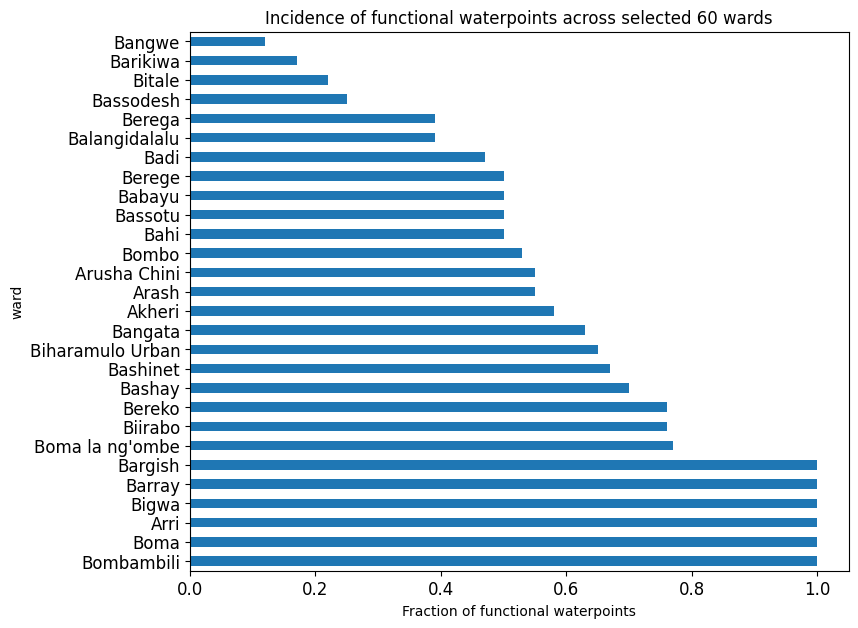

In [283]:
Xy_train.groupby('ward')['status_group'].value_counts(normalize = True).head(60)\
.round(2).sort_values(ascending = False).loc[slice(None), 'functional'].plot.barh(figsize = (8.5, 7))
plt.xlabel('Fraction of functional waterpoints')
plt.title('Incidence of functional waterpoints across selected 60 wards')
plt.show()

ward is potentially a useful feature for the same reasons as lga.

In [284]:
Xy_train.groupby('lga')['district_code'].value_counts()

lga           district_code
Arusha Rural  2.0              1066
Babati        1.0               433
Bagamoyo      1.0               883
              2.0                12
Bahi          6.0               193
                               ... 
Ulanga        4.0               227
              3.0                 2
Urambo        4.0               339
Uyui          3.0               268
              6.0                 2
Name: district_code, Length: 155, dtype: int64

In [285]:
Xy_train.select_dtypes(exclude=['object']).nunique().sort_values(ascending = False)

latitude             42227
longitude            42224
gps_height            2461
population            1017
date_recorded          321
construction_year      214
region_code             27
district_code           17
dtype: int64

In [286]:
Xy_train.lga.unique()

array(['Nzega', 'Mtwara Rural', 'Shinyanga Rural', 'Moshi Rural',
       'Mkinga', 'Meru', 'Kilosa', 'Tunduru', 'Makete', 'Iramba',
       'Urambo', 'Bagamoyo', 'Nkasi', 'Chamwino', 'Arusha Rural',
       'Kibondo', 'Manyoni', 'Kasulu', 'Misenyi', 'Kondoa', 'Hai',
       'Ludewa', 'Sumbawanga Rural', 'Njombe', 'Kilombero', 'Karagwe',
       'Bunda', 'Kwimba', 'Mbeya Rural', 'Igunga', 'Mbulu', 'Tandahimba',
       'Liwale', 'Pangani', 'Kishapu', 'Lushoto', 'Ulanga', 'Biharamulo',
       'Same', 'Kyela', 'Ukerewe', 'Chunya', 'Mvomero', 'Temeke',
       'Namtumbo', 'Morogoro Rural', 'Nachingwea', 'Mufindi', 'Mpwapwa',
       'Bariadi', 'Korogwe', 'Rombo', 'Bukoba Rural', 'Maswa', 'Magu',
       'Kigoma Rural', 'Musoma Rural', 'Sengerema', 'Mwanga', 'Mbinga',
       'Masasi', 'Songea Rural', 'Singida Rural', 'Mkuranga', 'Newala',
       'Sumbawanga Urban', 'Ilala', 'Ngorongoro', 'Muleba',
       'Tabora Urban', 'Chato', 'Siha', 'Mbozi', 'Iringa Rural',
       'Bukombe', 'Rufiji', 'Kibaha',

In [287]:
Xy_train.groupby('region')['region_code'].unique()

region
Arusha                [2, 24]
Dar es Salaam             [7]
Dodoma                    [1]
Iringa                   [11]
Kagera                   [18]
Kigoma                   [16]
Kilimanjaro               [3]
Lindi             [80, 8, 18]
Manyara                  [21]
Mara                     [20]
Mbeya                    [12]
Morogoro                  [5]
Mtwara            [99, 9, 90]
Mwanza                   [19]
Pwani             [6, 60, 40]
Rukwa                    [15]
Ruvuma                   [10]
Shinyanga        [17, 14, 11]
Singida                  [13]
Tabora                   [14]
Tanga                  [4, 5]
Name: region_code, dtype: object

In [288]:
Xy_train.groupby('region')['region_code'].value_counts()

region         region_code
Arusha         2              2279
               24              286
Dar es Salaam  7               314
Dodoma         1              1598
Iringa         11             4700
Kagera         18             2546
Kigoma         16             2495
Kilimanjaro    3              3784
Lindi          80              636
               8               265
               18                6
Manyara        21             1311
Mara           20              683
Mbeya          12             2412
Morogoro       5              2681
Mtwara         90              796
               9               312
               99              264
Mwanza         19             1580
Pwani          6              1410
               60              830
               40                1
Rukwa          15             1568
Ruvuma         10             1914
Shinyanga      17             2660
               14               20
               11                3
Singida        13           

We will assign some new numbers to region, because region_code doesn"t seem very convincing..some regions have multiple region codes and both Tanga and Morogo regions share the code 5.

In [289]:
Xy_train.drop('region_code', axis = 1, inplace = True)

In [290]:
comp_test.drop('region_code', axis = 1, inplace = True)

<center>Converting target to numerical form </center>

Xy_train['status_group'] = Xy_train['status_group']\
.map({'functional' : 1, 'functional needs repair' : 0.5, 'non functional' : 0})

In [291]:
def remap_back_preds(preds) :
    
    """
    Remaps the values of the model predictions, which were trasformed
    to numeric for technical reasons to their original string values.
    
    Parameter
    ---------
    preds : pd.Series.
    
    Returns
    -------
    pd.Series.
    
    Example
    -------
    
    """
    
    preds = preds.map({1: 'functional', 0.5: 'functional needs repair', 0: 'non functional'})
    
    return preds
    

In [292]:
help(category_encoders.wrapper.PolynomialWrapper)

Help on class PolynomialWrapper in module category_encoders.wrapper:

class PolynomialWrapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  PolynomialWrapper(feature_encoder: category_encoders.utils.BaseEncoder)
 |  
 |  Extend supervised encoders to n-class labels, where n >= 2.
 |  
 |  The label can be numerical (e.g.: 0, 1, 2, 3,...,n), string or categorical (pandas.Categorical).
 |  The label is first encoded into n-1 binary columns. Subsequently, the inner supervised encoder
 |  is executed for each binarized label.
 |  
 |  The names of the encoded features are suffixed with underscore and the corresponding class name
 |  (edge scenarios like 'dog'+'cat_frog' vs. 'dog_cat'+'frog' are not currently handled).
 |  
 |  The implementation is experimental and the API may change in the future.
 |  The order of the returned features may change in the future.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |  feature_encoder: Object
 |      an instance of a supervised enc

In [293]:
def mean_target_encoding(train_data, test_data, features, target):
    """
    Perform mean target encoding on specified features for both train and test data using
    category_encoders.TargetEncoder and category_encoders.wrapper.PolynomialWrapper.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training data to perform mean target encoding on.
    test_data : pandas.DataFrame
        The test data to perform mean target encoding on.
    features : list
        A list of features to perform mean target encoding on.
    target : str
        The name of the target variable.
    
    Returns:
    --------
    train_data : pandas.DataFrame
        The training data with new target encoded features.
    test_data : pandas.DataFrame
        The test data with new target encoded features.
    """
    # Create a TargetEncoder object
    te = TargetEncoder(smoothing=10)
    
    # Create a PolynomialWrapper object using the TargetEncoder
    wrapper = PolynomialWrapper(te)
    
    # Fit and transform the features in the training data
    for feat in features:
        try :
            predictor = train_data[feat]
        except KeyError :
            print(f'Feature {feat} is not in the train data')
            break
        try :
            response = train_data[target]
        except KeyError :
            print('Label {} is not in the train data'.format(target))
            break
        # Encode the feature using the TargetEncoder
        train_data[feat + '_encoded'] = te.fit_transform(predictor, train_data[target])
        
        #train_data[feat + '_encoded']
        # Fit and transform the encoded feature using the PolynomialWrapper
        try :
            train_data[feat + '_encoded'] = wrapper.fit_transform(predictor, train_data[target])
        except Exception :
            print('Are there any new values here ?')
            print()
            print('The values of predictor : ')
            print()
            print(predictor.unique())
            print()
            print('The values of target : ')
            print()
            print(train_data[target].unique())
            print()
    
    # Transform the features in the test data
    for feat in features:
        # Encode the feature using the TargetEncoder
        test_data[feat + '_encoded'] = te.transform(test_data[feat])
        
        # Fit and transform the encoded feature using the PolynomialWrapper
        test_data[feat + '_encoded'] = wrapper.fit_transform(test_data[feat + '_encoded'], train_data[target])
    
    return train_data, test_data

In [294]:
def mean_target_enc(train_data, test_data, features, target):
    """
    Perform mean target encoding on specified features for both train and test data using
    category_encoders.TargetEncoder and category_encoders.wrapper.PolynomialWrapper.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training data to perform mean target encoding on.
    test_data : pandas.DataFrame
        The test data to perform mean target encoding on.
    features : list
        A list of features to perform mean target encoding on.
    target : str
        The name of the target variable.
    
    Returns:
    --------
    train_data : pandas.DataFrame
        The training data with new target encoded features.
    test_data : pandas.DataFrame
        The test data with new target encoded features.
    """
    # Create a TargetEncoder object
    te = TargetEncoder(cols=features, smoothing=10)
    
    # Create a PolynomialWrapper object using the TargetEncoder
    wrapper = PolynomialWrapper(te)
    
    # Fit and transform the features in the training data
    train_data_encoded = wrapper.fit_transform(train_data[features], train_data[target])
    
    # Add the encoded features to the training data
    train_data_encoded.columns = [col + '_encoded' for col in features]
    train_data = pd.concat([train_data, train_data_encoded], axis=1)
    
    # Transform the features in the test data
    test_data_encoded = wrapper.transform(test_data[features])
    
    # Add the encoded features to the test data
    test_data_encoded.columns = [col + '_encoded' for col in features]
    test_data = pd.concat([test_data, test_data_encoded], axis=1)
    
    return train_data, test_data


In [295]:
import category_encoders as ce
import pandas as pd

def mean_target(df, features, target, handle_unknown='value', smoothing=1):
    """
    Performs mean target encoding on specified features using TargetEncoder from category_encoders.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input data to perform mean target encoding on.
    features : list
        A list of features to perform mean target encoding on.
    target : str
        The name of the target variable.
    handle_unknown : str, default='value'
        How to handle unknown categories. Options are 'value' to encode as the mean of the target variable, 
        'return_nan' to return NaN for unknown categories, or 'error' to raise an error.
    smoothing : float, default=1
        Smoothing effect to balance categorical average vs global average. Higher values give more weight to 
        the categorical average.

    Returns:
    --------
    encoded_df : pandas.DataFrame
        The encoded data with new target encoded features.
    """
    # Create a PolynomWrapper object for multiclass classification
    poly = ce.wrapper.PolynomialWrapper(ce.TargetEncoder(handle_unknown=handle_unknown, smoothing=smoothing))

    # Fit the encoder on the input data
    poly.fit(df[features], df[target])

    # Transform the input data with the fitted encoder
    encoded_df = poly.transform(df[features])

    # Rename the encoded columns
    encoded_df = encoded_df.add_suffix('_encoded')

    # Merge the encoded features with the original data
    encoded_df = pd.concat([df, encoded_df], axis=1)

    return encoded_df


In [296]:
from category_encoders import BaseNEncoder

def baseN_encoding(df, features, base=2):
    """
    Encode specified features in a DataFrame using BaseN encoding.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to encode.
    features : list
        A list of features to encode.
    base : int, optional (default=2)
        The base of the encoding.
    
    Returns:
    --------
    encoded_df : pandas.DataFrame
        The DataFrame with the specified features encoded using BaseN encoding.
    encoder : BaseNEncoder object
        The BaseNEncoder object used to encode the features.
    """
    frame = df.copy()
    
    # Create a BaseNEncoder object with the specified base
    encoder = BaseNEncoder(base=base, cols=features)
    
    # Encode the specified features in the DataFrame using BaseNEncoder
    encoded_frame = encoder.fit_transform(frame[features])
    
    # Merge the encoded features back into the original DataFrame
    frame_encoded = pd.concat([frame.drop(columns=features), encoded_frame], axis=1)
    
    return frame_encoded, encoder


def base_n_sets_of_features(df, bases, *features) :
    
   # for f in features :
    #    for b in bases :
    pass
            
    
    

In [297]:
Xy_train.sample(n=10).head(10)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66095,4798.4,World Bank,1182.000000,KIM KIM CONSTRUCTION,33.550067,-2.064183,Kwa James Ageni,Lake Victoria,Gatundu,Mara,4.0,Bunda,Nyamhula,250.000000,True,VWC,KARUKEKERE WATER ENVIRONMENT SANITATION SCHEME,True,2012.000000,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,unknown,unknown,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
25664,4855.2,Magadini-makiwaru Water,1348.000000,Magadini-Makiwaru wa,37.009798,-3.027743,Kwa Eliakim Masaki,Internal,Majengo,Kilimanjaro,7.0,Siha,Siha Magharibi,1.000000,True,Water Board,BL Majengo,True,2011.000000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
50536,4696.0,Dwsp,1350.912162,DWSP,33.025100,-3.736251,Kwa Moja Kabeho,Lake Victoria,Imalanguzu,Shinyanga,3.0,Shinyanga Rural,Ilola,435.945946,True,WUG,None,True,2002.614865,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
61748,4700.0,Netherlands,1350.912162,DWE,33.978863,-3.244865,Mwabuki,Internal,Mwang'Holo,Shinyanga,2.0,Maswa,Sukuma,435.945946,True,WUG,None,False,2002.614865,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
18080,4248.8,Danida,1017.744729,Central government,33.712327,-9.572856,Kwa Stewartd Ndile,Lake Nyasa,Kandete,Mbeya,3.0,Kyela,Ngana,279.959674,True,Water authority,Ngana water supplied scheme,True,1996.838584,gravity,gravity,gravity,water authority,commercial,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
53516,4840.2,Kiliwater,1442.000000,Kiliwater,37.608300,-3.237069,Mwangaza,Pangani,Mrau,Kilimanjaro,1.0,Rombo,Keni Mengeni,1.000000,True,Company,Iburieni water supply,True,2003.000000,gravity,gravity,gravity,company,commercial,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
34919,4121.2,Mkinga Distric Coun,670.494376,DWE,38.815503,-4.806874,Mwl Ayubu,Pangani,Tewe,Tanga,8.0,Mkinga,Maramba,30.000000,True,Private operator,Magati gravity water,True,2007.000000,gravity,gravity,gravity,private operator,commercial,never pay,never pay,soft,good,enough,enough,other,other,unknown,communal standpipe,communal standpipe,functional
53990,4129.2,Tado,675.000000,Local technician,38.229436,-4.795629,Kwa Mbumbuli,Pangani,Migombani,Tanga,2.0,Korogwe,Mazinde,150.000000,True,VWC,Mazinde ngua water,False,1994.000000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
23719,4135.2,Government Of Tanzania,1017.744729,Centr,35.334450,-5.396758,Mambu,Internal,Mambu,Dodoma,1.0,Kondoa,Sanzawa,279.959674,True,VWC,Mamb,False,1996.838584,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,salty abandoned,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [298]:
high_cardinality

['wpt_name',
 'subvillage',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'lga',
 'region',
 'extraction_type',
 'extraction_type_group',
 'scheme_management',
 'management']

# preparing holdout set

In [299]:
count_values(df = Xy_test, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,
amount_tsh,4165,70.1
longitude,191,3.2


In [300]:
features_zeros = count_values(df = Xy_test, value = 0).index.tolist()
features_zeros = [f for f in features_zeros if f != 'num_private']

In [301]:
Xy_test.drop('num_private', axis = 1, inplace = True)

In [302]:
for f in features_zeros :
    replace_hidden_nans(Xy_test, 0, f )

In [303]:
double_zeros = count_values(df = Xy_test, value = 0.0).index.tolist()

In [304]:
for d in  double_zeros:
    replace_hidden_nans(Xy_test, 0.0, d )

In [305]:
count_values(df = Xy_test, value = 0.0)

,Count of 0.0,0.0's as % of Total
Feature,,


In [306]:
summarize_df(Xy_test)


Glance at the data : 



,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,NaN,2012-10-09,Rural Water Supply And Sanitat,NaN,DWE,31.985658,-3.596360,Kasela,Lake Tanganyika,Bufanka Centre,Shinyanga,17,5.0,Bukombe,Iyogela,NaN,True,GeoData Consultants Ltd,WUG,NaN,True,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
14530,NaN,2012-11-03,Halmashauri Ya Manispa Tabora,NaN,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,Lake Tanganyika,Maendeleo,Tabora,14,6.0,Tabora Urban,Uyui,NaN,True,GeoData Consultants Ltd,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
62607,10.0,2013-02-25,Siter Fransis,1675.0,DWE,35.488289,-4.242048,Kwa Leosi,Internal,Qatabradiki,Manyara,21,1.0,Babati,Dareda,148.0,True,GeoData Consultants Ltd,Water Board,NaN,True,2008.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
46053,NaN,2011-08-13,Kkkt,NaN,KKKT,33.140828,-9.059386,Jangi,Lake Rukwa,Chawama,Mbeya,12,6.0,Mbozi,Iyula,NaN,False,GeoData Consultants Ltd,VWC,NaN,False,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
47083,50.0,2013-02-08,Wateraid,1109.0,SEMA,34.217077,-4.430529,Mkima,Internal,Mkima,Singida,13,1.0,Iramba,Mtoa,235.0,True,GeoData Consultants Ltd,WUA,Tyeme water supply,True,2011.0,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional



Data types, dimension of the data : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5940 entries, 37098 to 17519
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             1775 non-null   float64
 1   date_recorded          5940 non-null   object 
 2   funder                 5586 non-null   object 
 3   gps_height             3815 non-null   float64
 4   installer              5585 non-null   object 
 5   longitude              5749 non-null   float64
 6   latitude               5940 non-null   float64
 7   wpt_name               5940 non-null   object 
 8   basin                  5940 non-null   object 
 9   subvillage             5897 non-null   object 
 10  region                 5940 non-null   object 
 11  region_code            5940 non-null   int64  
 12  district_code          5939 non-null   float64
 13  lga                    5940 non-null   object 
 14  ward        

None


Missing values across variables : 



amount_tsh               4165
scheme_name              2858
population               2192
construction_year        2134
gps_height               2125
scheme_management         409
installer                 355
funder                    354
public_meeting            340
permit                    302
longitude                 191
subvillage                 43
district_code               1
region                      0
management_group            0
waterpoint_type_group       0
waterpoint_type             0
source_class                0
source_type                 0
source                      0
quantity_group              0
quantity                    0
quality_group               0
water_quality               0
payment_type                0
payment                     0
extraction_type_class       0
management                  0
region_code                 0
extraction_type_group       0
extraction_type             0
latitude                    0
date_recorded               0
wpt_name  


Missing values - % of the data : 


amount_tsh               70.12
scheme_name              48.11
population               36.90
construction_year        35.93
gps_height               35.77
scheme_management         6.89
installer                 5.98
funder                    5.96
public_meeting            5.72
permit                    5.08
longitude                 3.22
subvillage                0.72
district_code             0.02
region                    0.00
management_group          0.00
waterpoint_type_group     0.00
waterpoint_type           0.00
source_class              0.00
source_type               0.00
source                    0.00
quantity_group            0.00
quantity                  0.00
quality_group             0.00
water_quality             0.00
payment_type              0.00
payment                   0.00
extraction_type_class     0.00
management                0.00
region_code               0.00
extraction_type_group     0.00
extraction_type           0.00
latitude                  0.00
date_rec

In [307]:
look_at_variables_values(Xy_test)


Unique values from amount_tsh, limited to 30

8       1000.0
2         50.0
57      6500.0
15      5000.0
7        200.0
36      2400.0
23         6.0
47    138000.0
21      7500.0
9        750.0
5        300.0
12        25.0
45      7200.0
10       100.0
40        33.0
58     20000.0
51     50000.0
25         7.0
14       250.0
39       150.0
32      8000.0
34        70.0
29     12000.0
31      1500.0
48      2800.0
17      3600.0
43     30000.0
0          NaN
28      1200.0
13       500.0
dtype: float64


Unique values from date_recorded, limited to 30

264    2012-12-16
73     2013-02-04
276    2012-12-18
91     2012-10-04
67     2013-03-20
156    2013-03-02
207    2012-11-12
133    2011-03-23
23     2013-03-18
46     2011-02-26
77     2011-03-25
2      2013-02-25
260    2013-05-02
273    2013-06-04
35     2013-05-03
291    2013-07-04
173    2011-06-04
96     2011-02-20
0      2012-10-09
190    2012-10-19
298    2011-01-04
63     2011-08-06
221    2012-10-14
84     2013-03-29
262  

In [308]:
Xy_test.head(1)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,NaN,2012-10-09,Rural Water Supply And Sanitat,NaN,DWE,31.985658,-3.59636,Kasela,Lake Tanganyika,Bufanka Centre,Shinyanga,17,5.0,Bukombe,Iyogela,NaN,True,GeoData Consultants Ltd,WUG,NaN,True,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional


In [309]:
#Xy_test.index = Xy_test['id'].copy()
#Xy_test.drop('id', axis = 1, inplace = True)

In [310]:
summarize_numeric_data(Xy_test, exclude = [c for c in Xy_test.columns if 'code' in c])


The correlation between the variables in the dataset :



,amount_tsh,gps_height,longitude,latitude,population,construction_year
amount_tsh,1.00,0.04,-0.02,-0.04,0.02,0.01
gps_height,0.04,1.00,-0.56,0.29,-0.04,0.01
longitude,-0.02,-0.56,1.00,-0.30,-0.09,0.02
latitude,-0.04,0.29,-0.30,1.00,0.05,0.05
population,0.02,-0.04,-0.09,0.05,1.00,0.04
construction_year,0.01,0.01,0.02,0.05,0.04,1.00



Descriptive statistics of numeric data : 



,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,1775.00,3815.00,5749.00,5940.00,3748.00,3806.00
mean,1105.89,1029.14,35.10,-5.68,291.40,1996.60
std,4457.23,608.56,2.59,2.95,590.47,12.38
min,0.20,-90.00,29.62,-11.56,1.00,1960.00
25%,50.00,417.00,33.28,-8.48,40.00,1987.00
50%,300.00,1169.00,34.98,-5.04,150.00,2000.00
75%,1000.00,1504.00,37.19,-3.32,320.00,2008.00
max,138000.00,2457.00,40.32,-0.00,8000.00,2013.00


In [311]:
count_values(df = Xy_test, value = 0)

,Count of 0,0's as % of Total
Feature,,


In [312]:
Xy_test.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [313]:
get_nans(Xy_test)

Missing values across variables : 



amount_tsh               4165
scheme_name              2858
population               2192
construction_year        2134
gps_height               2125
scheme_management         409
installer                 355
funder                    354
public_meeting            340
permit                    302
longitude                 191
subvillage                 43
district_code               1
region                      0
management_group            0
waterpoint_type_group       0
waterpoint_type             0
source_class                0
source_type                 0
source                      0
quantity_group              0
quantity                    0
quality_group               0
water_quality               0
payment_type                0
payment                     0
extraction_type_class       0
management                  0
region_code                 0
extraction_type_group       0
extraction_type             0
latitude                    0
date_recorded               0
wpt_name  


Missing values - % of the data : 


amount_tsh               70.12
scheme_name              48.11
population               36.90
construction_year        35.93
gps_height               35.77
scheme_management         6.89
installer                 5.98
funder                    5.96
public_meeting            5.72
permit                    5.08
longitude                 3.22
subvillage                0.72
district_code             0.02
region                    0.00
management_group          0.00
waterpoint_type_group     0.00
waterpoint_type           0.00
source_class              0.00
source_type               0.00
source                    0.00
quantity_group            0.00
quantity                  0.00
quality_group             0.00
water_quality             0.00
payment_type              0.00
payment                   0.00
extraction_type_class     0.00
management                0.00
region_code               0.00
extraction_type_group     0.00
extraction_type           0.00
latitude                  0.00
date_rec

In [314]:
Xy_test.drop('amount_tsh', axis = 1, inplace=True)

In [315]:
unnecessary_cols = [c for c in Xy_test.columns if c not in Xy_train.columns]

In [316]:
unnecessary_cols

['region_code', 'recorded_by']

In [317]:
Xy_test.drop(unnecessary_cols, axis = 1, inplace = True)

<center>Imputing scheme_name on private holdout set</center>

In [318]:
Xy_test.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,Rural Water Supply And Sanitat,NaN,DWE,31.985658,-3.596360,Kasela,Lake Tanganyika,Bufanka Centre,Shinyanga,5.0,Bukombe,Iyogela,NaN,True,WUG,NaN,True,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
14530,2012-11-03,Halmashauri Ya Manispa Tabora,NaN,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,Lake Tanganyika,Maendeleo,Tabora,6.0,Tabora Urban,Uyui,NaN,True,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
62607,2013-02-25,Siter Fransis,1675.0,DWE,35.488289,-4.242048,Kwa Leosi,Internal,Qatabradiki,Manyara,1.0,Babati,Dareda,148.0,True,Water Board,NaN,True,2008.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
46053,2011-08-13,Kkkt,NaN,KKKT,33.140828,-9.059386,Jangi,Lake Rukwa,Chawama,Mbeya,6.0,Mbozi,Iyula,NaN,False,VWC,NaN,False,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
47083,2013-02-08,Wateraid,1109.0,SEMA,34.217077,-4.430529,Mkima,Internal,Mkima,Singida,1.0,Iramba,Mtoa,235.0,True,WUA,Tyeme water supply,True,2011.0,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [319]:
value_counts_head(Xy_test, 'region', 'scheme_name')


The value counts in region Arusha : 



scheme_name
Machumba estate pipe line         0.081784
Maambreni gravity water supply    0.044610
Nabaiye pipe line                 0.037175
Saitero olosaita pipe line        0.029740
Endawasu                          0.026022
Name: Arusha, dtype: float64



The value counts in region Dar es Salaam : 



scheme_name
G    0.416667
J    0.333333
M    0.166667
K    0.083333
Name: Dar es Salaam, dtype: float64



The value counts in region Dodoma : 



scheme_name
Cham    0.019417
Chik    0.019417
Kigw    0.019417
Chem    0.014563
Chig    0.014563
Name: Dodoma, dtype: float64



The value counts in region Iringa : 



scheme_name
wanging'ombe supply scheme     0.052995
wanging'ombe water supply s    0.050691
mtwango water supply scheme    0.039171
Roman                          0.032258
imalinyi supply scheme         0.018433
Name: Iringa, dtype: float64

In [320]:
Xy_test['scheme_name'] = Xy_test['scheme_name']\
.str.replace("wanging'ombe water supply s", "wanging'ombe supply scheme")

In [321]:
Xy_train['scheme_name'] = Xy_train['scheme_name']\
.str.replace("wanging'ombe water supply s", "wanging'ombe supply scheme")

In [322]:
comp_test['scheme_name'] = comp_test['scheme_name']\
.str.replace("wanging'ombe water supply s", "wanging'ombe supply scheme")

In [323]:
value_counts_head(Xy_test, 'region', 'scheme_name')


The value counts in region Arusha : 



scheme_name
Machumba estate pipe line         0.081784
Maambreni gravity water supply    0.044610
Nabaiye pipe line                 0.037175
Saitero olosaita pipe line        0.029740
Endawasu                          0.026022
Name: Arusha, dtype: float64



The value counts in region Dar es Salaam : 



scheme_name
G    0.416667
J    0.333333
M    0.166667
K    0.083333
Name: Dar es Salaam, dtype: float64



The value counts in region Dodoma : 



scheme_name
Cham    0.019417
Chik    0.019417
Kigw    0.019417
Chem    0.014563
Chig    0.014563
Name: Dodoma, dtype: float64



The value counts in region Iringa : 



scheme_name
wanging'ombe supply scheme     0.103687
mtwango water supply scheme    0.039171
Roman                          0.032258
imalinyi supply scheme         0.018433
Magang                         0.016129
Name: Iringa, dtype: float64

In [324]:
Xy_test.groupby('region')['scheme_name'].value_counts()

region  scheme_name                   
Arusha  Machumba estate pipe line         22
        Maambreni gravity water supply    12
        Nabaiye pipe line                 10
        Saitero olosaita pipe line         8
        Endawasu                           7
                                          ..
Tanga   TASAF                              1
        TIRDO                              1
        Toronto-estate water               1
        Water Sector Develop               1
        shallow well                       1
Name: scheme_name, Length: 1182, dtype: int64

In [325]:
scheme_bef_nans = Xy_test['scheme_name'].isnull().sum()

In [326]:
print(f'Before imputation with grouped mode we have {scheme_bef_nans} NaNs.')

Before imputation with grouped mode we have 2858 NaNs.


In [327]:
scheme_name_series_iterab = value_counts_head(Xy_test, grouper = 'region', target = 'scheme_name', n = 1000, output = True)

In [328]:
grouped_mode_imputat_categ(Xy_test, 'region', 'scheme_name', output = True)

{'Arusha': 'Machumba estate pipe line',
 'Dar es Salaam': 'G',
 'Dodoma': 'Cham',
 'Iringa': "wanging'ombe supply scheme",
 'Kagera': 'I',
 'Kigoma': 'Mkongoro One',
 'Kilimanjaro': "Uroki-Bomang'ombe water sup",
 'Lindi': 'GEN Borehole Scheme',
 'Manyara': 'Kijiji',
 'Mara': 'Mradi wa maji Komuge',
 'Mbeya': 'K',
 'Morogoro': 'Ki',
 'Mtwara': 'Borehole',
 'Mwanza': 'None',
 'Pwani': 'Chalinze wate',
 'Rukwa': 'Kenswa',
 'Ruvuma': 'DANIDA',
 'Shinyanga': 'None',
 'Singida': 'M',
 'Tabora': 'ADP Simbo',
 'Tanga': 'Handeni Trunk Main(H'}

In [329]:
Xy_test = impute_grouped_categorical_data(Xy_test, 'region', 'scheme_name')

In [330]:
scheme_aft_nans = Xy_test['scheme_name'].isnull().sum()
print()

In [331]:
print(f'After imputation with grouped mode we have {scheme_aft_nans} NaNs.')

After imputation with grouped mode we have 0 NaNs.


In [332]:
'amount_tsh' in Xy_train.columns

False

In [333]:
get_nans(Xy_test)

Missing values across variables : 



population               2192
construction_year        2134
gps_height               2125
scheme_management         409
installer                 355
funder                    354
public_meeting            340
permit                    302
longitude                 191
subvillage                 43
district_code               1
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
quantity_group              0
management_group            0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
payment                     0
date_recorded               0
management                  0
extraction_type_class       0
extraction_type_group       0
extraction_type             0
scheme_name                 0
ward                        0
lga                         0
region                      0
basin                       0
wpt_name  


Missing values - % of the data : 


population               36.90
construction_year        35.93
gps_height               35.77
scheme_management         6.89
installer                 5.98
funder                    5.96
public_meeting            5.72
permit                    5.08
longitude                 3.22
subvillage                0.72
district_code             0.02
payment_type              0.00
water_quality             0.00
quality_group             0.00
quantity                  0.00
source                    0.00
quantity_group            0.00
management_group          0.00
source_type               0.00
source_class              0.00
waterpoint_type           0.00
waterpoint_type_group     0.00
payment                   0.00
date_recorded             0.00
management                0.00
extraction_type_class     0.00
extraction_type_group     0.00
extraction_type           0.00
scheme_name               0.00
ward                      0.00
lga                       0.00
region                    0.00
basin   

<center>Imputing population on private holdout set</center>


In [334]:
Xy_test.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,Rural Water Supply And Sanitat,NaN,DWE,31.985658,-3.596360,Kasela,Lake Tanganyika,Bufanka Centre,Shinyanga,5.0,Bukombe,Iyogela,NaN,True,WUG,None,True,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
14530,2012-11-03,Halmashauri Ya Manispa Tabora,NaN,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,Lake Tanganyika,Maendeleo,Tabora,6.0,Tabora Urban,Uyui,NaN,True,VWC,ADP Simbo,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
62607,2013-02-25,Siter Fransis,1675.0,DWE,35.488289,-4.242048,Kwa Leosi,Internal,Qatabradiki,Manyara,1.0,Babati,Dareda,148.0,True,Water Board,Kijiji,True,2008.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
46053,2011-08-13,Kkkt,NaN,KKKT,33.140828,-9.059386,Jangi,Lake Rukwa,Chawama,Mbeya,6.0,Mbozi,Iyula,NaN,False,VWC,K,False,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
47083,2013-02-08,Wateraid,1109.0,SEMA,34.217077,-4.430529,Mkima,Internal,Mkima,Singida,1.0,Iramba,Mtoa,235.0,True,WUA,Tyeme water supply,True,2011.0,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [335]:
Xy_test.population.describe()

count    3748.000000
mean      291.396745
std       590.469515
min         1.000000
25%        40.000000
50%       150.000000
75%       320.000000
max      8000.000000
Name: population, dtype: float64

In [336]:
Xy_test.groupby('region')['population'].describe().loc[:, ['mean', '50%', 'min', 'max']]

,mean,50%,min,max
region,,,,
Arusha,261.897833,150.0,1.0,6000.0
Dar es Salaam,199.309859,150.0,1.0,1200.0
Dodoma,NaN,NaN,NaN,NaN
Iringa,142.567757,52.5,1.0,1500.0
Kagera,NaN,NaN,NaN,NaN
Kigoma,523.892473,350.0,1.0,5300.0
Kilimanjaro,105.299771,40.0,1.0,6500.0
Lindi,361.118421,274.0,1.0,2350.0
Manyara,329.810127,218.0,1.0,7530.0


In [337]:
Xy_test.groupby('ward')['population'].describe().loc[:, ['mean', '50%', 'min', 'max']].head(60)

,mean,50%,min,max
ward,,,,
Akheri,157.000000,138.0,68.0,350.0
Arash,400.000000,400.0,400.0,400.0
Arri,207.000000,260.0,1.0,360.0
Arusha Chini,4.666667,5.0,1.0,8.0
Badi,NaN,NaN,NaN,NaN
Badugu,NaN,NaN,NaN,NaN
Bahi,NaN,NaN,NaN,NaN
Balangidalalu,1.000000,1.0,1.0,1.0
Baleni,256.666667,120.0,100.0,550.0


We can see that mean and median gets closer on the ward level, so the imputation using mean grouped by ward might work.

In [338]:
help(do_away_nans_via_group_agg)

Help on function do_away_nans_via_group_agg in module __main__:

do_away_nans_via_group_agg(df: pandas.core.frame.DataFrame, grouper_col_a: str, grouper_col_b: str, col_to_impute: str, inspect=False, aggregation: str = 'mean', debug=False)
    Calculates the grouped aggregations with grouper_col_a and grouper_col_b as groupers.
    Next it uses these values to impute missing values in the column col_to_impute.
    Returns new dataframe without missing values in feature col_to_impute.
    
    Parameters
    ----------
    df : pd.DataFrame. DataFrame containing column with nans to impute.
    grouper_col_a : str. The name of the column for whose unique values we want to calculate the aggregation.
    grouper_col_b : str. The name of the column for whose unique values we want to calculate the
                         secondary aggregation.
    col_to_impute: str. The name of the column for which we want to impute missing values with
                        a grouped statistic.
    
    

In [339]:
Xy_test = do_away_nans_via_group_agg(Xy_test, 'ward', 'region', 'population')

In [340]:
Xy_test.population.isnull().sum()

0

In [341]:
Xy_train.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional
17282,4821.8,Jaica,-33.000000,Tasaf,40.322805,-10.456297,Kwa Bakari Ismail,Ruvuma / Southern Coast,Kipingo,Mtwara,1.0,Mtwara Rural,Mahurunga,1000.000000,True,VWC,Tangazo water supply,True,2008.000000,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
44490,4696.0,Rwssp,1350.912162,RWSSP,33.071249,-3.803178,Ujamaa,Lake Victoria,Busubi,Shinyanga,3.0,Shinyanga Rural,Didia,435.945946,True,WUG,None,True,2002.614865,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
67816,4809.8,Ces (gmbh),1088.000000,DWE,37.271938,-3.283501,Kwa Richard Simon Chami,Pangani,Muyuni,Kilimanjaro,4.0,Moshi Rural,Kindi,50.000000,True,Water Board,Lyamungo umbwe water supply,True,2007.000000,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37560,4121.2,Mkinga Distric Coun,670.494376,DWE,38.768891,-4.751313,Shabani Wambua,Pangani,Kibaoni B,Tanga,8.0,Mkinga,Daluni,400.000000,True,VWC,Kigongoi gravity wat,True,2000.000000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,salty,salty,enough,enough,other,other,unknown,communal standpipe,communal standpipe,functional


<center>Imputing construction_year on private holdout set</center>

In [342]:
Xy_test['construction_year'].describe()

count    3806.000000
mean     1996.595638
std        12.383329
min      1960.000000
25%      1987.000000
50%      2000.000000
75%      2008.000000
max      2013.000000
Name: construction_year, dtype: float64

In [343]:
Xy_test = do_away_nans_via_group_agg(Xy_test, 'ward', 'region', 'construction_year')

<center>Imputing gps_height on private holdout set</center>

In [344]:
Xy_test['gps_height'].describe()

count    3815.000000
mean     1029.143381
std       608.556761
min       -90.000000
25%       417.000000
50%      1169.000000
75%      1504.000000
max      2457.000000
Name: gps_height, dtype: float64

In [345]:
Xy_test[Xy_test.gps_height > 0]['gps_height'].describe()

count    3671.000000
mean     1070.255244
std       583.158996
min         1.000000
25%       487.000000
50%      1197.000000
75%      1515.500000
max      2457.000000
Name: gps_height, dtype: float64

In [346]:
Xy_test.groupby('status_group')['gps_height'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,2097.0,1098.271340,613.734776,-90.0,524.00,1236.0,1575.00,2457.0
functional needs repair,254.0,1049.681102,534.215258,-40.0,561.75,1160.5,1429.00,2405.0
non functional,1464.0,926.562842,599.181909,-47.0,332.75,1051.0,1414.25,2324.0


In [347]:
Xy_test[Xy_test.gps_height < 0].groupby('region').size()

region
Dar es Salaam    17
Lindi            20
Mtwara           21
Pwani            70
Tanga            16
dtype: int64

Since google is inclined to say that those regions have positive elevations we will treat those negative elevations as nans.
We will impute them with the mean of the positive values in the same ward.

In [348]:
Xy_test.loc[Xy_test.gps_height < 0, "gps_height"] = np.nan

In [349]:
Xy_test.gps_height.describe()

count    3671.000000
mean     1070.255244
std       583.158996
min         1.000000
25%       487.000000
50%      1197.000000
75%      1515.500000
max      2457.000000
Name: gps_height, dtype: float64

In [350]:
Xy_test = do_away_nans_via_group_agg(Xy_test, 'ward', 'region', 'gps_height')

In [351]:
Xy_test.gps_height.describe()

count    5940.000000
mean     1066.142273
std       496.592460
min         1.000000
25%       847.750000
50%      1070.255244
75%      1351.625000
max      2457.000000
Name: gps_height, dtype: float64

In [352]:
Xy_test.isnull().sum().div(Xy_test.shape[0]).sort_values(ascending = False).head(8)

scheme_management    0.068855
installer            0.059764
funder               0.059596
public_meeting       0.057239
permit               0.050842
longitude            0.032155
subvillage           0.007239
district_code        0.000168
dtype: float64

In [353]:
Xy_test.shape

(5940, 36)

In [354]:
Xy_test = Xy_test.dropna()

In [355]:
Xy_test.isnull().sum().sum()

0

In [356]:
high_cardinality

['wpt_name',
 'subvillage',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'lga',
 'region',
 'extraction_type',
 'extraction_type_group',
 'scheme_management',
 'management']

In [357]:
comp_test.head(2)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,Internal,Magoma,Manyara,3.0,Mbulu,Bashay,321.0,True,Parastatal,Kijiji,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,4809.8,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,Pangani,Kimnyak,Arusha,2.0,Arusha Rural,Kimnyaki,300.0,True,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


# Performing BaseN feature encoding

In [358]:
Xy_train.head(1)

,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,Dwe,1017.744729,WEDECO,33.179596,-4.214966,Hospitali,Internal,Majengo,Tabora,1.0,Nzega,Nzega Urban,279.959674,False,Water authority,Kilimi and uchama dam,True,1996.838584,ksb,submersible,submersible,water authority,commercial,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,dam,dam,surface,dam,dam,functional


<AxesSubplot: xlabel='district_code'>

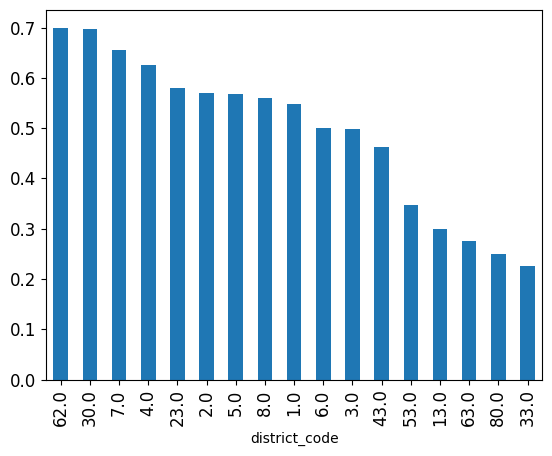

In [359]:
Xy_train.groupby('district_code')['status_group'].value_counts(normalize = True)\
.loc[slice(None), 'functional'].sort_values(ascending = False).plot.bar()

In [360]:
def one_hot_encoder(df_column : pd.Series, what_is_one) -> list:
    """
    Returns a list of 1's and 0's indicating whether a feature's 
    value is equal to the particular unique value of a feature or not.

    Parameters
    ----------
    df_column : pd.Series. The column on which we want to perform OHE.
    what_is_one : can be of any type. This is the unique value of a feature
                  which will became the new feature after OHE.

    Example
    -------

    """
    output = [1 if row == what_is_one else 0 for row in df_column]

    return output

def one_hot_caller(df_column : pd.Series, set_of_categories) -> dict:
    
    cat_columns_encoded = {thing : one_hot_encoder(df_column,thing) for thing in set_of_categories}
    
    return cat_columns_encoded

def get_distinct_values_from_column(df_column):
    
    distinct_df_column = {row for row in df_column}
    
    return distinct_df_column

def call_one_hot_caller(df_column):
    
    distinct = get_distinct_values_from_column(df_column = df_column)
    
    return one_hot_caller(df_column, distinct)
        
def encode_and_implement_in_df(df, df_column):
    # poprawic wydajnosciowo
    
    for key, value in call_one_hot_caller(df_column).items():
        
        df[str(key)] = value
         
    return df

def encode_implement_all(df, list_of_columns_to_encode):
    
    '''
    The functions takes as arguments the df containing the columns to encode 
    and a list of df columns (pandas series) to encode and returns
    the DataFrame with categorical attributes replaced by one's and zero's
    via so called One Hot Encoding technique.

    Parameters
    ----------
    df : pandas DataFrame. 
         The dataset for which you want to encode categorical values
         as zeros or ones.
    
    list_of_columns_to_encode : list of pandas Series'es.
    For example [df['manufacturer'], df['condition']].

    Returns
    -------
    pandas DataFrame, with categoricals replaced by 1's and 0's.

    Examples
    ---------
    >>> encode_implement_all(x, [x['manufacturer'], x['condition']])

        kia  hyundai  mini  acura  audi  ...  salvage  like new  fair  good  excellent
    0    0        0     0      0     0  ...        0         0     0     1          0
    1    0        0     0      0     0  ...        0         0     0     1          0
    2    0        0     0      0     0  ...        0         0     0     1          0
    3    0        0     0      0     0  ...        0         0     0     1          0
    4    0        0     0      0     0  ...        0         0     0     1          0

    '''
    
    list_of_columns_to_encode = [l if isinstance(l, pd.Series) else df[l] for l in list_of_columns_to_encode]
    
    for column in list_of_columns_to_encode:
        
        encode_and_implement_in_df(df, column)
    
    for i in list_of_columns_to_encode:
        try :
            
            del df[str(i.name)]
        
        except Exception:
            pass
    
    return df

In [361]:
Xy_train = encode_implement_all(Xy_train, moderate_card)
#Xy_train, encoder_three = baseN_encoding(Xy_train, moderate_card, base = 3)

In [362]:
Xy_train, encoder_eight = baseN_encoding(Xy_train, high_cardinality, base = 8)

In [363]:
def transform_baseN_test(test_df, features : list, encoder) :
    
    """
    Parameters
    ----------
    features : list.
    encoder : category_encoders.basen.BaseNEncoder.
    """
    
    assert isinstance(test_df, pd.DataFrame),\
    "You are not passing in a dataframe, perhaps you have overwritten your df with sth else"
    
    test_encoded = encoder.transform(test_df[features])
    test_encoded = pd.concat([test_df.drop(columns=features), test_encoded], axis=1)
    
    return test_encoded

In [364]:
Xy_train.shape

(42260, 108)

In [365]:
Xy_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,status_group,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,on failure,monthly,per bucket,communal standpipe multiple,hand pump,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,functional,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1


In [366]:
print('The type of comp_test is {}'.format(type(comp_test)))

The type of comp_test is <class 'pandas.core.frame.DataFrame'>


In [367]:
#comp_test = transform_baseN_test(comp_test, moderate_card, encoder_three)
comp_test = encode_implement_all(comp_test, moderate_card)
comp_test = transform_baseN_test(comp_test, high_cardinality, encoder_eight)

In [368]:
#Xy_test = transform_baseN_test(Xy_test, moderate_card, encoder_three)
Xy_test = encode_implement_all(Xy_test, moderate_card)
Xy_test = transform_baseN_test(Xy_test, high_cardinality, encoder_eight)

In [369]:
Xy_test.head(3)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,status_group,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,monthly,on failure,per bucket,hand pump,communal standpipe multiple,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,1351.625000,31.985658,-3.596360,5.0,358.187500,2002.687500,non functional,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3
14530,2012-11-03,1070.255244,32.832815,-4.944937,6.0,291.396745,1996.595638,functional,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,2,6,1,2,0,3,4,0,3,0,3,1,4,3,2,0,3,0,7,0,6,0,6,6,0,1,0,6,0,1,1,1,1,0,0,2,0,2
62607,2013-02-25,1675.000000,35.488289,-4.242048,1.0,148.000000,2008.000000,functional,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,5,4,3,0,0,3,1,1,0,7,0,7,0,0,0,4,0,0,0,0,1,5,2,2,3,0,4,0,3,0,4,0,4


In [370]:
comp_test.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,monthly,on failure,per bucket,hand pump,communal standpipe multiple,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,3,0,3,1,1,0,7,4,0,0,2,5,6,0,2,5,3,0,3,7,2,3,0,3,0,2,0,7,0,6
51630,4809.8,1569.0,36.656709,-3.309214,2.0,300.0,2000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0,5,6,6,0,0,0,4,0,0,0,6,0,1,7,0,6,0,4,0,3,0,2,0,2


In [371]:
comp_test.shape

(14850, 107)

In [372]:
comp_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,monthly,on failure,per bucket,hand pump,communal standpipe multiple,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,3,0,3,1,1,0,7,4,0,0,2,5,6,0,2,5,3,0,3,7,2,3,0,3,0,2,0,7,0,6


Setting the index as index and removing it from columns :

for data in [Xy_train, comp_test] :
    data.index = data['id']
    data.drop('id', axis = 1, inplace = True)

Separating X and y on train data :

In [373]:
Xy_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,status_group,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,on failure,monthly,per bucket,communal standpipe multiple,hand pump,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,functional,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1


In [374]:
y_train = Xy_train['status_group'].copy()
X_train = Xy_train.drop('status_group', axis = 1)

In [375]:
y_test = Xy_test['status_group'].copy()
X_test = Xy_test.drop('status_group', axis = 1)

In [376]:
#X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Baseline model

In [377]:
def fit_and_evaluate(X_train, X_test, y_train, y_test, verbose = 0,\
                     ignore_warnings = True, custom_metric = None, n_samples = None) -> pd.DataFrame :

    
    # in order to be able perform model's training on smaller amount of data
    # if n_samples is specified, either because we want to test sth or the dataset is too large
    if n_samples is not None:
        X_train, y_train = resample(X_train, y_train, n_samples=n_samples, random_state=42)
    
    # so as to be able to later include the info about the number of
    # observations in the name of the file with model's statistics 
    n_obs = len(X_train)
    
    # Instantiate LazyClassifier with default parameters
    clf = LazyClassifier(verbose=verbose, ignore_warnings=ignore_warnings, custom_metric=custom_metric)
    
    # to train and evaluate the models
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    
    # to be able to include current date and time in the file name
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    
    # naming the models so as to be able to easily track different versions
    filename = f'model_results_{timestamp}_{n_obs}_observations.csv'
    
    # in order to save baseline models statistics
    models.to_csv(filename)
    
    return models

In [378]:
#fit_and_evaluate(X_train_small, X_test_small, y_train_small, y_test_small)

In [379]:
X_train.head()

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,on failure,monthly,per bucket,communal standpipe multiple,hand pump,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
17282,4821.8,-33.000000,40.322805,-10.456297,1.0,1000.000000,2008.000000,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,2,0,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0,2,0,1,0,2,0,2
44490,4696.0,1350.912162,33.071249,-3.803178,3.0,435.945946,2002.614865,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,3,0,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,3,0,3,0,3,0,2,0,3,0,3
67816,4809.8,1088.000000,37.271938,-3.283501,4.0,50.000000,2007.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,4,0,0,0,0,4,0,0,0,4,0,0,0,4,0,0,0,4,0,0,0,4,0,0,4,0,4,0,4,0,3,0,4,0,4
37560,4121.2,670.494376,38.768891,-4.751313,8.0,400.000000,2000.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,5,0,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,4,0,0,0,5,0,0,5,0,5,0,4,0,3,0,2,0,2


In [380]:
num_vars = """date_recorded	gps_height	longitude	latitude	district_code	population	construction_year""".split()
num_vars

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year']

In [381]:
categoricals = [c for c in X_train.columns if c not in num_vars and not str(c)[-1].isdigit()]

In [382]:
categoricals

['spring',
 'dam',
 'hand dtw',
 'rainwater harvesting',
 'other',
 'lake',
 'shallow well',
 'unknown',
 'river',
 'machine dbh',
 'Lake Victoria',
 'Ruvuma / Southern Coast',
 'Internal',
 'Lake Tanganyika',
 'Wami / Ruvu',
 'Lake Nyasa',
 'Rufiji',
 'Lake Rukwa',
 'Pangani',
 'salty',
 'coloured',
 'fluoride',
 'milky',
 'salty abandoned',
 'fluoride abandoned',
 'soft',
 'river/lake',
 'borehole',
 'never pay',
 'annually',
 'on failure',
 'monthly',
 'per bucket',
 'communal standpipe multiple',
 'hand pump',
 'improved spring',
 'communal standpipe',
 'cattle trough',
 'wind-powered',
 'handpump',
 'motorpump',
 'rope pump',
 'gravity',
 'submersible',
 'pay when scheme fails',
 'pay annually',
 'pay per bucket',
 'pay monthly',
 'colored',
 'good',
 'dry',
 'insufficient',
 'enough',
 'seasonal',
 'parastatal',
 'commercial',
 'user-group',
 'surface',
 'groundwater',
 'False',
 'True']

In [383]:
[c for c in categoricals if c not in X_train.columns]

[]

In [384]:
cat_df = X_train[categoricals]

In [385]:
cat_df.shape

(42260, 61)

In [386]:
X_train.shape

(42260, 107)

In [387]:
X_train.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,dam,hand dtw,rainwater harvesting,other,lake,shallow well,unknown,river,machine dbh,Lake Victoria,Ruvuma / Southern Coast,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Rufiji,Lake Rukwa,Pangani,salty,coloured,fluoride,milky,salty abandoned,fluoride abandoned,soft,river/lake,borehole,never pay,annually,on failure,monthly,per bucket,communal standpipe multiple,hand pump,improved spring,communal standpipe,cattle trough,wind-powered,handpump,motorpump,rope pump,gravity,submersible,pay when scheme fails,pay annually,pay per bucket,pay monthly,colored,good,dry,insufficient,enough,seasonal,parastatal,commercial,user-group,surface,groundwater,False,True,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
17282,4821.8,-33.000000,40.322805,-10.456297,1.0,1000.000000,2008.000000,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,2,0,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0,2,0,1,0,2,0,2


In [388]:
ylabels = y_train.copy()

<center>Selecting significant categorical features</center>

In [389]:
def chi_filter_features(cat_df, ylabels, k = 40) :
    
    frame = cat_df.copy()
    chi2_selector = SelectKBest(chi2, k = k)
    best_binary = chi2_selector.fit(frame, ylabels)
    kbest_binary = cat_df.columns[best_binary.get_support()]
    cols_exclude = [b for b in frame.columns if b not in kbest_binary]
    frame = frame[[c for c in frame.columns if c not in cols_exclude]]
    
    return 'Exclude those :', cols_exclude

In [390]:
variables_exclude = chi_filter_features(cat_df, ylabels, 30)[1]

In [391]:
X_train = X_train[[c for c in X_train.columns if c not in variables_exclude]]
X_test = X_test[[c for c in X_test.columns if c not in variables_exclude]]
comp_test = comp_test[[c for c in comp_test.columns if c not in variables_exclude]]

In [392]:
X_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1


In [393]:
X_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,1351.625,31.985658,-3.59636,5.0,358.1875,2002.6875,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3


In [394]:
X_test.shape[1]

76

In [395]:
[c for c in X_train.columns if c not in X_test.columns]

[]

In [396]:
X_train.shape[1]

76

In [397]:
comp_test.shape[1]

76

In [398]:
comp_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,3,0,3,1,1,0,7,4,0,0,2,5,6,0,2,5,3,0,3,7,2,3,0,3,0,2,0,7,0,6


In [399]:
for c in X_test.columns :
    if c not in X_train.columns :
        del X_test[c]
        
for c in comp_test.columns :
    if c not in comp_test.columns :
        del comp_test[c]

In [400]:
len(X_train.columns) == len(X_test.columns) == len(comp_test.columns)

True

In [401]:
len(X_train.columns) == len(X_test.columns)

True

In [402]:
X_test.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,1351.625000,31.985658,-3.596360,5.0,358.187500,2002.687500,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3
14530,2012-11-03,1070.255244,32.832815,-4.944937,6.0,291.396745,1996.595638,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,6,1,2,0,3,4,0,3,0,3,1,4,3,2,0,3,0,7,0,6,0,6,6,0,1,0,6,0,1,1,1,1,0,0,2,0,2


# feature engineering on private holdout data

In [403]:
X_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,2012-10-09,1351.625,31.985658,-3.59636,5.0,358.1875,2002.6875,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3


In [404]:
X_test['date_recorded'] = X_test['date_recorded'].apply(convert_dates_to_days)

In [405]:
X_test.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,4693.0,1351.625000,31.985658,-3.596360,5.0,358.187500,2002.687500,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3
14530,4717.4,1070.255244,32.832815,-4.944937,6.0,291.396745,1996.595638,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,6,1,2,0,3,4,0,3,0,3,1,4,3,2,0,3,0,7,0,6,0,6,6,0,1,0,6,0,1,1,1,1,0,0,2,0,2


In [406]:
#X_test[[ 'wpt_name']].nunique().sort_values(ascending=False)

In [407]:
features_remove = []
#'wpt_name'

In [408]:
X_train, X_test, comp_test = X_train[[c for c in X_train.columns if c not in features_remove]],\
X_test[[c for c in X_test.columns if c not in features_remove]], comp_test[[c for c in comp_test.columns\
                                                                         if c not in features_remove]]

In [409]:
use_cols = [c for c in X_test.columns if c in  X_train.columns]
X_test = X_test[use_cols]

In [410]:
len(X_test.columns)

76

In [411]:
len( X_train.columns)

76

In [412]:
X_train.head(3)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
17282,4821.8,-33.000000,40.322805,-10.456297,1.0,1000.000000,2008.000000,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0,2,0,1,0,2,0,2
44490,4696.0,1350.912162,33.071249,-3.803178,3.0,435.945946,2002.614865,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,3,0,3,0,3,0,2,0,3,0,3


In [413]:
comp_test.head(3)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,3,0,3,1,1,0,7,4,0,0,2,5,6,0,2,5,3,0,3,7,2,3,0,3,0,2,0,7,0,6
51630,4809.8,1569.0,36.656709,-3.309214,2.0,300.0,2000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0,5,6,6,0,0,0,4,0,0,0,6,0,1,7,0,6,0,4,0,3,0,2,0,2
17168,4806.8,1567.0,34.767863,-5.004344,2.0,500.0,2010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,2,0,7,7,1,2,0,3,0,2,0,2,0,2


In [414]:
X_test.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,4693.0,1351.625000,31.985658,-3.596360,5.0,358.187500,2002.687500,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,6,6,4,3,0,3,3,5,0,0,0,3,0,3,2,3,0,0,0,4,0,1,3,2,1,1,3,0,3,0,3,0,2,0,3,0,3
14530,4717.4,1070.255244,32.832815,-4.944937,6.0,291.396745,1996.595638,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,6,1,2,0,3,4,0,3,0,3,1,4,3,2,0,3,0,7,0,6,0,6,6,0,1,0,6,0,1,1,1,1,0,0,2,0,2


In [415]:
X_test.describe().round(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,hand pump,communal standpipe multiple,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
count,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.0,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00,4677.00
mean,4486.35,1073.13,35.14,-5.85,5.83,296.87,1996.83,0.32,0.01,0.25,0.18,0.18,0.07,0.12,0.07,0.13,0.05,0.08,0.19,0.19,0.42,0.08,0.16,0.16,0.27,0.11,0.61,0.26,0.06,0.49,0.08,0.16,0.16,0.1,0.60,0.23,0.08,0.39,0.78,1.03,1.19,1.38,0.61,2.19,2.65,2.72,2.96,0.52,2.08,2.67,3.47,0.77,3.13,3.44,3.51,0.07,0.97,2.29,3.40,0.04,0.91,2.57,3.72,0.29,2.89,3.45,0.78,3.54,0.17,3.52,0.11,2.97,0.04,2.44,0.08,2.31
std,335.71,504.93,2.68,2.73,9.73,487.73,10.51,0.47,0.10,0.43,0.38,0.38,0.26,0.32,0.26,0.34,0.22,0.26,0.39,0.40,0.49,0.26,0.37,0.37,0.44,0.32,0.49,0.44,0.23,0.50,0.26,0.37,0.37,0.3,0.49,0.42,0.28,1.13,1.75,2.01,1.94,2.22,0.91,2.32,2.45,2.47,2.52,0.94,2.24,2.29,2.13,0.85,2.26,2.34,2.29,0.30,1.63,2.38,1.99,0.23,1.64,2.41,2.33,0.45,2.16,2.37,0.72,2.16,0.38,1.55,0.32,1.57,0.19,1.23,0.27,1.03
min,1552.20,1.00,29.62,-11.56,1.00,1.00,1960.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4133.20,828.00,33.19,-8.32,2.00,80.00,1994.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,1.00,1.00,0.00,2.00,0.00,3.00,0.00,2.00,0.00,2.00,0.00,2.00
50%,4326.00,1070.26,35.32,-5.13,3.00,270.00,1996.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,3.00,0.00,1.00,2.00,3.00,1.00,3.00,3.00,4.00,0.00,0.00,2.00,4.00,0.00,0.00,2.00,4.00,0.00,3.00,4.00,1.00,3.00,0.00,4.00,0.00,3.00,0.00,2.00,0.00,2.00
75%,4813.80,1351.62,37.37,-3.38,5.00,350.00,2005.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,1.00,4.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,5.00,6.00,5.00,0.00,1.00,4.00,4.00,0.00,1.00,5.00,6.00,1.00,5.00,6.00,1.00,5.00,0.00,4.00,0.00,3.00,0.00,2.00,0.00,2.00
max,5112.80,2457.00,40.32,-1.00,80.00,8000.00,2013.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1

In [416]:
X_test.shape

(4677, 76)

In [417]:
comp_test.shape

(14850, 76)

In [418]:
X_train.shape

(42260, 76)

In [419]:
numeric_features = """date_recorded	gps_height	longitude	latitude	district_code	population	construction_year""".split()
numeric_features

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year']

In [420]:
X_experim = X_train[['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'construction_year']].copy()

In [421]:
important_features = numeric_features + ['dry', 'enough', 'extraction_type_1', 'extraction_type_group_1',\
                      'never pay', 'lga_1', 'funder_2', 'funder_3',\
                                         'installer_2', 'installer_3', 'communal standpipe multiple']
#X_train = X_train[important_features]
#X_test = X_test[important_features]
X_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,subvillage_0,subvillage_1,subvillage_2,subvillage_3,subvillage_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1


In [422]:
basen_features = [c for c in X_train.columns if c[-1].isdigit()]

In [423]:
basen_features[ : 5]

['wpt_name_0', 'wpt_name_1', 'wpt_name_2', 'wpt_name_3', 'wpt_name_4']

In [424]:
no_basen = [c for c in X_train.columns if c not in basen_features]
no_basen

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year',
 'spring',
 'lake',
 'shallow well',
 'river',
 'machine dbh',
 'Ruvuma / Southern Coast',
 'Lake Tanganyika',
 'Lake Nyasa',
 'Rufiji',
 'Lake Rukwa',
 'salty',
 'river/lake',
 'borehole',
 'never pay',
 'annually',
 'monthly',
 'per bucket',
 'communal standpipe multiple',
 'hand pump',
 'communal standpipe',
 'handpump',
 'motorpump',
 'gravity',
 'pay annually',
 'pay per bucket',
 'pay monthly',
 'dry',
 'enough',
 'surface',
 'False']

In [425]:
rf = RandomForestClassifier(min_samples_split = 20, min_samples_leaf = 50)
rf.fit(X_train[no_basen], y_train)

RandomForestClassifier(min_samples_leaf=50, min_samples_split=20)

In [491]:
parapredictions = cls.predict(X_train[no_basen])

In [492]:
acc = accuracy_score(y_train, parapredictions)

In [493]:
print(f'The accuracy on the train set is {acc}')

The accuracy on the train set is 0.8797681022243256


In [429]:
cross_scores = cross_val_score(rf, X_train[no_basen], y_train, cv=5, n_jobs = -1)

In [430]:
cross_scores

array([0.76041174, 0.76076668, 0.76183152, 0.76490771, 0.76112163])

In [494]:
test_preds = cls.predict(X_test[X_train[no_basen].columns.tolist()])

In [495]:
test_acc = accuracy_score(y_test, test_preds)

In [496]:
print(f'The accuracy on the test set is {test_acc}')

The accuracy on the test set is 0.8107761385503528


In [434]:
X_train = X_train[no_basen]
X_test = X_test[X_train.columns.tolist()]
comp_test = comp_test[X_train.columns.tolist()]

In [435]:
#comp_test = comp_test[important_features]

In [436]:
comp_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [437]:
def feature_importance(model, index, target_variable, fig_size_tup = (10,6), n = 15,\
                       full_table = False, permutation = False, X_train = None, y_train = None):
    """
    Returns the feature importances in the form of a table or a bar chart.

    Parameters
    ----------
    model : fitted sklearn Decision Tree or Random Forest model.
    index : list of strings. The features the model was trained with.

    target_variable : str. The name of the target variable to be included
                            in the title of the plot.
                            Relevant only if full_table = False.

    fig_size_tup : tuple. The size of the plot. 
                     Relevant only if full_table = False.

    n : int. Number of variables to to display on feature importances plot.
               Relevant only if full_table = False.

    full_table : bool. Defaults to False.

    Returns
    -------
    None if full_table = False. (Displays the plot).
    pandas DataFrame if full_table = True.
    """

    impurity_imp = sorted([*zip(X_train.columns.tolist(), model.feature_importances_.tolist())],\
           key = lambda tup : tup[1], reverse = True)

    impurity_imp_diction = {tup[0] : tup[1] for tup in impurity_imp}
    
    
    importance_df = pd.DataFrame()
    importance_df['feature'] = X_train.columns.tolist()
    
    if permutation :
        perm_imp = permutation_importance(rf, X_train, y_train, scoring='accuracy')
        perm_imp_iterab = perm_imp['importances_mean'].tolist()
        perm_tups = sorted([*zip(X_train.columns.tolist(), perm_imp_iterab)], key = lambda tup : tup[1], reverse = True)
        perm_diction = {tup[0] : tup[1] for tup in perm_tups}
        
        importance_df['impurity_importance'] = [impurity_imp_diction[f] for f in importance_df['feature']]
        importance_df['permutation_importance'] = [perm_diction[f] for f in importance_df['feature']]
    else :
        importance_df['importance'] = [impurity_imp_diction[f] for f in importance_df['feature']]
    

    if full_table:
        return importance_df

    
    importance_df.sort_values(by = ['impurity_importance', 'permutation_importance'],\
                          ascending = False).head(n).plot(x = 'feature', figsize = fig_size_tup, kind = 'bar')

    plt.title('Importances of different variables affecting {}'.format(target_variable))
    plt.ylabel('Importance')
    plt.grid(True)
    plt.show()

In [438]:
#perm_imp = permutation_importance(rf, X_train, y_train, scoring='accuracy')

In [439]:
#perm_imp

perm_imp_iterab = perm_imp['importances_mean'].tolist()
perm_tups = sorted([*zip(X_train.columns.tolist(), perm_imp_iterab)], key = lambda tup : tup[1], reverse = True)
perm_diction = {tup[0] : tup[1] for tup in perm_tups}
perm_diction

importance_df = pd.DataFrame(index = X_train.columns.tolist())
importance_df['permutation_importance'] = [perm_diction[f] for f in importance_df.index]
importance_df.sort_values(by = 'permutation_importance', ascending = False).head(20).plot.bar()

In [440]:
#feature_importance(rf, X_train.columns.tolist(), 'status_group', True, X_train = X_train, y_train = y_train)

In [441]:
#feature_importance(rf, X_train.columns.tolist(), 'status_group')

In [442]:
important_features

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year',
 'dry',
 'enough',
 'extraction_type_1',
 'extraction_type_group_1',
 'never pay',
 'lga_1',
 'funder_2',
 'funder_3',
 'installer_2',
 'installer_3',
 'communal standpipe multiple']

feature_importance(rf, X_train.columns.tolist(), 'status_group', full_table=True)\
[feature_importance(rf, X_train.columns.tolist(), 'status_group', full_table=True) > 0.01].dropna().shape

In [443]:
#X_train.to_csv('ready_train_set_62features.csv')
#X_test.to_csv('ready_test_set_62features.csv')

In [444]:
#y_train.to_csv('train_labels.csv')
#y_test.to_csv('test_labels.csv')

In [445]:
X_train.head(2)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
17282,4821.8,-33.000000,40.322805,-10.456297,1.0,1000.000000,2008.000000,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0


In [446]:
#X_train.nunique()[(X_train.nunique() > 2) & (X_train.nunique() < 10)]

In [447]:
X_train.shape

(42260, 37)

In [448]:
X_test.shape

(4677, 37)

In [449]:
comp_test.shape

(14850, 37)

In [450]:
include = {
    'feature_preprocessor': [
        'pca',
        'no_preprocessing',
        'select_percentile_classification'
    ],
    'classifier': [
        'random_forest',
        'extra_trees',
        'adaboost',
        'gradient_boosting'
    ]
}
# 

In [451]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 42000,\
                                                       ensemble_kwargs = {'ensemble_size': 1},
                                                       n_jobs = - 1,\
                                                      resampling_strategy="cv",\
                                                      resampling_strategy_arguments={"folds": 5},\
                                                       memory_limit = 7168)

In [452]:
cls

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 1}, memory_limit=7168,
                      n_jobs=-1, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5},
                      time_left_for_this_task=42000)

In [453]:
X_train.head(3)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
17282,4821.8,-33.000000,40.322805,-10.456297,1.0,1000.000000,2008.000000,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0
44490,4696.0,1350.912162,33.071249,-3.803178,3.0,435.945946,2002.614865,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [454]:
X_train.isnull().sum().sum()

0

In [455]:
X_train.dtypes

date_recorded                  float64
gps_height                     float64
longitude                      float64
latitude                       float64
district_code                  float64
population                     float64
construction_year              float64
spring                           int64
lake                             int64
shallow well                     int64
river                            int64
machine dbh                      int64
Ruvuma / Southern Coast          int64
Lake Tanganyika                  int64
Lake Nyasa                       int64
Rufiji                           int64
Lake Rukwa                       int64
salty                            int64
river/lake                       int64
borehole                         int64
never pay                        int64
annually                         int64
monthly                          int64
per bucket                       int64
communal standpipe multiple      int64
hand pump                

In [456]:
X_train.columns

Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'district_code',
       'population', 'construction_year', 'spring', 'lake', 'shallow well',
       'river', 'machine dbh', 'Ruvuma / Southern Coast', 'Lake Tanganyika',
       'Lake Nyasa', 'Rufiji', 'Lake Rukwa', 'salty', 'river/lake', 'borehole',
       'never pay', 'annually', 'monthly', 'per bucket',
       'communal standpipe multiple', 'hand pump', 'communal standpipe',
       'handpump', 'motorpump', 'gravity', 'pay annually', 'pay per bucket',
       'pay monthly', 'dry', 'enough', 'surface', 'False'],
      dtype='object')

In [457]:
X_train.isnull().sum()

date_recorded                  0
gps_height                     0
longitude                      0
latitude                       0
district_code                  0
population                     0
construction_year              0
spring                         0
lake                           0
shallow well                   0
river                          0
machine dbh                    0
Ruvuma / Southern Coast        0
Lake Tanganyika                0
Lake Nyasa                     0
Rufiji                         0
Lake Rukwa                     0
salty                          0
river/lake                     0
borehole                       0
never pay                      0
annually                       0
monthly                        0
per bucket                     0
communal standpipe multiple    0
hand pump                      0
communal standpipe             0
handpump                       0
motorpump                      0
gravity                        0
pay annual

In [458]:
y_train.isnull().sum()

0

In [459]:
y_train.dtype

dtype('O')

In [460]:
X_train.columns

Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'district_code',
       'population', 'construction_year', 'spring', 'lake', 'shallow well',
       'river', 'machine dbh', 'Ruvuma / Southern Coast', 'Lake Tanganyika',
       'Lake Nyasa', 'Rufiji', 'Lake Rukwa', 'salty', 'river/lake', 'borehole',
       'never pay', 'annually', 'monthly', 'per bucket',
       'communal standpipe multiple', 'hand pump', 'communal standpipe',
       'handpump', 'motorpump', 'gravity', 'pay annually', 'pay per bucket',
       'pay monthly', 'dry', 'enough', 'surface', 'False'],
      dtype='object')

In [461]:
X_train.shape

(42260, 37)

In [462]:
#X_train.index = [*range(len(X_train))]

In [463]:
y_train.head()

id
31080        functional
17282    non functional
44490    non functional
67816        functional
37560        functional
Name: status_group, dtype: object

In [464]:
#y_train.index = [*range(len(y_train))]

In [465]:
comp_test.head(3)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
51630,4809.8,1569.0,36.656709,-3.309214,2.0,300.0,2000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
17168,4806.8,1567.0,34.767863,-5.004344,2.0,500.0,2010.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [466]:
X_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1


for data in X_train, X_test, comp_test :
    data = data.rename(columns = {False : 'False', True : 'True'})

In [467]:
cls.fit(X_train, y_train)

[WARNING] [2023-05-15 12:32:27,670:Client-AutoML(1):c66382d9-f30b-11ed-a57b-00155d131702] Capping the per_run_time_limit to 20999.0 to have time for a least 2 models in each process.


IOStream.flush timed out


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 1}, memory_limit=7168,
                      n_jobs=-1, per_run_time_limit=33600,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5},
                      time_left_for_this_task=42000)

In [468]:
cls.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
72,1,1.0,random_forest,0.190842,2198.510465


In [469]:
model_type = cls.leaderboard().type.values[0]
model_cost = round(cls.leaderboard().cost.values[0], 3)

In [470]:
time = datetime.now().strftime("%d-%m-%Y--%H-%M")

In [471]:
dump(cls, '37 features only OHE mem 7G auto_sklearn_{}_model_cost_{}_ensemble_off_700min_5folds_{}.joblib'.format(model_type, model_cost, time))

['37 features only OHE mem 7G auto_sklearn_random_forest_model_cost_0.191_ensemble_off_700min_5folds_16-05-2023--00-12.joblib']

In [472]:
cls.sprint_statistics()

'auto-sklearn results:\n  Dataset name: c66382d9-f30b-11ed-a57b-00155d131702\n  Metric: accuracy\n  Best validation score: 0.809158\n  Number of target algorithm runs: 145\n  Number of successful target algorithm runs: 124\n  Number of crashed target algorithm runs: 6\n  Number of target algorithms that exceeded the time limit: 14\n  Number of target algorithms that exceeded the memory limit: 1\n'

In [473]:
comp_test.isnull().sum().sort_values(ascending = False)

district_code                  4
date_recorded                  0
motorpump                      0
annually                       0
monthly                        0
per bucket                     0
communal standpipe multiple    0
hand pump                      0
communal standpipe             0
handpump                       0
gravity                        0
borehole                       0
pay annually                   0
pay per bucket                 0
pay monthly                    0
dry                            0
enough                         0
surface                        0
never pay                      0
river/lake                     0
gps_height                     0
shallow well                   0
longitude                      0
latitude                       0
population                     0
construction_year              0
spring                         0
lake                           0
river                          0
salty                          0
machine db

In [474]:
comp_test['district_code'].value_counts(normalize = True).sort_values(ascending = False).head(3)

1.0    0.208541
2.0    0.185639
3.0    0.169945
Name: district_code, dtype: float64

In [475]:
comp_test['district_code'] = comp_test['district_code'].fillna(1.00)

In [476]:
comp_test.isnull().sum().sum()

0

In [477]:
[c for c in X_train.columns if c not in comp_test.columns]

[]

In [478]:
X_train.shape

(42260, 37)

In [479]:
comp_test.shape

(14850, 37)

In [480]:
X_train.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.0,1017.744729,33.179596,-4.214966,1.0,279.959674,1996.838584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1


In [481]:
comp_test.head(1)

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,spring,lake,shallow well,river,machine dbh,Ruvuma / Southern Coast,Lake Tanganyika,Lake Nyasa,Rufiji,Lake Rukwa,salty,river/lake,borehole,never pay,annually,monthly,per bucket,communal standpipe multiple,hand pump,communal standpipe,handpump,motorpump,gravity,pay annually,pay per bucket,pay monthly,dry,enough,surface,False
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,4809.8,1996.0,35.290799,-4.059696,3.0,321.0,2012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [482]:
for a, b in zip(X_train.columns, comp_test.columns):
    if a != b :
        print(a,b)

In [483]:
preds = cls.predict(comp_test)

In [484]:
preds

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [485]:
submission_df = pd.DataFrame()
submission_df['id'] = comp_test.index.tolist()
submission_df['status_group'] = preds.tolist()

In [486]:
submission_df.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [487]:
X_train.shape

(42260, 37)

In [488]:
numeric_features

['date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year']

In [489]:
' '.join(X_train.columns.tolist())

'date_recorded gps_height longitude latitude district_code population construction_year spring lake shallow well river machine dbh Ruvuma / Southern Coast Lake Tanganyika Lake Nyasa Rufiji Lake Rukwa salty river/lake borehole never pay annually monthly per bucket communal standpipe multiple hand pump communal standpipe handpump motorpump gravity pay annually pay per bucket pay monthly dry enough surface False'

In [490]:
submission_df.to_csv('RF 12h 7G 5folds 42K obs, 37 features, OHE lesseq 10, 10+ removed.csv', index = False)

In [2259]:
Xy_train.head()

,date_recorded,gps_height,longitude,latitude,district_code,population,construction_year,status_group,source_0,source_1,source_2,basin_0,basin_1,basin_2,water_quality_0,water_quality_1,source_type_0,source_type_1,payment_type_0,payment_type_1,waterpoint_type_0,waterpoint_type_1,extraction_type_class_0,extraction_type_class_1,payment_0,payment_1,quality_group_0,quality_group_1,waterpoint_type_group_0,waterpoint_type_group_1,quantity_0,quantity_1,quantity_group_0,quantity_group_1,management_group_0,management_group_1,source_class_0,source_class_1,permit_0,public_meeting_0,wpt_name_0,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,scheme_name_0,scheme_name_1,scheme_name_2,scheme_name_3,ward_0,ward_1,ward_2,ward_3,installer_0,installer_1,installer_2,installer_3,funder_0,funder_1,funder_2,funder_3,lga_0,lga_1,lga_2,region_0,region_1,extraction_type_0,extraction_type_1,extraction_type_group_0,extraction_type_group_1,scheme_management_0,scheme_management_1,management_0,management_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31080,4694.00,1017.74,33.18,-4.21,1.00,279.96,1996.84,functional,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
17282,4821.80,-33.00,40.32,-10.46,1.00,1000.00,2008.00,non functional,0,0,2,0,0,2,0,2,0,2,0,1,0,2,0,1,0,1,0,2,0,2,0,2,0,2,0,2,0,2,1,2,0,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,0,2,0,0,2,0,2,0,2,0,1,0,2,0,2
44490,4696.00,1350.91,33.07,-3.80,3.00,435.95,2002.61,non functional,0,1,0,0,1,0,1,0,1,0,0,2,1,0,0,2,0,2,1,0,1,0,0,2,0,2,0,2,0,2,1,2,0,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,0,3,0,0,3,0,3,0,3,0,2,0,3,0,3
67816,4809.80,1088.00,37.27,-3.28,4.00,50.00,2007.00,functional,0,1,1,0,1,1,1,0,1,1,0,1,1,1,1,0,0,1,1,0,0,2,0,2,0,2,0,2,0,1,1,2,0,0,0,0,4,0,0,0,4,0,0,0,4,0,0,0,4,0,0,0,4,0,0,4,0,4,0,4,0,3,0,4,0,4
37560,4121.20,670.49,38.77,-4.75,8.00,400.00,2000.00,functional,0,1,2,0,1,1,0,2,1,2,0,2,1,1,1,0,0,2,0,2,0,2,0,2,0,2,0,2,1,0,1,2,0,0,0,0,5,0,0,0,5,0,0,0,5,0,0,0,4,0,0,0,5,0,0,5,0,5,0,4,0,3,0,2,0,2


In [1788]:
for hg in high_cardinality :
    if hg not in comp_test.columns :
        print(f'{hg} is not in comp_test')

In [1789]:
Xy_train.columns.tolist()

['id',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'basin',
 'region',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [1790]:
high_cardinality

['wpt_name',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'lga',
 'region',
 'extraction_type',
 'extraction_type_group',
 'scheme_management',
 'management']

In [1796]:
high_cardinality

['wpt_name',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'lga',
 'region',
 'extraction_type',
 'extraction_type_group',
 'scheme_management',
 'management']

In [ ]:
for 

In [1834]:
mean_target(Xy_train, comp_test, high_cardinality, 'status_group')

ValueError: Boolean array expected for the condition, not object

<center>Handling missing values and outliers in our holdout set</center>

In [1121]:
Xy_test = X_test.merge(y_test.reset_index(), how = 'inner')

In [1122]:
Xy_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,37098,0.0,2012-10-09,Rural Water Supply And Sanitat,0,DWE,31.985658,-3.596360,Kasela,0,Lake Tanganyika,Bufanka Centre,Shinyanga,17,5,Bukombe,Iyogela,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
1,14530,0.0,2012-11-03,Halmashauri Ya Manispa Tabora,0,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,0,Lake Tanganyika,Maendeleo,Tabora,14,6,Tabora Urban,Uyui,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,62607,10.0,2013-02-25,Siter Fransis,1675,DWE,35.488289,-4.242048,Kwa Leosi,0,Internal,Qatabradiki,Manyara,21,1,Babati,Dareda,148,True,GeoData Consultants Ltd,Water Board,NaN,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
3,46053,0.0,2011-08-13,Kkkt,0,KKKT,33.140828,-9.059386,Jangi,0,Lake Rukwa,Chawama,Mbeya,12,6,Mbozi,Iyula,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
4,47083,50.0,2013-02-08,Wateraid,1109,SEMA,34.217077,-4.430529,Mkima,0,Internal,Mkima,Singida,13,1,Iramba,Mtoa,235,True,GeoData Consultants Ltd,WUA,Tyeme water supply,True,2011,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [132]:
Xy_train.groupby('status_group')['amount_tsh'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,11298.0,1179.64,6263.80,0.25,50.0,250.0,1000.0,350000.0
functional needs repair,1142.0,917.35,3629.84,6.00,200.0,300.0,600.0,100000.0
non functional,3546.0,713.56,2684.34,0.20,50.0,200.0,500.0,117000.0


Besides having 70 % of missing values amount_tsh has a very peculiar distribution, with a lot of potentially erroneous entries.